<a href="https://colab.research.google.com/github/Doublelucker/Pyth/blob/master/Graph_DEQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GRAPH DEEP EQUILIBRIUM NETWORK

We want to build a layer that computes the fixed point for the equation $$Z = \sigma \left( \bar{A} Z W + X U + b \right),$$ where $X$ is the feature matrix of our graph and $Z$ is the corresponding label matrix. $W$ and $U$, finally, are weight matrices, $\bar{A}$ is the scaled adjacency matrix and $b$ is a bias term (that will be initially neglected).

Dimensionality of our variables:
- $X \in \mathbb{R}^{n \times d}$
- $Z \in \mathbb{R}^{n \times l}$
- $\bar{A} \in \mathbb{R}^{n \times n}$
- $W \in \mathbb{R}^{l \times l}$
- $U \in \mathbb{R}^{d \times l}$


## IMPORT AND UTILS

### Import

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from scipy import sparse
import torch.optim as optim
import scipy.io as sio
import networkx as nx
from copy import deepcopy
import random as rand
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.nn.modules.container import ModuleList, ModuleDict, Module
from torch.nn.parameter import Parameter
from torch import Tensor
from typing import Union, Optional, Iterable, Dict, Tuple
from contextlib import contextmanager


_cache_enabled = 0
_cache: Dict[Tuple[int, str], Optional[Tensor]] = {}


@contextmanager
def cached():
    r"""Context manager that enables the caching system within parametrizations
    registered with :func:`register_parametrization`.
    The value of the parametrized objects is computed and cached the first time
    they are required when this context manager is active. The cached values are
    discarded when leaving the context manager.
    This is useful when using a parametrized parameter more than once in the forward pass.
    An example of this is when parametrizing the recurrent kernel of an RNN or when
    sharing weights.
    The simplest way to activate the cache is by wrapping the forward pass of the neural network
    .. code-block:: python
        import torch.nn.utils.parametrize as P
        ...
        with P.cached():
            output = model(inputs)
    in training and evaluation. One may also wrap the parts of the modules that use
    several times the parametrized tensors. For example, the loop of an RNN with a
    parametrized recurrent kernel:
    .. code-block:: python
        with P.cached():
            for x in xs:
                out_rnn = self.rnn_cell(x, out_rnn)
    """
    global _cache
    global _cache_enabled
    _cache_enabled += 1
    try:
        yield
    finally:
        _cache_enabled -= 1
        if not _cache_enabled:
            _cache = {}


class ParametrizationList(ModuleList):
    r"""A sequential container that holds and manages the ``original`` parameter or buffer of
    a parametrized :class:`torch.nn.Module`. It is the type of
    ``module.parametrizations[tensor_name]`` when ``module[tensor_name]`` has been parametrized
    with :func:`register_parametrization`.
    .. note ::
        This class is used internally by :func:`register_parametrization`. It is documented
        here for completeness. It should not be instantiated by the user.
    Args:
        modules (iterable): an iterable of modules representing the parametrizations
        original (Parameter or Tensor): parameter or buffer that is parametrized
    """
    original: Tensor

    def __init__(
        self, modules: Iterable[Module], original: Union[Tensor, Parameter]
    ) -> None:
        super().__init__(modules)
        if isinstance(original, Parameter):
            self.register_parameter("original", original)
        else:
            self.register_buffer("original", original)

    def set_original_(self, value: Tensor) -> None:
        r"""This method is called when assigning to a parametrized tensor.
        It calls the methods ``right_inverse`` (see :func:`register_parametrization`)
        of the parametrizations in the inverse order that they have been registered.
        Then, it assigns the result to ``self.original``.
        Args:
            value (Tensor): Value to which initialize the module
        Raises:
            RuntimeError: if any of the parametrizations do not implement a ``right_inverse`` method
        """
        with torch.no_grad():
            # See https://github.com/pytorch/pytorch/issues/53103
            for module in reversed(self):  # type: ignore[call-overload]
                if hasattr(module, "right_inverse"):
                    value = module.right_inverse(value)
                else:
                    raise RuntimeError(
                        "The parametrization '{}' does not implement a 'right_inverse' method. "
                        "Assigning to a parametrized tensor is only possible when all the parametrizations "
                        "implement a 'right_inverse' method.".format(module.__class__.__name__)
                    )
            self.original.copy_(value)

    def forward(self) -> Tensor:
        x = self.original
        for module in self:
            x = module(x)
        if x.size() != self.original.size():
            raise RuntimeError(
                "The parametrization may not change the size of the parametrized tensor. "
                "Size of original tensor: {} "
                "Size of parametrized tensor: {}".format(self.original.size(), x.size())
            )
        return x


def _inject_new_class(module: Module) -> None:
    r"""Sets up the parametrization mechanism used by parametrizations.
    This works by substituting the class of the module by a class
    that extends it to be able to inject a property
    Args:
        module (nn.Module): module into which to inject the property
    """
    cls = module.__class__

    def getstate(self):
        raise RuntimeError(
            "Serialization of parametrized modules is only "
            "supported through state_dict(). See:\n"
            "https://pytorch.org/tutorials/beginner/saving_loading_models.html"
            "#saving-loading-a-general-checkpoint-for-inference-and-or-resuming-training"
        )

    param_cls = type(
        "Parametrized{}".format(cls.__name__),
        (cls,),
        {
            "__getstate__": getstate,
        },
    )

    module.__class__ = param_cls


def _inject_property(module: Module, tensor_name: str) -> None:
    r"""Injects a property into module[tensor_name].
    It assumes that the class in the module has already been modified from its
    original one using _inject_new_class and that the tensor under :attr:`tensor_name`
    has already been moved out
    Args:
        module (nn.Module): module into which to inject the property
        tensor_name (str): name of the name of the property to create
    """
    # We check the precondition.
    # This should never fire if register_parametrization is correctly implemented
    assert not hasattr(module, tensor_name)

    def get_parametrized(self) -> Tensor:
        global _cache

        parametrization = self.parametrizations[tensor_name]
        if _cache_enabled:
            key = (id(module), tensor_name)
            tensor = _cache.get(key)
            if tensor is None:
                tensor = parametrization()
                _cache[key] = tensor
            return tensor
        else:
            # If caching is not active, this function just evaluates the parametrization
            return parametrization()

    def set_original(self, value: Tensor) -> None:
        self.parametrizations[tensor_name].set_original_(value)

    setattr(module.__class__, tensor_name, property(get_parametrized, set_original))


def register_parametrization(
    module: Module, tensor_name: str, parametrization: Module
) -> Module:
    r"""Adds a parametrization to a tensor in a module.
    Assume that ``tensor_name="weight"`` for simplicity. When accessing ``module.weight``,
    the module will return the parametrized version ``parametrization(module.weight)``.
    If the original tensor requires a gradient, the backward pass will differentiate
    through the :attr:`parametrization`, and the optimizer will update the tensor accordingly.
    The first time that a module registers a parametrization, this function will add an attribute
    ``parametrizations`` to the module of type :class:`~ParametrizationList`.
    The list of parametrizations on a tensor will be accessible under
    ``module.parametrizations.weight``.
    The original tensor will be accessible under
    ``module.parametrizations.weight.original``.
    Parametrizations may be concatenated by registering several parametrizations
    on the same attribute.
    The training mode of the registered parametrizations are updated on registration
    if necessary to match the training mode of the host module
    Parametrized parameters and buffers have an inbuilt caching system that can be activated
    using the context manager :func:`cached`.
    A :attr:`parametrization` may optionally implement a method with signature
    .. code-block:: python
        def right_inverse(self, X: Tensor) -> Tensor
    If :attr:`parametrization` implements this method, it will be possible to assign
    to the parametrized tensor. This may be used to initialize the tensor, as shown in the example.
    In most situations, ``right_inverse`` will be a function such that
    ``forward(right_inverse(X)) == X`` (see
    `right inverse <https://en.wikipedia.org/wiki/Inverse_function#Right_inverses>`_).
    Sometimes, when the parametrization is not surjective, it may be reasonable
    to relax this, as shown in the example below.
    Args:
        module (nn.Module): module on which to register the parametrization
        tensor_name (str): name of the parameter or buffer on which to register
            the parametrization
        parametrization (nn.Module): the parametrization to register
    Returns:
        Module: module
    Raises:
        ValueError: if the module does not have a parameter or a buffer named :attr:`tensor_name`
    Examples:
        >>> import torch
        >>> import torch.nn.utils.parametrize as P
        >>>
        >>> class Symmetric(torch.nn.Module):
        >>>     def forward(self, X):
        >>>         return X.triu() + X.triu(1).T  # Return a symmetric matrix
        >>>
        >>>     def right_inverse(self, A):
        >>>         return A.triu()
        >>>
        >>> m = torch.nn.Linear(5, 5)
        >>> P.register_parametrization(m, "weight", Symmetric())
        >>> print(torch.allclose(m.weight, m.weight.T))  # m.weight is now symmetric
        True
        >>> A = torch.rand(5, 5)
        >>> A = A + A.T   # A is now symmetric
        >>> m.weight = A  # Initialize the weight to be the symmetric matrix A
        >>> print(torch.allclose(m.weight, A))
        True
    """
    parametrization.train(module.training)
    if is_parametrized(module, tensor_name):
        # Just add the new parametrization to the parametrization list
        module.parametrizations[tensor_name].append(parametrization)  # type: ignore[index, union-attr]
    elif tensor_name in module._buffers or tensor_name in module._parameters:
        # Set the parametrization mechanism
        # Fetch the original buffer or parameter
        original = getattr(module, tensor_name)
        # Delete the previous parameter or buffer
        delattr(module, tensor_name)
        # If this is the first parametrization registered on the module,
        # we prepare the module to inject the property
        if not is_parametrized(module):
            # Change the class
            _inject_new_class(module)
            # Inject the a ``ModuleDict`` into the instance under module.parametrizations
            module.parametrizations = ModuleDict()
        # Add a property into the class
        _inject_property(module, tensor_name)
        # Add a ParametrizationList
        module.parametrizations[tensor_name] = ParametrizationList(  # type: ignore[assignment, index, operator]
            [parametrization], original
        )
    else:
        raise ValueError(
            "Module '{}' does not have a parameter, a buffer, or a "
            "parametrized element with name '{}'".format(module, tensor_name)
        )
    return module


def is_parametrized(module: Module, tensor_name: Optional[str] = None) -> bool:
    r"""Returns ``True`` if module has an active parametrization.
    If the argument :attr:`tensor_name` is specified, returns ``True`` if
    ``module[tensor_name]`` is parametrized.
    Args:
        module (nn.Module): module to query
        name (str, optional): attribute in the module to query
            Default: ``None``
    """
    parametrizations = getattr(module, "parametrizations", None)
    if parametrizations is None or not isinstance(parametrizations, ModuleDict):
        return False
    if tensor_name is None:
        # Check that there is at least one parametrized buffer or Parameter
        return len(parametrizations) > 0
    else:
        return tensor_name in parametrizations


def remove_parametrizations(
    module: Module, tensor_name: str, leave_parametrized: bool = True
) -> Module:
    r"""Removes the parametrizations on a tensor in a module.
    - If ``leave_parametrized=True``, ``module[tensor_name]`` will be set to
      its current output. In this case, the parametrization shall not change the ``dtype``
      of the tensor.
    - If ``leave_parametrized=False``, ``module[tensor_name]`` will be set to
      the unparametrised tensor in ``module.parametrizations[tensor_name].original``.
    Args:
        module (nn.Module): module from which remove the parametrization
        tensor_name (str): name of the parametrization to be removed
        leave_parametrized (bool, optional): leave the attribute :attr:`tensor_name` parametrized.
            Default: ``True``
    Returns:
        Module: module
    Raises:
        ValueError: if ``module[tensor_name]`` is not parametrized
        ValueError: if ``leave_parametrized=True`` and the parametrization changes the size or dtype
            of the tensor
    """

    if not is_parametrized(module, tensor_name):
        raise ValueError(
            "Module {} does not have a parametrization on {}".format(
                module, tensor_name
            )
        )

    # Fetch the original tensor
    original = module.parametrizations[tensor_name].original  # type: ignore[index, union-attr]
    if leave_parametrized:
        with torch.no_grad():
            t = getattr(module, tensor_name)
        # If they have the same dtype, we reuse the original tensor.
        # We do this so that the parameter does not to change the id()
        # This way the user does not need to update the optimizer
        if t.dtype == original.dtype:
            with torch.no_grad():
                original.set_(t)
        else:
            raise ValueError(
                "The parametrization changes the dtype of the tensor from {} to {}. "
                "It is not supported to leave the tensor parametrized (`leave_parametrized=True`) "
                "in this case.".format(original.dtype, t.dtype)
            )
    # Delete the property that manages the parametrization
    delattr(module.__class__, tensor_name)
    # Delete the ParametrizationList
    del module.parametrizations[tensor_name]  # type: ignore[operator, union-attr]

    # Restore the parameter / buffer into the main class
    if isinstance(original, Parameter):
        module.register_parameter(tensor_name, original)
    else:
        module.register_buffer(tensor_name, original)

    # Roll back the parametrized class if no other buffer or parameter
    # is currently parametrized in this class
    if not is_parametrized(module):
        delattr(module, "parametrizations")
        # Restore class
        orig_cls = module.__class__.__bases__[0]
        module.__class__ = orig_cls
    return module

### Layers Definition


We defined various classes according to different type of equilibrium layers we experimented through the research process.

To summarize:
- **Original_GEQLayer**: $Z = \sigma \left( \bar{A} Z W + X_0 U\right)$
- **GEQLayer**: $Z = \sigma \left( \bar{A} Z W \right) + X_0 U$
- **GEQLayer_NO_THETA_X**: $Z = \sigma \left(  \bar{A} Z W \right) + X_0$
- **Kipf_Welling**: mimics the GCN layer proposed by Kipf and Welling and is used as a baseline. _TO BE FIXED_

Here $X_0$ denotes our labels+features/features/labels matrix, $W, U$ the are trainable parameters and $\bar{A}$ the scaled adjacency matrix ($\bar{A} = D^{-1/2} A D^{-1/2}$).



In [ ]:
class Original_GEQLayer(nn.Module):
    def __init__(self, W_shape_0, W_shape_1, U_shape_0, U_shape_1, scaled_adj_matrix, act_funct):
        super().__init__()
        self.adj_matrix = scaled_adj_matrix        
        self.linear1 = nn.Linear(U_shape_0, U_shape_1)
        self.linear2 = nn.Linear(W_shape_0, W_shape_1)
        self.act_funct = act_funct
        
    def forward(self, Z, X):
        AZ = torch.tensor(self.adj_matrix.toarray(), dtype=torch.float32, device=Z.device) @ Z
        activation = getattr(nn, self.act_funct)()
        return activation(self.linear2(AZ) + self.linear1(X))

class GEQLayer(nn.Module):
    def __init__(self, W_shape_0, W_shape_1, U_shape_0, U_shape_1, scaled_adj_matrix, act_funct):
        super().__init__()
        self.adj_matrix = scaled_adj_matrix
        self.linear1 = nn.Linear(U_shape_0, U_shape_1)
        self.linear2 = nn.Linear(W_shape_0, W_shape_1)
        self.act_funct = act_funct
        
    def forward(self, Z, X):
        AZ = torch.tensor(self.adj_matrix.toarray(), dtype=torch.float32, device=Z.device) @ Z
        activation = getattr(nn, self.act_funct)()
        return activation(self.linear2(AZ)) + self.linear1(X)

class GEQLayer_NO_THETA_X(nn.Module):
    def __init__(self, W_shape_0, W_shape_1, U_shape_0, U_shape_1, scaled_adj_matrix, act_funct):
        super().__init__()
        self.adj_matrix = scaled_adj_matrix
        self.linear1 = nn.Linear(U_shape_0, U_shape_1)
        self.linear2 = nn.Linear(W_shape_0, W_shape_1)
        self.act_funct = act_funct
        
    def forward(self, Z, X):
        AZ = torch.tensor(self.adj_matrix.toarray(), dtype=torch.float32, device=Z.device) @ Z
        activation = getattr(nn, self.act_funct)()
        return activation(self.linear2(AZ)) + X

class KipfWelling(nn.Module):
    # TO BE FIXED!
    def __init__(self, W1_shape, scaled_adj_matrix):
        super().__init__()
        self.adj_matrix = scaled_adj_matrix        
        self.linear1 = nn.Linear(W1_shape, W1_shape)
        self.linear2 = nn.Linear(W1_shape, W1_shape)
    
    def forward(self, X):
        A = torch.tensor(self.adj_matrix.toarray(), dtype=torch.float32, device=X.device)
        relu = nn.ReLU()
        softmax = nn.Softmax(dim=1)
        return softmax(self.linear2(A @ relu(self.linear1(A @ X))))

At the beginning, trying to evaluate the stability, we hypothesised how designing skew-symmetric weights could have increased the stability of the network. **SkewSym_GEQLayer** is basically the same of the previously mentioned **GEQLayer with $W$ constrained to be skew-symmetric. This layer did not perform as well as the previous, since, apparently, it loses a lot of expressive capability.

In [ ]:
class Skew_sym(nn.Module):
    def forward(self, X):
        A = X.triu(1)
        return A - A.transpose(-1, -2)

class SkewSym_GEQLayer(nn.Module):
    def __init__(self, W_shape, U_shape, scaled_adj_matrix, act_funct):
        super().__init__()
        self.adj_matrix = scaled_adj_matrix        
        self.linear2 = nn.Linear(U_shape, U_shape)
        self.linear1 = nn.Linear(W_shape, W_shape)
        register_parametrization(self.linear1, "weight", Skew_sym())
        self.act_funct = act_funct
        
    def forward(self, Z, X):
        AZ = torch.tensor(self.adj_matrix.toarray(), dtype=torch.float32, device=Z.device) @ Z
        activation = getattr(nn, self.act_funct)()
        return activation(self.linear1(AZ)) + self.linear2(X)

With the **Reduced_GEQ** we try to limit the number of parameters to be learnt.

The layer will have the following layout: $\sigma_1 \left( \bar{A} Z \Theta_1 \Theta_2 \right) + X_0 \Theta_3,$ where we take $\Theta_1 \sim (d+l) \times r$, $\Theta_2 \sim r \times (d+l)$, $\Theta_3 \sim (d+l)\times (d+l)$, where $r$ is the hyperparameter determining the number of parameters.

Taking r of an order of magnitude less than $d+l$ (say $r=50,100...$), we got results which are quite similar to those obtained with the complete number of parameters. Thus, reducing the number of parameters to be learnt is reasonable.

In [ ]:
class Reduced_GEQ(nn.Module):
    def __init__(self, W_shape_0, W_shape_1, U_shape_0, U_shape_1, scaled_adj_matrix, act_funct):
        super().__init__()
        self.adj_matrix = scaled_adj_matrix
        self.linear1 = nn.Linear(W_shape_0, W_shape_1)
        self.linear2 = nn.Linear(W_shape_1, W_shape_0)
        self.linear3 = nn.Linear(U_shape_0, U_shape_1)
        self.act_funct = act_funct
        
    def forward(self, Z, X):
        AZ = torch.tensor(self.adj_matrix.toarray(), dtype=torch.float32, device=Z.device) @ Z
        activation = getattr(nn, self.act_funct)()
        return activation(self.linear2(self.linear1(AZ))) + self.linear3(X)

Leveragin the fact that $BB^{\top} = A + \mathbb{I}$, we tried to build a layer that would be similar to the **GEQLayer**, i.e. the **Incidence_GEQLayer**. We basically replace $\bar{A}$ with $\mathcal{B}\mathcal{B}^{\top}$, where $\mathcal{B}$ is the scaled incidence matrix, so to get:
$$ \sigma_1 \left( \mathcal{B} \sigma_2 \left( \mathcal{B}^{\top} Z \Theta_2 \right) \Theta_1 \right) + X_0 \Theta_3, $$
where we set:
- $X_0 = [Y | X]$, $\sigma_i$ arbitrary non-linear functions;
- $\mathcal{B}$ is the scaled incidence matrix;
- $\Theta_i$ are the weights of the layer.

In [ ]:
class Incidence_GEQLayer(nn.Module):
    def __init__(self, theta_1_shape1, theta_1_shape2, theta_2_shape, theta_3_shape, 
                 scaled_incidence_matrix, act_funct_1, act_funct_2):
        super().__init__()
        self.inc_matrix = scaled_incidence_matrix
        self.linear1 = nn.Linear(theta_1_shape1, theta_1_shape2)
        self.linear2 = nn.Linear(theta_2_shape, theta_2_shape)
        self.linear3 = nn.Linear(theta_3_shape, theta_3_shape)
        self.act_funct_1 = act_funct_1
        #self.act_funct_2 = act_funct_2
        
    def forward(self, Z, X):
        activation_1 = getattr(nn, self.act_funct_1)()
        #activation_2 = getattr(nn, self.act_funct_2)()
        B_T_Z = torch.tensor(self.inc_matrix.toarray(), dtype=torch.float32, device=Z.device).transpose(-1,-2) @ Z
        edge_features = self.linear2(B_T_Z)
        node_features =  torch.tensor(self.inc_matrix.toarray(), dtype=torch.float32, device=Z.device) @ edge_features
        return activation_1(self.linear1(node_features)) + self.linear3(X)

As a last option, we tried building a new layer, the **Attention GEQ**, which includes an attention mechanism. The implicit equation of the layer is now:
- **Attention_GEQ_IN**: $Z = \sigma \left( M Z + X_0 \Theta_0 \right)$
- **Attention_GEQ_OUT**: $Z = \sigma \left( M Z \right) + X_0 \Theta_0$
- **Attention_GEQ_IN_alpha**: $Z = \sigma \left( M Z + X_0 \Theta_0 \right)^{\alpha}$, with $\alpha < 1$ (to ensure convergence).

In both cases $M$ is an attention matrix defined as follows:
$$M_{ij} = softmax \left(\dfrac{(W X_i)^{\top} W X_j}{R} \right) \quad \text{if  }A_{ij}=1$$
$$M_{ij} = 0 \quad \text{otherwise},$$

where $W$ is a matrix of learnable parameters of dimension $R \times (d+l)$ and $X_i$ the i-th row of the label+feature matrix.

**Attention_GEQ_IN_alpha** is the implementation for which we have the proof of convergence, while **Attention_GEQ_IN** and **Attention_GEQ_OUT** gave us the best results in the experiments. In particular, the two variants performed very similar one to the other.

In [ ]:
class Attention_GEQ_IN(nn.Module):
    def __init__(self, Theta_0_shape, W_shape1, W_shape2, adj_matrix, act_funct):
        super().__init__()
        self.adj_matrix = adj_matrix        
        self.linear0 = nn.Linear(Theta_0_shape, Theta_0_shape)
        self.linear1 = nn.Linear(W_shape1, W_shape2) # Key matrix, Query matrix
        self.act_funct = act_funct
        
    def forward(self, Z, X, scores):
        """scores would be the attention matrix"""
        MZ = scores @ Z
        if self.act_funct == 'LeakyReLU':
            activation = getattr(nn, self.act_funct)(negative_slope = -0.01)
        else:
            activation = getattr(nn, self.act_funct)()
        return activation(MZ+ self.linear0(X))

class Attention_GEQ_OUT(nn.Module):
    def __init__(self, Theta_0_shape, W_shape1, W_shape2, adj_matrix, act_funct):
        super().__init__()
        self.adj_matrix = adj_matrix        
        self.linear0 = nn.Linear(Theta_0_shape, Theta_0_shape)
        self.linear1 = nn.Linear(W_shape1, W_shape2) # Key matrix, Query matrix
        self.act_funct = act_funct
        
    def forward(self, Z, X, scores):
        """scores would be the attention matrix"""
        if self.act_funct == 'LeakyReLU':
            activation = getattr(nn, self.act_funct)(negative_slope=-0.01)
        elif self.act_funct == 'Softplus':
            activation = getattr(nn, self.act_funct)(beta=5)
        else:
            activation = getattr(nn, self.act_funct)()
        MZ = scores @ Z
        return activation(MZ) + self.linear0(X)

class Attention_GEQ_alpha_BEST(nn.Module):
    def __init__(self, Theta_0_shape, W_shape1, W_shape2, adj_matrix, act_funct, alpha):
        super().__init__()
        self.adj_matrix = adj_matrix        
        self.linear0 = nn.Linear(Theta_0_shape, Theta_0_shape)
        self.linear1 = nn.Linear(W_shape1, W_shape2) # Key matrix, Query matrix
        self.act_funct = act_funct
        self.alpha = alpha
        
    def forward(self, Z, X, scores):
        """scores would be the attention matrix"""
        if self.act_funct == 'LeakyReLU':
            activation = getattr(nn, self.act_funct)(negative_slope = -0.01)
        elif self.act_funct == 'Softplus':
            activation = getattr(nn, self.act_funct)(beta = 1)
        else:
            activation = getattr(nn, self.act_funct)()
        keys = self.linear1(X)
        queries = self.linear1(X)
        tot_unnorm_scores = torch.mul(torch.tensor(self.adj_matrix.toarray(),dtype=torch.float32, device=X.device), torch.mm(keys, torch.transpose(queries,0,1)))/self.linear1.out_features
        scores = nn.Softmax(dim=1)(tot_unnorm_scores).to(X.device)
        MZ = scores @ Z
        unnormalized = torch.pow(activation(MZ + self.linear0(X)), self.alpha)
        return unnormalized

# Normalization on the columns - addition of alpha      
class Attention_GEQ_IN_alpha(nn.Module):
    def __init__(self, Theta_0_shape, W_shape1, W_shape2, adj_matrix, act_funct, alpha):
        super().__init__()
        self.adj_matrix = adj_matrix        
        self.linear0 = nn.Linear(Theta_0_shape, Theta_0_shape)
        self.linear1 = nn.Linear(W_shape1, W_shape2) # Key matrix, Query matrix
        self.act_funct = act_funct
        self.alpha = alpha
        
    def forward(self, Z, X, scores):
        """scores would be the attention matrix"""
        # # # Defining the activation function
        if self.act_funct == 'LeakyReLU':
            activation = getattr(nn, self.act_funct)(negative_slope = -0.01)
        elif self.act_funct == 'Softplus':
            activation = getattr(nn, self.act_funct)(beta = 1)
            # print(activation(torch.tensor(0.0)))
        else:
            activation = getattr(nn, self.act_funct)()

        keys = self.linear1(X)
        queries = self.linear1(X)
        tot_unnorm_scores = torch.mul(torch.tensor(self.adj_matrix.toarray(), dtype=torch.float32, device=X.device), torch.mm(keys, torch.transpose(queries,0,1))) / self.linear1.out_features
        scores = nn.Softmax(dim=1)(tot_unnorm_scores).to(X.device)
        MZ = scores @ Z
        unnormalized = torch.pow(activation(MZ + self.linear0(X)), self.alpha)
        
        # # # ADDITION TO OBTAIN NON-SCALED LABELS
        # eps=1e-12
        # rescaler = (1/n) * torch.ones(X.shape[1])
        # rescaler[:l] = torch.maximum(eps*torch.ones(l).to(device), torch.linalg.norm(unnormalized[:,:l], dim=0, ord=1) / torch.max(torch.linalg.norm(unnormalized[:,:l], dim=0, ord=1)))
        # labels_rescaling = torch.diag(rescaler).to(device)
        # z =  F.normalize(unnormalized, p=1, dim=0) @ labels_rescaling

        # # # Normalization
        # z = F.normalize(unnormalized, p=1, dim=0) # dim=0 -> columns
        
        # # # # Linear mapping
        z = unnormalized # TO DELETE IF WE NEED TO NORMALIZE USING THE NORM
        # minimum = torch.unsqueeze(torch.min(z,0)[0], 0)
        # maximum = torch.unsqueeze(torch.max(z,0)[0], 0)
        # z = 0.01 + (z - minimum) * 0.99 / (maximum - minimum)
        return z

class Attention_GEQ_OUT_alpha(nn.Module):
    def __init__(self, Theta_0_shape, W_shape1, W_shape2, adj_matrix, act_funct, alpha):
        super().__init__()
        self.adj_matrix = adj_matrix        
        self.linear0 = nn.Linear(Theta_0_shape, Theta_0_shape)
        self.linear1 = nn.Linear(W_shape1, W_shape2) # Key matrix, Query matrix
        self.act_funct = act_funct
        self.alpha = alpha
        
    def forward(self, Z, X, scores):
        """scores would be the attention matrix"""
        MZ = scores @ Z
        if self.act_funct == 'LeakyReLU':
            activation = getattr(nn, self.act_funct)(negative_slope = -0.01)
        elif self.act_funct == 'Softplus':
            activation = getattr(nn, self.act_funct)(beta = 0.001)
            # print(activation(torch.tensor(0.0)))
        else:
            activation = getattr(nn, self.act_funct)()
        unnormalized = torch.pow(activation(MZ) + self.linear0(X), self.alpha)
        
        # # # ADDITION TO OBTAIN NON-SCALED LABELS
        # eps=1e-12
        # rescaler = (1/n) * torch.ones(X.shape[1])
        # rescaler[:l] = torch.maximum(eps*torch.ones(l).to(device), torch.linalg.norm(unnormalized[:,:l], dim=0, ord=1) / torch.max(torch.linalg.norm(unnormalized[:,:l], dim=0, ord=1)))
        # labels_rescaling = torch.diag(rescaler).to(device)
        # z =  F.normalize(unnormalized, p=1, dim=0) @ labels_rescaling

        # # # Normalization
        z = F.normalize(unnormalized, p=1, dim=0)
        
        # # # Linear mapping
        # z = unnormalized # TO DELETE IF WE NEED TO NORMALIZE USING THE NORM
        # minimum = torch.unsqueeze(torch.min(z,0)[0], 0)
        # maximum = torch.unsqueeze(torch.max(z,0)[0], 0)
        # z = 0.01 + (z - minimum) * 0.99 / (maximum - minimum)
        return z

### Forward and Optimization tools
_Notice_: when computing the fixed point for the **attention** layer, different normalizations were tried, so to guarantee the convergence of the model. In particular, we will refer to three different rescaling:
- 1st rescaling: is the rescaling applied to the feature+label matrix $X_0$;
- 2nd rescaling: is the rescaling applied to the transformation of $Z_k$ in order to get $Z_{k+1}$;
- 3rd rescaling: is the rescaling applied to the fixed point $Z^{\star}$ (we will also refer to this rescaling as the _refinement_ of the fixed point).

While the 1st rescaling is implemented when training the model, passing $X_0$ properly scaled, the 2nd rescaling is implemented inside the class definition of the attention layer and the 3rd is implemented in the cell below, after the computation of the fixed point.

In [ ]:
class DEQFixedPoint(nn.Module): # expliciting nn.Module, our class inherits all the attributes for the nn.Module class
    def __init__(self, f, solver, **kwargs):
        super().__init__()
        self.f = f
        self.solver = solver
        self.kwargs = kwargs
        
    def forward(self, x):
        '''Compute forward pass and re-engage autograd tape (i.e. it defines z as the value at the equilibrium point)'''
        # for the ATTENTION layers, we need to compute the attention matrix (variable scores). In order to do that we need
        scores=0
        if type(self.f) == Attention_GEQ_IN or type(self.f) == Attention_GEQ_OUT or type(self.f) == Attention_GEQ_IN_alpha or type(self.f) == Attention_GEQ_OUT_alpha:
            # keys = self.f.linear1(x)
            # queries = self.f.linear1(x)
            # # tot_unnorm_scores = []
            # # for i in np.arange(n):
            # #     unnormalized_scores = -np.inf*torch.ones(n)
            # #     unnormalized_scores[self.f.adj_matrix[i].nonzero()[1]] = torch.Tensor([keys[i] @ queries[j] for j in self.f.adj_matrix[i].nonzero()[1]])
            # #     unnormalized_scores = unnormalized_scores/self.f.linear1.out_features
            # #     tot_unnorm_scores.append(unnormalized_scores)
            # # tot_unnorm_scores = torch.stack(tot_unnorm_scores)
            
            # tot_unnorm_scores = torch.mul(torch.tensor(self.f.adj_matrix.toarray(), device=x.device), torch.mm(keys, torch.transpose(queries,0,1)))
            # scores = nn.Softmax(dim=1)(tot_unnorm_scores).to(x.device)
            with torch.no_grad():
                z, self.forward_res = self.solver(lambda z : self.f(z, x, scores), 
                                                torch.ones(self.f.adj_matrix.shape[0],
                                                          self.f._modules['linear0'].out_features,
                                                          dtype=torch.float32,
                                                          device=x.device),
                                                **self.kwargs)
            # print('Norm FIXED POINT:', torch.norm(z, p=1, dim=0))
            z = self.f(z, x, scores)
            # print('Norm f(FIXED POINT):', torch.norm(z, p=1, dim=0)[:l])
            
            # # # If Normalization in fixed point method and not in layer definition
            z = F.normalize(z, dim=0, p=1)
            # print(z)
            # print('Norm norm(f(FIXED POINT)):', torch.norm(z, p=1, dim=0))
            # print('Difference z - z1', (z-z1).norm())
            # print('Difference z - z1 norm2', ((z-z1).norm()/z.norm()))
            # print(z)

            # # # Linearization if normalization in the fixed point equation
            # minimum = torch.unsqueeze(torch.min(z,0)[0], 0)
            # maximum = torch.unsqueeze(torch.max(z,0)[0], 0)
            # z = 0.01 + (z - minimum) * 0.99 / (maximum - minimum)
        
        elif type(self.f) == Attention_GEQ_alpha_BEST:
            # keys = self.f.linear1(x)
            # queries = self.f.linear1(x)
            # tot_unnorm_scores = []
            # for i in np.arange(n):
            #     unnormalized_scores = -np.inf*torch.ones(n)
            #     unnormalized_scores[self.f.adj_matrix[i].nonzero()[1]] = torch.Tensor([keys[i] @ queries[j] for j in self.f.adj_matrix[i].nonzero()[1]])
            #     unnormalized_scores = unnormalized_scores/self.f.linear1.out_features
            #     tot_unnorm_scores.append(unnormalized_scores)
            # tot_unnorm_scores = torch.stack(tot_unnorm_scores)
            # # scores = torch.transpose(nn.Softmax(dim=1)(tot_unnorm_scores), 0, 1).to(x.device)
            # scores = nn.Softmax(dim=1)(tot_unnorm_scores).to(x.device) # dim=1 for softmax on the columns
            with torch.no_grad():
                z, self.forward_res = self.solver(lambda z : self.f(z, x, scores), 
                                                torch.ones(self.f.adj_matrix.shape[0],
                                                          self.f._modules['linear0'].out_features,
                                                          dtype=torch.float32,
                                                          device=x.device),
                                                **self.kwargs)
            z = self.f(z, x, scores)
            # print(z)
 
        elif type(self.f) == Incidence_GEQLayer:
            with torch.no_grad():
                z, self.forward_res = self.solver(lambda z : self.f(z,x), 
                                                torch.ones(self.f.inc_matrix.shape[0],
                                                          self.f._modules['linear2'].out_features,
                                                          dtype=torch.float32,
                                                          device=x.device),
                                                **self.kwargs)
            z = self.f(z,x)
 
        else:
            with torch.no_grad():
                z, self.forward_res = self.solver(lambda z : self.f(z,x), 
                                                torch.ones(self.f.adj_matrix.shape[0],
                                                          self.f._modules['linear2'].out_features,
                                                          dtype=torch.float32,
                                                          device=x.device),
                                                **self.kwargs)
            z = self.f(z,x)
        
        # Set up for computing the backpropagation in one step
        z0 = z.clone().detach().requires_grad_()    # need to clone it to avoid to save to f0 operation on z
        if type(self.f) == Attention_GEQ_IN or type(self.f) == Attention_GEQ_OUT or type(self.f) == Attention_GEQ_IN_alpha or type(self.f) == Attention_GEQ_OUT_alpha:
            f0 = self.f(z0, x, scores)

            # # # Normalization if normalization in the fixed point equation
            f0 = F.normalize(f0, dim=0, p=1) # when normalizing inside the fixed point method
            # print('z0 - f0', (z0 - f0).norm())

            # # # Linearization if normalization in the fixed point equation
            # minimum = torch.unsqueeze(torch.min(f0,0)[0], 0)
            # maximum = torch.unsqueeze(torch.max(f0,0)[0], 0)
            # f0 = 0.01 + (f0 - minimum) * 0.99 / (maximum - minimum)
        elif type(self.f) == Attention_GEQ_alpha_BEST:
            f0 = self.f(z0, x, scores)
        else:
            f0 = self.f(z0,x)
 
        def backward_hook(grad):
            #print('Gradient:', grad)
            g, self.backward_res = self.solver(lambda y : autograd.grad(f0, z0, y, retain_graph=True)[0] + grad,
                                               grad, **self.kwargs)
            # print('Gradient:', g)
            return g
        z.register_hook(backward_hook)
        
        # # # # 3rd RESCALING
        # if type(self.f) == Attention_GEQ_IN_alpha or type(self.f) == Attention_GEQ_OUT_alpha:
        #     z = F.normalize(z, p=np.inf, dim=1) # dim=1 -> normalization on the rows
        #     # Linearization
        #     minimum = torch.unsqueeze(torch.min(z,0)[0], 0)
        #     maximum = torch.unsqueeze(torch.max(z,0)[0], 0)
        #     z = 0.01 + (z - minimum) * 0.99 / (maximum - minimum)
        #     print(z)
        return z

In the subsequent cell we define the Anderson method through which we will find the fixed point for our layer equation.

In [ ]:
def anderson(f, z0, m=5, lam=1e-5, max_iter=50, tol=1e-7, beta=1.0):
    """ Anderson acceleration for fixed point iteration. """
    H, W = z0.shape
    Z = torch.zeros(m, H*W, dtype=z0.dtype, device=z0.device)
    F = torch.zeros(m, H*W, dtype=z0.dtype, device=z0.device)
    # Z and F will serve as two matrices for defining G=F-Z column-wise, which gives us our matrix of interest

    Z[0] = z0.view(-1)
    F[0] = f(z0).view(-1)
   # Z[0], F[0] = z0.view(-1), f(z0).view(-1)
 
    Z[1], F[1] = F[0], f(F[0].view_as(z0)).view(-1)
        
    H = torch.zeros(m+1, m+1, dtype=z0.dtype, device=z0.device)
    H[0,1:] = H[1:,0] = 1
    y = torch.zeros(m+1, 1, dtype=z0.dtype, device=z0.device)
    y[0] = 1
    
    res = []
    for k in range(2, max_iter):
        n = min(k, m)
        G = F[:n] - Z[:n]
        H[1:n+1,1:n+1] = torch.matmul(G,G.transpose(0,1)) + lam*torch.eye(n, dtype=z0.dtype, device=z0.device)[None]
        alpha = torch.linalg.solve(H[:n+1,:n+1], y[:n+1])[1:n+1, 0]   # (1 x n)
        Z[k%m] = beta * (alpha[None] @ F[:n])[0] + (1-beta)*(alpha[None] @ Z[:n])[0]
        F[k%m] = f(Z[k%m].view_as(z0)).view(-1)
        # print('Iter: ', f(Z[k%m].view_as(z0)).view(-1))
        # print('Res: ', (F[k%m] - Z[k%m]).norm().item()/(tol + F[k%m].norm().item()))
        res.append((F[k%m] - Z[k%m]).norm().item()/(tol + F[k%m].norm().item()))
        if (res[-1] < tol):
            break 
    return Z[k%m].view_as(z0), res

In [ ]:
def iterative_update(f, z0, m=5, lam=1e-5, max_iter=50, tol=1e-7, beta=1.0):
      z = z0 # if normalization needed use F.normalize
      iterations = 0
      res = []
      # iterate until convergence
      while iterations < max_iter:
        
        # # # NO Normalization
        # z_next = f(z)

        # # # Normalization
        z_next = F.normalize(f(z), p=1, dim=0) # if normalization needed
        # print('Norm: ', torch.norm(z_next, p=np.inf, dim=1))

        # # # # Linearization
        # minimum = torch.unsqueeze(torch.min(z_next,0)[0], 0)
        # maximum = torch.unsqueeze(torch.max(z_next,0)[0], 0)
        # z_next = 0.01 + (z_next - minimum) * 0.99 / (maximum - minimum)

        err = (z - z_next).norm().item()/(tol + z_next.norm().item())
        z = z_next
        # print('Iter: ', z)
        # print('Res: ', err)
        iterations += 1
        res.append(err)
        if res[-1] < tol:
            break
      return z, res

Simple implementation of **label spreading**.

In [ ]:
def linear_label_spreading(X_0, A, alpha=0.2, tol=1e-5, max_iter=50):
    """
    Function that performs an iterative linear label spreading of the form:
    X_{k+1} = alpha * A @ X_{k} + (1 - alpha) * X_0,
    where X_0 is the initial data label+feature matrix, A is the scaled adjacency 
    matrix and (1 - alpha) specifies how much of the initial information is to 
    retain at each iteration.
 
    Input:
    - X_0: label+feature matrix
    - A: sparse scaled adjacency matrix of the data graph 
    - alpha: real parameter in [0,1]
    - tol: tolerance in the difference between consecutive iterations necessary to
            stop the algorithm
    - max_iter: maximum number of iterations
 
    Output:
    - X*: the fixed point iteration of the iterative method
    """
    X = X_0
    iterations = 0
    res = []
    if alpha > 1 or alpha < 0:
        raise ValueError('alpha should lie in [0,1]')
    # iterate until convergence
    while iterations < max_iter:
        X_next = alpha * torch.tensor(A.toarray(), dtype=torch.float32) @ X + (1 - alpha) * X_0
        err = torch.norm(X - X_next)
        X = X_next
        iterations += 1
        res.append(err)
        if err < tol:
            break
    return X

### Epochs and Loss Functions
The only important cell of this block is the first one, where we define an epoch for our GEQ architecture. Mimicking what happens in label spreading, we look at the first $l$ columns of our variable $Z$, i.e. those referring to the labels, and base the training on them.

The remaining cell can be neglected.

In [ ]:
# Standard Training/Evaluation Loop for GEQ_for_LS models
def epoch_LS(X_train, Y_train, model, opt=None, lr_scheduler=None):
    total_loss, total_err = 0.,0.
    model.eval() if opt is None else model.train()
    # for name, param in model.named_parameters():
    #     if param.requires_grad:
    #         print(name, param.data)
    X_train, Y_train = X_train.to(device), Y_train.to(device)
    yp = model(X_train)[:,:l]
    # loss = regularized_cross_entropy(yp, Y_train, lambda_reg=lambda_reg)
    train_loss = nn.CrossEntropyLoss()(yp[known], Y_train[known].view(-1))
    test_loss = nn.CrossEntropyLoss()(yp[unknown], Y_train[unknown].view(-1))
 
    if opt:
        opt.zero_grad()
        train_loss.backward()
        opt.step()
        lr_scheduler.step()
    training_err = (yp[known].max(dim=1)[1] != Y_train[known].view(-1)).sum().item()            
    test_err = (yp[unknown].max(dim=1)[1] != Y_train[unknown].view(-1)).sum().item()
    
    return training_err / len(known), train_loss.item(), test_err /len(unknown), test_loss.item()

In [ ]:
# Standard Training or Evaluation Loop
def epoch(X_train, Y_train, model, opt=None, lr_scheduler=None):
    total_loss, total_err = 0.,0.
    model.eval() if opt is None else model.train()
    X_train, Y_train = X_train.to(device), Y_train.to(device)
    yp = model(X_train)
    
    train_loss = nn.CrossEntropyLoss()(yp[known], Y_train[known].view(-1))
    test_loss = nn.CrossEntropyLoss()(yp[unknown], Y_train[unknown].view(-1))
 
    if opt:
        opt.zero_grad()
        train_loss.backward()
        opt.step()
        lr_scheduler.step()
 
    training_err = (yp[known].max(dim=1)[1] != Y_train[known].view(-1)).sum().item()            
    test_err = (yp[unknown].max(dim=1)[1] != Y_train[unknown].view(-1)).sum().item()
    
    return training_err / len(known), train_loss.item(), test_err /len(unknown), test_loss.item()

In [ ]:
# standard training or evaluation loop
def epoch_fold(X_train, Y_train, model, opt=None, lr_scheduler=None, lambda_reg=0.0001):
    total_loss, total_err = 0.,0.
    model.eval() if opt is None else model.train()
    X_train, Y_train = X_train.to(device), Y_train.to(device)
    yp = model(X_train)
    
    # loss = regularized_cross_entropy(yp, Y_train, lambda_reg=lambda_reg)
    train_loss = nn.CrossEntropyLoss()(yp[train_ids], Y_train[train_ids].view(-1))
    validation_loss = nn.CrossEntropyLoss()(yp[validation_ids], Y_train[validation_ids].view(-1))
 
    if opt:
        opt.zero_grad()
        train_loss.backward()
        opt.step()
        lr_scheduler.step()
 
    training_err = (yp[train_ids].max(dim=1)[1] != Y_train[train_ids].view(-1)).sum().item()            
    validation_err = (yp[validation_ids].max(dim=1)[1] != Y_train[validation_ids].view(-1)).sum().item()
    
    
    return training_err / len(train_ids), train_loss.item(), validation_err / len(validation_ids), validation_loss.item()

In [ ]:
# Custom Loss to eventually replace the CrossEntropy
def regularized_cross_entropy(y_pred, y, lambda_reg=0.0001):
    loss = nn.CrossEntropyLoss()(y_pred[known], y[known].view(-1))
    y_p = y_pred.detach().to('cpu').numpy()
    y_diff = np.add.outer((y_p*y_p).sum(axis=-1), (y_p*y_p).sum(axis=-1)) - 2*np.dot(y_p,y_p.T)
    reg = lambda_reg * (A.multiply(y_diff)).sum()
    loss += torch.tensor(reg).to(device)
    return loss

### Perturbations

The following cells can be neglected.

Here some simple perturbations of the data are implemented. Originally they were meant to give an evaluation of the stability of the network, but then they were quite discarded from our analysis. 

In [ ]:
def random_perturbation(Y, c_max):
    """
    Input:
    - Y: Labels to perturb;
    - c_max: number of known labels to flip
    Output:
    -Y_perturbed: perturbed labels
    """
    Y_perturbed = Y.clone()
    to_flip = rand.sample(known, c_max)
    to_add = torch.randint(low=1, high=len(Y.unique()), size=(1,c_max))
    Y_perturbed[to_flip] = (Y[to_flip] + to_add) % len(Y.unique())

    return Y_perturbed

In [ ]:
def degree_perturbation(Y, A_scaled, c_max):
    """
    Input:
    - Y: Labels to perturb;
    - c_max: number of known labels to flip
    - A_scaled: scaled adj matrix for degree computation
    Output:
    - Y_perturbed: perturbed labels
    """
    Y_perturbed = Y.clone()
    degree = np.asarray((A_scaled[known] != 0).sum(axis=1)).reshape(-1)
    to_flip = (-degree).argsort()[:c_max]
    to_add = torch.randint(low=1, high=len(Y.unique()), size=(1,c_max))
    perturbation = np.zeros(len(known), dtype=np.long)
    perturbation[to_flip] = to_add
    
    Y_perturbed[known] = (Y[known] + perturbation) % len(Y.unique())
    
    return Y_perturbed

In [ ]:
def feature_perturbation(X, A_scaled, c_max, p_max):
    """
    Input:
    - Y: Labels to perturb;
    - A_scaled: scaled adj matrix for degree computation
    - c_max: number of samples to perturb
    - p_max: percentage of features to flip
    
    Output:
    - Y_perturbed: perturbed labels
    """
    X_perturbed = X.clone()
    degree = np.asarray((A_scaled != 0).sum(axis=1)).reshape(-1)
    rows_to_flip = (-degree).argsort()[:c_max]
    to_add = torch.tensor(np.random.choice([0., 1.], size=(1,d), p=[p_max, 1-p_max]))
    for i in np.arange(c_max-1):
      to_add = torch.cat([torch.tensor(np.random.choice([.0, 1.], size=(1,d), p=[1-p_max, p_max])), to_add], dim=0)
    perturbation = np.zeros((n,d), dtype=np.float)
    perturbation[rows_to_flip] = to_add
    
    return ((X + perturbation) % 2).type(torch.float)

In [ ]:
def pagerank(A_scaled, alpha=0.5, max_iter=50, tol=1e-5):
    n = A_scaled.shape[0]
    X = 1/n * np.ones(n)
    sqrt_degree = np.sqrt(np.asarray((A_scaled != 0).sum(axis=1)).reshape(-1))
    d_ = sparse.diags(1 / sqrt_degree)
    d__ = sparse.diags(sqrt_degree)
    iterations = 0
    res = []
    if alpha > 1 or alpha < 0:
        raise ValueError('alpha should lie in [0,1]')
    # iterate until convergence
    while iterations < max_iter:
        X_next = (alpha*d_ @ A_scaled @ d__) @ X + np.sum(((1-alpha)/n) * X)
        err = np.linalg.norm(X - X_next)
        X = X_next
        iterations += 1
        res.append(err)
        if err < tol:
            break
    return X

## CONVERGENCE TEST

Here are some cells meant to perform some sanity check of the Anderson method. They can be neglected.

In [ ]:
# CONVERGENCE TO A UNIQUE FIXED POINT FOR THE VERY FIRST DEQ
f0 = ConvGEQLayer(d+l, d+l, d+l, d+l, A_scaled, 'ReLU')
z0 = torch.ones(X.shape[0], f0._modules['linear2'].out_features, dtype=torch.float32)

for i in np.arange(1,5):
    Z1, res1 = iterative_update(lambda z: f0(z, X), z0, tol=1e-6)
    Z, res = anderson(lambda z : f0(z,X), z0, tol=1e-6, beta=1.0)

    print(Z1)
    print(Z)

NameError: ignored

In [ ]:
# CONVERGENCE TO A UNIQUE FIXED POINT FOR THE X_ DEQ
f1 = ConvDEQLayer(d+l,d+l,d+l,d+l, A_scaled, 'ReLU')
z0 = torch.ones(X_.shape[0], f1._modules['linear2'].out_features, dtype=torch.float32)

for i in np.arange(1,5):
  Z1, res1 = iterative_update(lambda z : f1(z, X_), z0, tol=1e-6)
  Z, res = anderson(lambda z : f1(z,X_), z0, tol=1e-6, beta=1.0)
  print(Z)
  print('Z1', Z1)

NameError: ignored

In [ ]:
# CONVERGENCE TO A UNIQUE FIXED POINT FOR DEQ WITH X_ OUTSIDE ACTIVATION
f2 = ConvDEQLayer_NO_X(d+l, d+l, d+l, d+l, A_scaled, 'ReLU')
z0 = torch.ones(X_.shape[0], f2._modules['linear2'].out_features, dtype=torch.float32)

for i in np.arange(1,5):
#   Z1, res1 = iterative_update(lambda z : f2(z, X_), z0, tol=1e-6)
    Z, res = anderson(lambda z : f2(z,X_), z0, tol=1e-6, beta=1.0)

    print(Z)

# di = {}

# for i in np.arange(0, 10, 0.5):
#   Z = iterative_update(f1, i*z0, X_, tol=1e-6)
#   di[str(i)] = Z

# # Z1, res1 = anderson(lambda Z : f1(Z,X_), z0, tol=1e-6, beta=1.0)
# for i in np.arange(0.5,10,0.5):
#  print((di[str(i)] - di[str(i-0.5)]).norm())

In [ ]:
f3 = SkewSym_ConvDEQLayer(d - 2*l, 3*l, d+l, d+l, A_scaled, 'ReLU')

for i in np.arange(1,5):
  z0 = i*torch.ones(X_.shape[0], d+l, dtype=torch.float32)
  
  Z1, res1 = iterative_update(lambda z : f3(z, X_), z0, tol=1e-6)
  # Z, res = anderson(lambda z : f3(z,X_), z0, tol=1e-6, beta=1.0)
  
  print(Z1)

In [ ]:
# CONVERGENCE TEST GEQ VS INCIDENCE GEQ
known = []
for lab in Y.unique():
    known_lab = torch.where(Y == lab)[0].numpy()
    known.extend(np.random.choice(known_lab, size=int(np.floor(len(known_lab)*p)), replace=False))

unknown = np.ones(n, dtype=bool)
unknown[known] = False

X_ = torch.cat([torch.zeros(X.shape[0], l), X], axis=1)
X_[known, :l] = F.one_hot(Y[known]).type(torch.float)

f0 = ConvGEQLayer(d+l, d+l, d+l, d+l, A_scaled, 'ReLU')
f1 = Incidence_GEQLayer(d+l, d+l, d+l, d+l, B_scaled, 'ReLU', 'ReLU')
z0 = torch.ones(n, d+l, dtype=torch.float32)

for i in np.arange(1,5):
    Z, _ = anderson(lambda z : f0(z,X_), z0, beta=1.0)
    print(Z)
    del Z
    Z1, _ = anderson(lambda z : f1(z,X_), z0, beta=1.0)
    print(Z1)
    del Z1
    

## DATASET IMPORTATION
Here are defined functions that will return the essential elements (**X**, **Y**, **scaled_adj_matrix** and eventually also the **adjacency_matrix**) we will need for all of the datasets we are interested in.

Multiple datasets were considered, but those that we have taken into account more consistently are **Cora**, **Citeseer** and **Pubmed**. They also are those mainly used in related works.

In [ ]:
def build_adjacency_matrix(X):
  """
  Build the scaled adjacency matrix. In particular, in order to have it 
  symmetric, we compute the adjacency matrix A and we compute max(A,A').
  Argument:
    - X: data matrix
  Output: 
    - Scaled adjacency matrix.
  """
  neigh = NearestNeighbors(n_neighbors=10)
  neigh.fit(X)

  A = neigh.kneighbors_graph(X)

  L = A - sparse.identity(X.shape[0])

  a = L.nonzero()[0]
  b = L.nonzero()[1]

  ind_L = np.stack([a,b], axis=1)
  ind_L_T = np.stack([b,a], axis=1)

  final_ind = np.unique(np.concatenate([ind_L, ind_L_T]), axis=0)

  A_fin = sparse.csr_matrix((np.ones(final_ind.shape[0]), (final_ind[:,0], final_ind[:,1])),
                            shape=(X.shape[0], X.shape[0]))

  D_ = sparse.diags(np.squeeze(np.asarray(1 / np.sqrt(np.sum(A_fin, axis=0)))))

  return D_ @ (A_fin @ D_)

In [ ]:
def digits_import():
  from sklearn.datasets import load_digits
  data = load_digits(n_class=10, return_X_y=False)

  A_scaled = build_adjacency_matrix(data.data)

  X = torch.tensor(data.data, dtype=torch.float32)
  Y = torch.tensor(data.target, dtype=torch.long)

  return X, Y, A_scaled

In [ ]:
def delete_row_col_sparse(mat, indices, col_indices=[]):
    """
    Remove the rows denoted by ``indices`` form the CSR sparse matrix ``mat``.
    """

    if not isinstance(mat, sparse.csc_matrix):
        raise ValueError("works only for CSC format -- use .tocsc() first")
    
    if not len(col_indices):
        mask_col = np.ones(mat.shape[1], dtype=bool)
        mask_col[indices] = False

        mat = mat[:, mask_col]
        
        mat.tocsr()

        mask_row = np.ones(mat.shape[0], dtype=bool)
        mask_row[indices] = False

        return mat[mask_row]
    else:
        mask_col = np.ones(mat.shape[1], dtype=bool)
        mask_col[col_indices] = False
        mat = mat[:, mask_col]
        
        mat.tocsr()
        mask_row = np.ones(mat.shape[0], dtype=bool)
        mask_row[indices] = False

        return mat[mask_row]

In [ ]:
def mnist_import(build_adj_mat=False):
  from tensorflow.keras.datasets import mnist
  (train_X, train_y), (test_X, test_y) = mnist.load_data()

  train_X = train_X.reshape(train_X.shape[0], -1).astype('float32')
  test_X = test_X.reshape(test_X.shape[0], -1).astype('float32')

  print(build_adj_mat)
  if build_adj_mat:
    A_scaled = build_adjacency_matrix(train_X)
    sparse.save_npz('A_scaled_MNIST.npz', A_scaled, compressed=True)
  else:
    A_scaled = sparse.load_npz('A_scaled_MNIST.npz')
  
  train_X = torch.tensor(train_X, dtype=torch.float32)
  train_y = torch.tensor(train_y, dtype=torch.long)

  return train_X, train_y, A_scaled

In [ ]:
def fashion_mnist_import(build_adj_mat=False):

  from tensorflow.keras.datasets import fashion_mnist
  (train_X, train_y), (test_X, test_y) = fashion_mnist.load_data()

  train_X = train_X.reshape(train_X.shape[0], -1).astype('float32')
  test_X = test_X.reshape(test_X.shape[0], -1).astype('float32')

  if build_adj_mat:
      A_scaled = build_adjacency_matrix(train_X)
      sparse.save_npz('A_scaled_MNIST.npz', A_scaled, compressed=True)
  else:
      A_scaled = sparse.load_npz('A_scaled_MNIST.npz')
    
  train_X = torch.tensor(train_X, dtype=torch.float32)
  train_y = torch.tensor(train_y, dtype=torch.long)

  return train_X, train_y, A_scaled

In [ ]:
def facebook100_import(mat_file):
    data = sio.loadmat(mat_file)

    A = data['A']
    data = data['local_info']

    df = pd.DataFrame(data,
                  columns=['student_status', 'gender', 'major_index', 'second_major', 'dorm', 'year', 'high_school'],
                  index=None,
                  dtype=np.int)
    
    dorm_ind = df.index[df['dorm'] == 0].tolist()

    df = df[df.dorm != 0]
    df.reset_index(drop=True, inplace=True)
    # print(df.shape)

    A_na = delete_row_col_sparse(A, dorm_ind)
    print('Non-Null adjacency matrix shape:', A_na.shape)

    disconnected_ind = list(np.where((np.sum(A_na, axis=0)) == 0)[1])

    df.drop(disconnected_ind, axis=0, inplace=True)
    df.reset_index(drop=True, inplace=True)

    A_na = delete_row_col_sparse(A_na, disconnected_ind)
    
    G = nx.from_scipy_sparse_matrix(A_na)
    max_comp = max(nx.connected_components(G), key=len)

    disc_comp = set(np.arange(A_na.shape[0])) - max_comp

    A_con = delete_row_col_sparse(A_na, list(disc_comp))
    print('Connected adjacency matrix shape:', A_con.shape)
    df = df.drop(list(disc_comp), axis=0)
    df.reset_index(drop=True, inplace=True)
    print('Connected Feature Matrix shape:', df.shape)

    # Building scaled adjacency matrix
    A_con += sparse.identity(A_con.shape[0])
    D_ = sparse.diags(np.squeeze(np.asarray(1 / np.sqrt(np.sum(A_con, axis=0)))))

    A_scaled = D_ @ (A_con @ D_)

    # Final Data Preprocessing
    Y = df.dorm

    df = df.drop(['dorm'], axis=1)

    for col in df.columns:
        X_i = pd.get_dummies(df[col], prefix=col)
        X_i = torch.tensor(X_i.values, dtype=torch.float32)
        if col=='student_status':
            X = X_i
        else:
            X = torch.cat([X, X_i], dim=1)

    print(X.shape) # [590, 516] size of our data matrix (without target variable)

    lab = {}
    for i,label in enumerate(sorted(Y.unique())):
        lab[label] = i

    Y = torch.tensor(Y.replace(lab), dtype=torch.long)

    return X, Y, A_scaled

In [ ]:
def cora_import(adj = True):
    """
    Function for importing the Cora citation dataset considering only the
    maximum connected component.

    Input:
        - edges_file: path of the file storing the edges of the graph
        - features_file: path of the file storing features and labels
    Output:
        - X: feature matrix in torch.tensor format
        - Y: tensor with the labels
        - A_scaled: scaled adjacency matrix
    """

    edges = pd.read_csv('cora.cites', sep='\t', header=None, names=['to', 'from'])
    content = pd.read_csv('cora.content', sep='\t', header=None)
    content.rename(columns={0:'Node_ID', 1434:'Label'}, inplace=True)

    map_nodes = {}
    unique_edges = sorted((set(edges['from'].unique()).union(set(edges['to'].unique()))))
    
    for i, node in enumerate(unique_edges):
        map_nodes[node] = i

    edges.replace(map_nodes, inplace=True)
    content['Node_ID'].replace(map_nodes, inplace=True)
    content.set_index('Node_ID', drop=True, inplace=True)
    content.sort_index(ascending=True, inplace=True)

    A_asym = sparse.csc_matrix((np.ones(edges.shape[0]), (edges['from'].values, edges['to'].values)),
                  shape=(len(unique_edges), len(unique_edges)))
    A = sparse.csc_matrix.maximum(A_asym, sparse.csc_matrix.transpose(A_asym)) # Symmetric adjacency matrix

    # Extraction and selection of the largest connected component
    G = nx.from_scipy_sparse_matrix(A)
    max_comp = max(nx.connected_components(G), key=len)
    disc_comp = set(np.arange(A.shape[0])) - max_comp
    print('Number of nodes Max Connected Component: ', len(max_comp))

    A = delete_row_col_sparse(A, list(disc_comp))
    if adj:
        print('Connected adjacency matrix shape:', A.shape)
    else:
        A_triu = sparse.triu(A, k=1).nonzero()
        e = A_triu[0].shape[0]
        B = sparse.csc_matrix((np.ones(e), (A_triu[0], np.arange(e))),
                    shape=(A.shape[0], e)) \
                    + sparse.csc_matrix((np.ones(e), (A_triu[1], np.arange(e))),
                    shape=(A.shape[0], e))
        print('Connected incidence matrix shape:', B.shape)
    content.drop(list(disc_comp), axis=0, inplace=True)
    content.reset_index(drop=True, inplace=True)
   

    # Building scaled adjacency/incidence matrix
    D_ = sparse.diags(np.squeeze(np.asarray(1 / np.sqrt(np.sum(A, axis=1)))))
    if adj:
        # A += sparse.identity(A.shape[0])
        A_scaled = D_ @ (A @ D_)
    else:
        B_scaled = D_ @ B

    map_label = {}
    for i, label in enumerate(content.Label.unique()):
        map_label[label] = i

    Y = torch.tensor(content.Label.replace(map_label), dtype=int)
    content.drop('Label', axis=1, inplace=True)
    print('Connected Feature Matrix shape:', content.shape)
    
    X = torch.tensor(content.values, dtype=torch.float32)
    if adj:
        return X, Y, A_scaled, A
    else:
        return X, Y, B_scaled, B

In [ ]:
def citeseer_import(adj=True):
    edges = pd.read_csv('citeseer.cites', sep='\t', header=None, names=['to', 'from'], dtype=str)
    content = pd.read_csv('citeseer.content', sep='\t', header=None, dtype=str)
    content.rename(columns={0:'Node_ID', 3704:'Label'}, inplace=True)

    # There are some nodes present in the edges file but not in the features file
    edges_nodes = set(edges['from'].unique()).union(set(edges['to'].unique()))
    content_nodes = set(content.Node_ID.unique())
    common_nodes = edges_nodes & content_nodes
    missing_nodes = (edges_nodes - content_nodes).union(content_nodes - edges_nodes)

    edges.drop(edges[edges['to'].isin(missing_nodes)].index, axis=0, inplace=True)
    edges.drop(edges[edges['from'].isin(missing_nodes)].index, axis=0, inplace=True)

    map_nodes = {}
        
    for i, node in enumerate(common_nodes):
        map_nodes[node] = i

    edges.replace(map_nodes, inplace=True)

    content['Node_ID'].replace(map_nodes, inplace=True)
    content.set_index('Node_ID', drop=True, inplace=True)
    content.sort_index(ascending=True, inplace=True)

    A_asym = sparse.csc_matrix((np.ones(edges.shape[0]), (edges['from'].values, edges['to'].values)), 
                            shape=(len(common_nodes), len(common_nodes)))
    A = sparse.csc_matrix.maximum(A_asym, sparse.csc_matrix.transpose(A_asym)) # Symmetric adjacency matrix

    # if adj == False:
    #     B = sparse.csc_matrix((-1*np.ones(edges.shape[0]), (edges['from'].values, np.arange(edges.shape[0]))),
    #             shape=(content.shape[0], edges.shape[0])) \
    #             + sparse.csc_matrix((np.ones(edges.shape[0]), (edges['to'].values, np.arange(edges.shape[0]))),
    #             shape=(content.shape[0], edges.shape[0]))

    # Extraction and selection of the largest connected component
    G = nx.from_scipy_sparse_matrix(A)
    print('Is G connected?', nx.is_connected(G))

    max_comp = max(nx.connected_components(G), key=len)
    disc_comp = set(np.arange(A.shape[0])) - max_comp
    print('Number of nodes Max Connected Component: ', len(max_comp))

    A = delete_row_col_sparse(A, list(disc_comp))
    if adj:
        print('Connected adjacency matrix shape:', A.shape)
    else:
        A_triu = sparse.triu(A, k=1).nonzero()
        e = A_triu[0].shape[0]
        B = sparse.csc_matrix((np.ones(e), (A_triu[0], np.arange(e))),
                    shape=(A.shape[0], e)) \
                    + sparse.csc_matrix((np.ones(e), (A_triu[1], np.arange(e))),
                    shape=(A.shape[0], e))
        print('Connected incidence matrix shape:', B.shape)
    # else:
    #     edges_to_remove = list(np.unique(B[list(disc_comp)].nonzero()[1]))
    #     B = delete_row_col_sparse(B, list(disc_comp), edges_to_remove)
    #     print('Connected incidence matrix shape:', B.shape)
    content.drop(list(disc_comp), axis=0, inplace=True)
    content.reset_index(drop=True, inplace=True)

    # Building scaled adjacency matrix
    D_ = sparse.diags(np.squeeze(np.asarray(1 / np.sqrt(np.sum(A, axis=1)))))
    if adj:
        A += sparse.identity(A.shape[0])
        A_scaled = D_ @ (A @ D_)
    else:
        B_scaled = D_ @ B

    # LABEL CARING
    map_label = {}
    for i, label in enumerate(content.Label.unique()):
        map_label[label] = i

    Y = torch.tensor(content.Label.replace(map_label), dtype=int)
    content.drop('Label', axis=1, inplace=True)
    content = content.astype(int)
    print('Connected Feature Matrix shape:', content.shape)
        
    X = torch.tensor(content.values, dtype=torch.float32)

    if adj:
        return X, Y, A_scaled, A
    else:
        return X, Y, B_scaled, B

In [ ]:
def pubmed_import():
    f = open('Pubmed-Diabetes.NODE.paper.tab', 'r')
    i = 0
    Y = []
    indices = []

    for line in f:
        i += 1
        l = line.split('\t')
        if i == 2:
            all_words = set([el[10:-4] for el in l[1:]])
            word_dict = {word : [] for word in all_words}
            print(all_words)
        if i >2:
            ind = l[0]
            indices.append(ind)
            label = int(l[1][6:])
            Y.append(label)
            words = [(el[2: el.index('=')], float(el[el.index('=') + 1 :])) for el in l[2:-1]]
            word_values_dict = {key : value for (key, value) in words}
            for word in all_words:
                if word in word_values_dict.keys():
                    word_dict[word].append(word_values_dict[word])
                else:
                    word_dict[word].append(0.0)

    content = pd.DataFrame(word_dict, index=indices)
    content.head()

    edges = pd.read_csv('Pubmed-Diabetes.DIRECTED.cites.tab', sep='\t', skiprows=[0,1], header=None)
    edges.drop(columns=[0, 2], inplace=True)
    edges.rename({1 : 'from', 3 : 'to'}, inplace=True, axis=1)

    edges = edges.applymap(lambda x: x[6:])

    map_nodes = {}
    for i, node in enumerate(content.index):
            map_nodes[node] = i

    edges.replace(map_nodes, inplace=True)

    content.reset_index(drop=True, inplace=False)

    A_asym = sparse.csc_matrix((np.ones(edges.shape[0]), (edges['from'].values, edges['to'].values)), 
                            shape=(content.shape[0], content.shape[0]))
    A = sparse.csc_matrix.maximum(A_asym, sparse.csc_matrix.transpose(A_asym)) # Symmetric adjacency matrix

    # Extraction and selection of the largest connected component
    G = nx.from_scipy_sparse_matrix(A)
    print('Is G connected?', nx.is_connected(G))
    max_comp = max(nx.connected_components(G), key=len)
    disc_comp = set(np.arange(A.shape[0])) - max_comp

    print('Number of nodes Max Connected Component: ', len(max_comp))
    A = delete_row_col_sparse(A, list(disc_comp))
    print('Connected adjacency matrix shape:', A.shape)
    content.drop(list(disc_comp), axis=0, inplace=True)
    content.reset_index(drop=True, inplace=True)

    # Building scaled adjacency matrix
    A += sparse.identity(A.shape[0])
    D_ = sparse.diags(np.squeeze(np.asarray(1 / np.sqrt(np.sum(A, axis=0)))))

    A_scaled = D_ @ (A @ D_)

    # LABEL CARING
        
    X = torch.tensor(content.values, dtype=torch.float32)
    print('Connected Feature Matrix shape:', content.shape)
    Y = torch.tensor(np.array(Y) - 1, dtype=int)

    return X, Y, A_scaled

# EXPERIMENTS

In this macro-section are contained almost all the different experiments that were carried out from the very beginning of the project. They are divided by dataset, but the part that is of interest, right now, is just the next section, the ATTENTION one, which proved to be the best alternative among the ones we tried.

## DIGITS

In [ ]:
X, Y, A_scaled = digits_import()

n = X.shape[0]
d = X.shape[1]
l = len(Y.unique()) # number of labels
p = 0.02 # known labels proportion

# Let us select the known labels
known = []
for lab in Y.unique():
    known_lab = torch.where(Y == lab)[0].numpy()
    known.extend(np.random.choice(known_lab, size=int(np.floor(len(known_lab)*p)), replace=False))
print('Number of known labels: ', len(known))

unknown = np.ones(n, dtype=bool)
unknown[known] = False

# Construct the X_ matrix containing not just features but also the labels of the known points.
X_ = torch.cat([torch.zeros(X.shape[0], l), X], axis=1)
X_[known, :l] = F.one_hot(Y[known]).type(torch.float)

Number of known labels:  30


### Linear Label Spreading + DEQ Variants

In [ ]:
X_LS = linear_label_spreading(X_, A_scaled, alpha=0.2, tol=1e-5, max_iter=50)

print('Accuracy:', (torch.sum((torch.argmax(X_LS[unknown,:l], 1) - Y)==0)/ len(unknown)).item())

X_LS_norm = X_LS / torch.max(X_LS, dim=1)[0].reshape(-1,1)

RuntimeError: ignored

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

error = {}
best_models = {}
activation_list = ['ReLU', 'Softmax', 'Sigmoid', 'Tanh', 'ELU']

for act in activation_list:

  f = ConvDEQLayer(d+l, d+l, d+l, d+l, A_scaled, act, alpha=0.2)
  model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=25, m=5),
                        nn.Linear(d+l, l),
                        nn.Softmax()).to(device)

  opt = optim.Adam(model.parameters(), lr=1e-3)
  print("# Parmeters: ", sum(a.numel() for a in model.parameters()))

  max_epochs = 400
  scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

  total_error = []
  total_loss = []

  for i in range(max_epochs):
        ep = epoch(X_LS_norm, Y, model, opt, scheduler, lambda_reg=0)

        total_error.append(ep[1])
        total_loss.append(ep[2])
        if not i%10 or i==max_epochs-1:
            print(i, ep)
        
        if i == 0:
            best_error = (ep[1], i)
            best_model = deepcopy(model)
        elif best_error[0] > ep[1]:
            best_error = (ep[1], i)
            best_model = deepcopy(model)
            
        print(best_error)
        best_models[act] = best_model
        error[act] = total_error

NameError: ignored

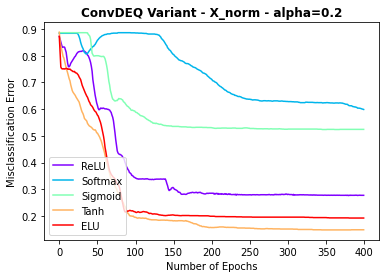

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('ConvDEQ Variant - X_norm - alpha=0.2', fontweight='bold')
plt.legend()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

error = {}
best_models = {}
activation_list = ['ReLU', 'Tanh', 'Sigmoid',  'ELU'] #'Softmax'

for act in activation_list:

  f = ConvDEQLayer_NO_X(d+l, d+l, d+l, d+l, A_scaled, act, alpha=0.2)
  model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=25, m=5),
                        nn.Linear(d+l, l),
                        nn.Softmax()).to(device)

  opt = optim.Adam(model.parameters(), lr=1e-3)
  print("# Parmeters: ", sum(a.numel() for a in model.parameters()))

  max_epochs = 500
  scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

  total_error = []
  total_loss = []

  for i in range(max_epochs):
        ep = epoch(X_LS_norm, Y, model, opt, scheduler, lambda_reg=0)

        total_error.append(ep[1])
        total_loss.append(ep[2])
        if not i%10 or i==max_epochs-1:
            print(i, ep)
        
        if i == 0:
            best_error = (ep[1], i)
            best_model = deepcopy(model)
        elif best_error[0] > ep[1]:
            best_error = (ep[1], i)
            best_model = deepcopy(model)
            
    print(best_error)
    best_models[act] = best_model
    error[act] = total_error

# Parmeters:  11850
0 (0.8857142857142857, 0.8597662771285476, 2.3005642890930176)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


1 (0.8571428571428571, 0.8653311074012242, 2.2985246181488037)
2 (0.8, 0.8647746243739566, 2.2964556217193604)
3 (0.8, 0.8636616583194212, 2.2943649291992188)
4 (0.8, 0.8419588202559822, 2.2922492027282715)
5 (0.7142857142857143, 0.8124652198107958, 2.290107011795044)
6 (0.6571428571428571, 0.798553144129104, 2.287928819656372)
7 (0.6571428571428571, 0.7902058987200891, 2.2857158184051514)
8 (0.6571428571428571, 0.7874234835837507, 2.283457040786743)
9 (0.6571428571428571, 0.7851975514746801, 2.2811501026153564)
10 (0.6857142857142857, 0.7851975514746801, 2.278785467147827)
11 (0.6857142857142857, 0.7851975514746801, 2.276355028152466)
12 (0.6857142857142857, 0.7885364496382861, 2.273854970932007)
13 (0.6571428571428571, 0.7879799666110183, 2.2712833881378174)
14 (0.6571428571428571, 0.7885364496382861, 2.2686288356781006)
15 (0.6571428571428571, 0.7885364496382861, 2.2658843994140625)
16 (0.6571428571428571, 0.7874234835837507, 2.2630481719970703)
17 (0.6571428571428571, 0.78797996661

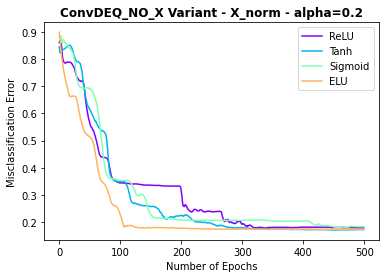

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('ConvDEQ_NO_X Variant - X_norm - alpha=0.2', fontweight='bold')
plt.legend()

### KIPF & WELLING $\longrightarrow f(X, A) = \text{softmax}\left(A \text{ ReLU} (A X W_1) W_2 \right)$



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

error = {}
activation_list = ['ReLU', 'Sigmoid', 'Tanh', 'ELU']#, 'Softmax', ]

for act in activation_list:

    model_KIPF = nn.Sequential(nn.Linear(d, d),
                               nn.ReLU(),
                               nn.Linear(d, d),
                               nn.Softmax()).to(device)

    AX = torch.tensor(A_scaled.toarray(), dtype=torch.float32, device=device) @ (X / torch.max(X, 1)[0].reshape(-1,1)).to(device)                               

    opt = optim.Adam(model_KIPF.parameters(), lr=1e-3)

    print("# Parmeters: ", sum(a.numel() for a in model_KIPF.parameters()))

    max_epochs = 500
    scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

    total_error = []
    total_loss = []

    for i in range(max_epochs):
        ep = epoch(AX, Y, model_KIPF, opt, scheduler)
        total_error.append(ep[1])
        total_loss.append(ep[2])
        # if not i%100 or i==max_epochs-1:
        print(i, ep)
    error[act] = total_error

# Parmeters:  8320
0 (1.0, 0.9805230940456316, 4.158778190612793)
1 (1.0, 0.9805230940456316, 4.158332824707031)
2 (1.0, 0.9805230940456316, 4.157886028289795)
3 (1.0, 0.9799666110183639, 4.1574225425720215)
4 (0.9428571428571428, 0.9582637729549248, 4.156937122344971)
5 (0.8857142857142857, 0.9248747913188647, 4.156423091888428)
6 (0.8857142857142857, 0.900946021146355, 4.1558837890625)
7 (0.8571428571428571, 0.8964941569282137, 4.155313014984131)
8 (0.8285714285714286, 0.8725653867557039, 4.154703617095947)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


9 (0.8285714285714286, 0.8542014468558708, 4.15404748916626)
10 (0.7714285714285715, 0.8302726766833611, 4.153332233428955)
11 (0.6285714285714286, 0.8041179744017808, 4.152554035186768)
12 (0.6571428571428571, 0.7996661101836394, 4.151700496673584)
13 (0.6571428571428571, 0.80189204229271, 4.1507697105407715)
14 (0.6571428571428571, 0.805230940456316, 4.1497483253479)
15 (0.6571428571428571, 0.8057874234835838, 4.148624897003174)
16 (0.6571428571428571, 0.806900389538119, 4.147380352020264)
17 (0.6571428571428571, 0.8074568725653868, 4.146000862121582)
18 (0.6571428571428571, 0.8074568725653868, 4.144482135772705)
19 (0.6, 0.8102392877017252, 4.142810821533203)
20 (0.6, 0.808569838619922, 4.140964508056641)
21 (0.6, 0.8080133555926544, 4.1389288902282715)
22 (0.6285714285714286, 0.8107957707289928, 4.136685848236084)
23 (0.6285714285714286, 0.8119087367835282, 4.134201526641846)
24 (0.6, 0.8113522537562604, 4.131433486938477)
25 (0.6, 0.8107957707289928, 4.1283698081970215)
26 (0.6, 0

### Graph DEQ  $ \longrightarrow Z = \sigma \left( \bar{A} Z W + X U + b \right) $

Assume we are considering a Graph DEQ layer of the form:
$$ Z = \sigma \left( \bar{A} Z W + X U + b \right), $$
where $X$ is the feature matrix, $W$ and $U$ are weight matrices and $b$ is the bias term.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

error = {}
activation_list = ['ReLU', 'Softmax', 'Sigmoid', 'Tanh', 'ELU']

for act in activation_list:
  f = ConvDEQLayer(l, l, d, l, A_scaled, act)
  model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-7, max_iter=25, m=5)).to(device)

  opt = optim.Adam(model.parameters(), lr=1e-3)
  print("# Parmeters: ", sum(a.numel() for a in model.parameters()))

  max_epochs = 150
  scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*X.shape[0], eta_min=1e-6)

  total_error = []
  total_loss = []

  for i in range(max_epochs):
    ep = epoch(X, Y, model, opt, scheduler)
    total_error.append(ep[0])
    total_loss.append(ep[1])
    print(i, ep)
  error[act] = total_error

# Parmeters:  760
0 (0.8558708959376738, 2.243570327758789)
1 (0.8191430161380078, 2.112009048461914)
2 (0.7534780189204229, 1.993079662322998)
3 (0.7173066221480244, 1.875907063484192)
4 (0.6950473010573177, 1.7619233131408691)
5 (0.6683361157484696, 1.6550382375717163)
6 (0.6316082359488036, 1.5550410747528076)
7 (0.5976627712854758, 1.4630541801452637)
8 (0.5592654424040067, 1.3785234689712524)
9 (0.5358931552587646, 1.3006137609481812)
10 (0.5119643850862549, 1.2286604642868042)
11 (0.48970506399554814, 1.1617904901504517)
12 (0.47356705620478573, 1.0994136333465576)
13 (0.452977184195882, 1.041404366493225)
14 (0.444629938786867, 0.9879602789878845)
15 (0.43962159154145797, 0.938997745513916)
16 (0.4318308291597106, 0.8942261934280396)
17 (0.42960489705064, 0.8531408905982971)
18 (0.4234835837506956, 0.8153696656227112)
19 (0.4201446855870896, 0.7805019617080688)
20 (0.41736227045075125, 0.7481682300567627)
21 (0.41569282136894825, 0.7181344628334045)
22 (0.4129104062326099, 0.690

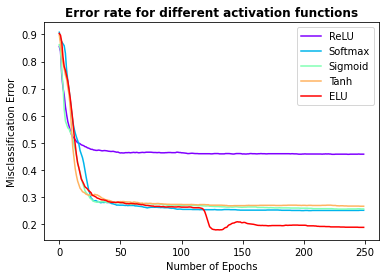

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('Error rate for different activation functions', fontweight='bold')
plt.legend()

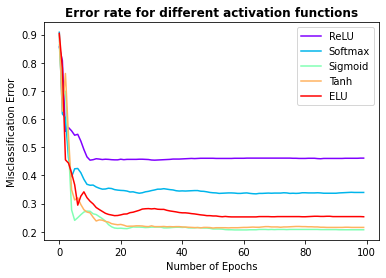

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('Error rate for different activation functions', fontweight='bold')
plt.legend()

### Tilde Graph DEQ  $ \longrightarrow Z = \sigma \left( \bar{A} Z W + \tilde{X} U + b \right) $

Assume we now want to try to consider a slightly different matrix $X$, in which we do not take into account only for the information stored in the features of our data, but also for the known labels. In particular, we will take into account: 
$$ \tilde{X} = \begin{bmatrix} Y & X  \end{bmatrix}, $$ where $X \in \mathbb{R}^{n \times d}$ is the feature matrix and $Y \in \mathbb{R}^{n \times l}$ is the label matrix, where each row corresponds to the one-hot-encoded label.
In this setting, we once again consider the DEQ layer defined as follows:
$$ Z = \sigma \left( \bar{A} Z W + \tilde{X} U + b \right). $$

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

error = {}
activation_list = ['ReLU', 'Softmax', 'Sigmoid', 'Tanh', 'ELU']

for act in activation_list:

  f = ConvDEQLayer(l, l, d + l, l, A_scaled, act) # notice that w.r.t. the previous operation, we modified the dimenion of the U matrix.
  model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-7, max_iter=25, m=5)).to(device)

  opt = optim.Adam(model.parameters(), lr=1e-3)
  print("# Parmeters: ", sum(a.numel() for a in model.parameters()))

  max_epochs = 150
  scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*X.shape[0], eta_min=1e-6)

  total_error = []
  total_loss = []

  for i in range(max_epochs):
      ep = epoch(X_, Y, model, opt, scheduler)
      total_error.append(ep[0])
      total_loss.append(ep[1])
      print(i, ep)
  error[act] = total_error

# Parmeters:  860


RuntimeError: ignored

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('Error rate - 3% labelled', fontweight='bold')
plt.legend()

KeyError: ignored

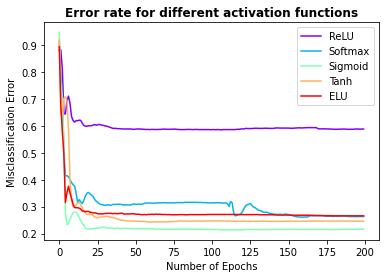

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('Error rate for different activation functions', fontweight='bold')
plt.legend()

### Stacked Graph DEQ  $ \longrightarrow \tilde{Y} = softmax \left( Z^{\star} \Theta \right)$

We now try to build our architecture slightly differently. We always consider the Graph DEQ layer, but on top of that, we assing a softmax layer. In detail, we will not consider $Z$ as the matrix of the labels anymore, giving it dimension $n \times (d+l)$. Therefore, the model we obtain will have the form:
$$ \tilde{Y} = softmax \left( Z^{\star} \Theta \right),$$
where $Z^{\star}$ is the solution of the DEQ layer $ Z = \sigma \left( \bar{A} Z W + \tilde{X} U + B \right)$ and $\Theta \in \mathbb{R}^{(d+l) \times m}$, with $m$ an arbitrarily fixed value.

- $Z \sim n \times (d+l)$
- $W \sim (d+l) \times (d+l) $
- $\tilde{X} \sim n \times (d+l)$
- $U \sim (d+l) \times (d+l)$

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

error = {}
activation_list = ['ReLU', 'Softmax', 'Sigmoid', 'Tanh', 'ELU']

for act in activation_list:

  f = ConvDEQLayer(d + l, d+l, d + l, d+l, A_scaled, act) # notice that w.r.t. the previous operation, we modified the dimenion of the U matrix.
  model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-7, max_iter=25, m=5),
                        nn.Linear(d+l, 10),
                        nn.Softmax()).to(device)

  opt = optim.Adam(model.parameters(), lr=1e-3)
  print("# Parmeters: ", sum(a.numel() for a in model.parameters()))

  max_epochs = 150
  scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*X.shape[0], eta_min=1e-6)

  total_error = []
  total_loss = []

  for i in range(max_epochs):
      ep = epoch(X_, Y, model, opt, scheduler)
      total_error.append(ep[0])
      total_loss.append(ep[1])
      print(i, ep)
  error[act] = total_error

# Parmeters:  11850


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 (0.9493600445186422, 2.30822491645813)
1 (0.8920422927100723, 2.2855122089385986)
2 (0.9031719532554258, 2.2605831623077393)
3 (0.9031719532554258, 2.235314130783081)
4 (0.9031719532554258, 2.210054874420166)
5 (0.9003895381190874, 2.1861319541931152)
6 (0.8647746243739566, 2.1589248180389404)
7 (0.7979966611018364, 2.1253421306610107)
8 (0.7017250973845298, 2.089484214782715)
9 (0.6494156928213689, 2.0561540126800537)
10 (0.6405119643850863, 2.025529623031616)
11 (0.6382860322760155, 1.995552897453308)
12 (0.6343906510851419, 1.965186595916748)
13 (0.6355036171396773, 1.9375464916229248)
14 (0.6371730662214803, 1.9163764715194702)
15 (0.6377295492487479, 1.8978121280670166)
16 (0.6338341680578742, 1.8782049417495728)
17 (0.6243739565943238, 1.8580502271652222)
18 (0.5993322203672788, 1.8357374668121338)
19 (0.5503617139677239, 1.8101112842559814)
20 (0.526989426822482, 1.7897790670394897)
21 (0.5214245965498052, 1.7815781831741333)
22 (0.5069560378408459, 1.7730690240859985)
23 (0.4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0 (0.9003895381190874, 2.30279803276062)
1 (0.9003895381190874, 2.30228853225708)
2 (0.9003895381190874, 2.3018007278442383)
3 (0.9003895381190874, 2.3013393878936768)
4 (0.8937117417918754, 2.3009045124053955)
5 (0.8553144129104062, 2.300490140914917)
6 (0.8252643294379521, 2.3000898361206055)
7 (0.8141346688925988, 2.2997000217437744)
8 (0.8091263216471898, 2.299316167831421)
9 (0.8041179744017808, 2.2989344596862793)
10 (0.7974401780745687, 2.2985496520996094)
11 (0.7879799666110183, 2.298159122467041)
12 (0.780189204229271, 2.2977609634399414)
13 (0.7712854757929883, 2.297353506088257)
14 (0.761825264329438, 2.2969377040863037)
15 (0.7523650528658876, 2.296513795852661)
16 (0.7473567056204786, 2.296083927154541)
17 (0.7456872565386756, 2.2956483364105225)
18 (0.7390094602114635, 2.2952067852020264)
19 (0.7351140790205899, 2.2947585582733154)
20 (0.7323316638842515, 2.2943007946014404)
21 (0.7295492487479132, 2.2938318252563477)
22 (0.7256538675570395, 2.293351888656616)
23 (0.72342

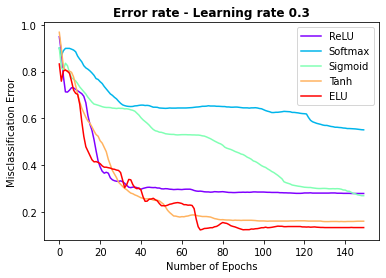

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('Error rate - Learning rate 0.3', fontweight='bold')
plt.legend()

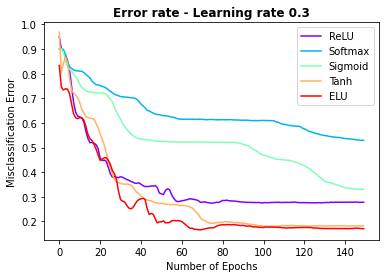

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('Error rate - Learning rate 0.3', fontweight='bold')
plt.legend()

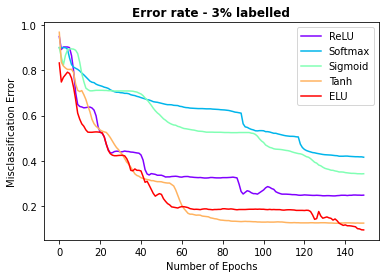

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('Error rate - 3% labelled', fontweight='bold')
plt.legend()

### Stacked DEQ BIS $\longrightarrow \tilde{Y} = softmax \left( Z^{\star} \Theta \right), Z = \sigma(\bar{A}ZW) + UX_0$

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

error = {}
activation_list = ['ReLU', 'Tanh', 'ELU']#, 'Softmax', 'Sigmoid']

for act in activation_list:

  f = ConvDEQLayer_NO_X(d+l, d+l, d+l, d+l, A_scaled, act) # notice that w.r.t. the previous operation, we modified the dimenion of the U matrix.
  model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-7, max_iter=50, m=5),
                        nn.Linear(d+l, 10),
                        nn.Softmax()).to(device)

  opt = optim.Adam(model.parameters(), lr=1e-3)
  print("# Parmeters: ", sum(a.numel() for a in model.parameters()))

  max_epochs = 200
  scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*X.shape[0], eta_min=1e-6)
  # scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.9)

  total_error = []
  total_loss = []

  for i in range(max_epochs):
      ep = epoch(X_, Y, model, opt, scheduler)
      total_error.append(ep[0])
      total_loss.append(ep[1])
      print(i, ep)
  error[act] = total_error

# Parmeters:  11850


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 (0.8857142857142857, 0.8414023372287145, 2.115936756134033)
1 (0.8571428571428571, 0.8452977184195882, 2.0643625259399414)
2 (0.8285714285714286, 0.8547579298831386, 2.0044052600860596)
3 (0.8, 0.8519755147468002, 1.8643115758895874)
4 (0.7142857142857143, 0.8341680578742349, 1.7482373714447021)
5 (0.6, 0.8057874234835838, 1.6758384704589844)
6 (0.6, 0.7824151363383417, 1.6294457912445068)
7 (0.5428571428571428, 0.763494713411241, 1.6332385540008545)
8 (0.5428571428571428, 0.7473567056204786, 1.6183924674987793)
9 (0.5142857142857142, 0.7262103505843072, 1.6521636247634888)
10 (0.5142857142857142, 0.7056204785754034, 1.6584676504135132)
11 (0.5142857142857142, 0.6889259877573733, 1.6281380653381348)
12 (0.5142857142857142, 0.6705620478575404, 1.5880985260009766)
13 (0.5142857142857142, 0.6572064552031163, 1.54658842086792)
14 (0.5142857142857142, 0.6432943795214245, 1.508167028427124)
15 (0.45714285714285713, 0.6293823038397329, 1.528827428817749)
16 (0.42857142857142855, 0.619365609

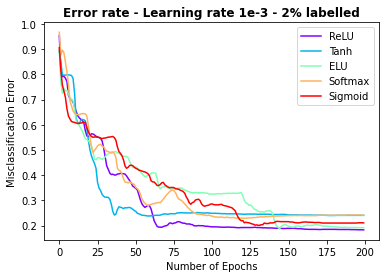

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('Error rate - Learning rate 1e-3 - 2% labelled', fontweight='bold')
plt.legend()

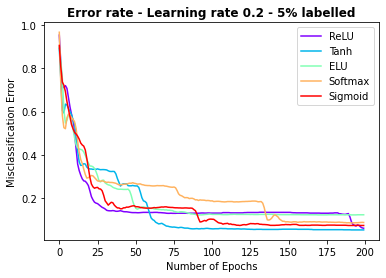

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('Error rate - Learning rate 0.2 - 5% labelled', fontweight='bold')
plt.legend()

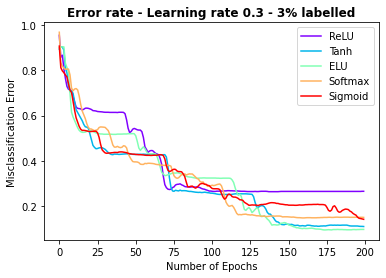

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('Error rate - Learning rate 0.3 - 3% labelled', fontweight='bold')
plt.legend()

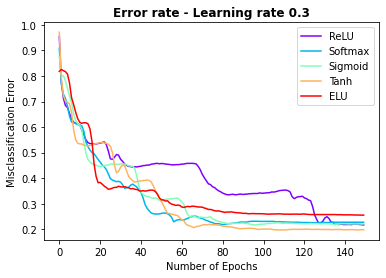

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('Error rate - Learning rate 0.3', fontweight='bold')
plt.legend()

### SkewSymmetric DEQ $\longrightarrow W = \begin{bmatrix} \mathbb{0} & \boldsymbol{K}\\
-\boldsymbol{K}^{\top} & \mathbb{0} \end{bmatrix}$


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

error = {}
activation_list = ['ReLU', 'Softmax', 'Sigmoid', 'Tanh', 'ELU']

K1 = d - 3*l
K2 = 4*l

for act in activation_list:

  f = SkewSym_ConvDEQLayer(K1, K2, d+l, d+l, A_scaled, act)
  model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-7, max_iter=25, m=5),
                        nn.Linear(d+l, 10),
                        nn.Softmax()).to(device)

  opt = optim.Adam(model.parameters(), lr=1e-3)
  print("# Parmeters: ", sum(a.numel() for a in model.parameters()))

  max_epochs = 150
  scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*X.shape[0], eta_min=1e-6)

  total_error = []
  total_loss = []

  for i in range(max_epochs):
      ep = epoch(X_, Y, model, opt, scheduler)
      total_error.append(ep[0])
      total_loss.append(ep[1])
      print(i, ep)
  error[act] = total_error

# Parmeters:  7660


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 (0.8864774624373957, 2.327700614929199)
1 (0.8486366165831942, 2.307111978530884)
2 (0.8074568725653868, 2.2850019931793213)
3 (0.7640511964385086, 2.2614874839782715)
4 (0.7484696716750139, 2.236433982849121)
5 (0.7250973845297718, 2.21089768409729)
6 (0.7239844184752365, 2.1861960887908936)
7 (0.7239844184752365, 2.1628987789154053)
8 (0.7289927657206455, 2.141815662384033)
9 (0.7301057317751809, 2.123837947845459)
10 (0.7273233166388425, 2.1076080799102783)
11 (0.7212020033388982, 2.090775728225708)
12 (0.7028380634390651, 2.073066473007202)
13 (0.6772398441847524, 2.054426431655884)
14 (0.657762938230384, 2.0348198413848877)
15 (0.6399554813578185, 2.0154998302459717)
16 (0.6249304396215916, 1.9971815347671509)
17 (0.6143572621035058, 1.9803669452667236)
18 (0.6021146355036171, 1.9646892547607422)
19 (0.5876460767946577, 1.9495372772216797)
20 (0.5715080690038954, 1.934349536895752)
21 (0.552031163049527, 1.9194403886795044)
22 (0.5375626043405676, 1.904595971107483)
23 (0.521981

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0 (0.8469671675013912, 2.302457809448242)
1 (0.8391764051196439, 2.3017821311950684)
2 (0.8330550918196995, 2.3011128902435303)
3 (0.8241513633834168, 2.3004724979400635)
4 (0.8152476349471341, 2.2998805046081543)
5 (0.808569838619922, 2.299339532852173)
6 (0.7963272120200334, 2.298832416534424)
7 (0.7907623817473567, 2.2983357906341553)
8 (0.7840845854201447, 2.2978274822235107)
9 (0.773511407902059, 2.2972962856292725)
10 (0.7629382303839732, 2.2967405319213867)
11 (0.7534780189204229, 2.29616641998291)
12 (0.7306622148024485, 2.2955946922302246)
13 (0.7089593767390094, 2.2950522899627686)
14 (0.6922648859209795, 2.294560194015503)
15 (0.6766833611574847, 2.2941195964813232)
16 (0.6505286588759043, 2.2937097549438477)
17 (0.6377295492487479, 2.2933032512664795)
18 (0.6165831942125766, 2.2928833961486816)
19 (0.6032276015581525, 2.292442560195923)
20 (0.5848636616583194, 2.291985034942627)
21 (0.5715080690038954, 2.2915189266204834)
22 (0.5525876460767947, 2.2910537719726562)
23 (0.54

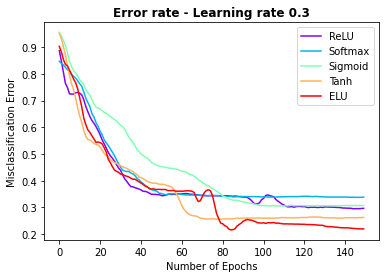

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('Error rate - Learning rate 0.3', fontweight='bold')
plt.legend()

## MNIST

In [ ]:
X, Y, A_scaled = mnist_import(build_adj_mat=True)

X = X[:30000]
Y = Y[:30000]
A_scaled = A_scaled[:30000, :30000]

n = X.shape[0]
d = X.shape[1]
l = 10 # number of labels
p = 0.02 # known labels proportion

# Let us select the known labels
known = np.random.choice(n, size=int(np.floor(n*p)), replace=False)
print('Number of known labels: ', len(known))

True


### Graph DEQ  $ \longrightarrow Z = \sigma \left( \bar{A} Z W + X U + b \right) $

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

error = {}
activation_list = ['ReLU', 'Softmax', 'Sigmoid', 'Tanh', 'ELU']

for act in activation_list:
  f = ConvDEQLayer(l, l, d, l, A_scaled, act)
  model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-2, max_iter=25, m=5)).to(device)

  opt = optim.Adam(model.parameters(), lr=1e-2)
  print("# Parmeters: ", sum(a.numel() for a in model.parameters()))

  max_epochs = 150
  scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*X.shape[0], eta_min=1e-6)

  total_error = []
  total_loss = []

  for i in range(max_epochs):
    ep = epoch(X, Y, model, opt, scheduler)
    total_error.append(ep[0])
    total_loss.append(ep[1])
    print(i, ep)
  error[act] = total_error

# Parmeters:  7960
0 (0.8491666666666666, 30.322734832763672)
1 (0.5765333333333333, 75.75284576416016)
2 (0.7500333333333333, 123.87406158447266)
3 (0.5172666666666667, 66.81846618652344)
4 (0.48536666666666667, 39.94746017456055)
5 (0.4765666666666667, 32.65398406982422)
6 (0.46086666666666665, 17.257495880126953)
7 (0.4274, 6.148179054260254)
8 (0.4664333333333333, 3.3653767108917236)
9 (0.5508333333333333, 3.899502754211426)
10 (0.6129333333333333, 2.857877492904663)
11 (0.6662666666666667, 1.9197251796722412)
12 (0.7118, 1.7013219594955444)
13 (0.7472333333333333, 1.765069603919983)
14 (0.7721, 1.8462461233139038)
15 (0.7917333333333333, 1.9129900932312012)
16 (0.8062666666666667, 1.9610800743103027)
17 (0.8162333333333334, 2.0014657974243164)
18 (0.8248, 2.0301756858825684)
19 (0.8311666666666667, 2.055856943130493)
20 (0.8368, 2.0767455101013184)
21 (0.8409666666666666, 2.087548017501831)
22 (0.8448, 2.103253126144409)
23 (0.8470333333333333, 2.1099495887756348)
24 (0.8481, 2.11

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0 (0.9022666666666667, 2.3728246688842773)
1 (0.7506, 2.162874460220337)
2 (0.7305666666666667, 2.1469340324401855)
3 (0.7266, 2.1471757888793945)
4 (0.7067333333333333, 2.127526044845581)
5 (0.7023, 2.1241462230682373)
6 (0.7112666666666667, 2.131418228149414)
7 (0.6963333333333334, 2.119245767593384)
8 (0.6896333333333333, 2.1092545986175537)
9 (0.6863, 2.1043388843536377)
10 (0.6854, 2.1030476093292236)
11 (0.6843666666666667, 2.1010515689849854)
12 (0.6837333333333333, 2.101109266281128)
13 (0.6831, 2.1010594367980957)
14 (0.6826333333333333, 2.0977916717529297)
15 (0.6826, 2.0977485179901123)
16 (0.6823, 2.099224090576172)
17 (0.6838666666666666, 2.0988450050354004)
18 (0.6843666666666667, 2.101015567779541)
19 (0.6853666666666667, 2.1027820110321045)
20 (0.6865333333333333, 2.1044347286224365)
21 (0.6874, 2.106051445007324)
22 (0.6887666666666666, 2.106078863143921)
23 (0.6898666666666666, 2.109468460083008)
24 (0.6911, 2.109431266784668)
25 (0.6918333333333333, 2.110219478607177

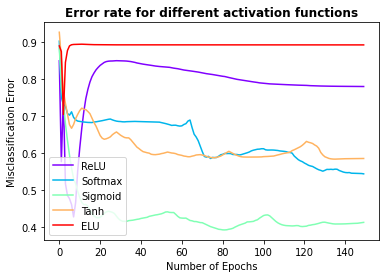

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('Error rate for different activation functions', fontweight='bold')
plt.legend()

### Tilde Graph DEQ  $ \longrightarrow Z = \sigma \left( \bar{A} Z W + \tilde{X} U + b \right) $

In [ ]:
# Construct the X_ matrix containing not just features but also the labels of the known points.
X_ = torch.cat([torch.zeros(X.shape[0], l), X], axis=1)
X_[known, :10] = F.one_hot(Y[known]).type(torch.float)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

error = {}
activation_list = ['ReLU', 'Softmax', 'Sigmoid', 'Tanh', 'ELU']

for act in activation_list:

  f = ConvDEQLayer(l, l, d + l, l, A_scaled, act) # notice that w.r.t. the previous operation, we modified the dimenion of the U matrix.
  model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-2, max_iter=25, m=5)).to(device)

  opt = optim.Adam(model.parameters(), lr=1e-2)
  print("# Parmeters: ", sum(a.numel() for a in model.parameters()))

  max_epochs = 150
  scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*X.shape[0], eta_min=1e-6)

  total_error = []
  total_loss = []

  for i in range(max_epochs):
      ep = epoch(X_, Y, model, opt, scheduler)
      total_error.append(ep[0])
      total_loss.append(ep[1])
      print(i, ep)
  error[act] = total_error

# Parmeters:  8060
0 (0.8571666666666666, 28.955608367919922)
1 (0.7630333333333333, 139.27960205078125)
2 (0.7126333333333333, 176.86151123046875)
3 (0.7075333333333333, 136.18020629882812)
4 (0.6564333333333333, 118.46089935302734)
5 (0.6225333333333334, 59.16973876953125)
6 (0.5392666666666667, 11.33362102508545)
7 (0.6241, 4.014439105987549)
8 (0.6837, 2.2221081256866455)
9 (0.7261666666666666, 1.9030784368515015)
10 (0.7549666666666667, 1.9597609043121338)
11 (0.7781, 2.0040066242218018)
12 (0.7973666666666667, 2.0646326541900635)
13 (0.8145333333333333, 2.083965539932251)
14 (0.8282666666666667, 2.1243865489959717)
15 (0.8365, 2.147103786468506)
16 (0.8431, 2.157372236251831)
17 (0.8487666666666667, 2.176544427871704)
18 (0.8534666666666667, 2.185102701187134)
19 (0.8575, 2.191628932952881)
20 (0.8604333333333334, 2.19897723197937)
21 (0.8632, 2.2066588401794434)
22 (0.8654, 2.2066807746887207)
23 (0.8673666666666666, 2.210496664047241)
24 (0.8689333333333333, 2.210496664047241)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0 (0.8765333333333334, 2.3098769187927246)
1 (0.8414666666666667, 2.2751457691192627)
2 (0.706, 2.1671924591064453)
3 (0.6661, 2.1298887729644775)
4 (0.6762, 2.155742883682251)
5 (0.6941666666666667, 2.160316228866577)
6 (0.6794, 2.1490659713745117)
7 (0.6716333333333333, 2.1411917209625244)
8 (0.6621, 2.134999990463257)
9 (0.6583666666666667, 2.1329147815704346)
10 (0.6562, 2.1364564895629883)
11 (0.6538333333333334, 2.1305484771728516)
12 (0.6564666666666666, 2.1308202743530273)
13 (0.6585, 2.134608507156372)
14 (0.6601, 2.134143352508545)
15 (0.6549666666666667, 2.1257994174957275)
16 (0.6476666666666666, 2.121126651763916)
17 (0.6412, 2.1048521995544434)
18 (0.6381, 2.1076769828796387)
19 (0.6370666666666667, 2.10768461227417)
20 (0.6357, 2.104379415512085)
21 (0.6353, 2.102301836013794)
22 (0.6350333333333333, 2.102755546569824)
23 (0.6358666666666667, 2.1027350425720215)
24 (0.6376, 2.1079273223876953)
25 (0.6381333333333333, 2.1028947830200195)
26 (0.6387, 2.101217269897461)
27 

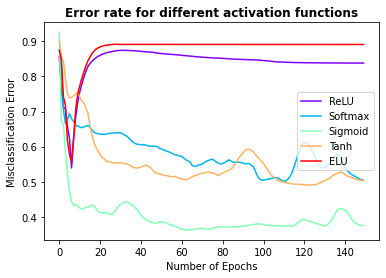

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('Error rate for different activation functions', fontweight='bold')
plt.legend()

### Stacked Graph DEQ  $ \longrightarrow \tilde{Y} = softmax \left( Z^{\star} \Theta \right)$

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

error = {}
activation_list = ['ReLU', 'Softmax', 'Sigmoid', 'Tanh', 'ELU']

for act in activation_list:

  f = ConvDEQLayer(l, l, d + l, l, A_scaled, act) # notice that w.r.t. the previous operation, we modified the dimenion of the U matrix.
  model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-2, max_iter=25, m=5)).to(device)

  opt = optim.Adam(model.parameters(), lr=1e-2)
  print("# Parmeters: ", sum(a.numel() for a in model.parameters()))

  max_epochs = 150
  scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*X.shape[0], eta_min=1e-6)

  total_error = []
  total_loss = []

  for i in range(max_epochs):
      ep = epoch(X_, Y, model, opt, scheduler)
      total_error.append(ep[0])
      total_loss.append(ep[1])
      print(i, ep)
  error[act] = total_error

# Parmeters:  8060


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0 (0.8571, 2.3137621879577637)
1 (0.7437666666666667, 2.199399709701538)
2 (0.8196, 2.2667436599731445)
3 (0.7834, 2.2294790744781494)
4 (0.7823, 2.239253044128418)
5 (0.7987, 2.259310007095337)
6 (0.7806666666666666, 2.2476577758789062)
7 (0.7695, 2.2356481552124023)
8 (0.7579666666666667, 2.2117292881011963)
9 (0.7380333333333333, 2.189284086227417)
10 (0.7295333333333334, 2.184004545211792)
11 (0.7271, 2.179290294647217)
12 (0.7262, 2.180983304977417)
13 (0.7255333333333334, 2.1793360710144043)
14 (0.7255, 2.1778008937835693)
15 (0.7256666666666667, 2.1760663986206055)
16 (0.7262666666666666, 2.1743600368499756)
17 (0.7271, 2.175748586654663)
18 (0.7267666666666667, 2.176046371459961)
19 (0.7277, 2.1775600910186768)
20 (0.7282333333333333, 2.176035165786743)
21 (0.7291333333333333, 2.175935983657837)
22 (0.7289, 2.1727192401885986)
23 (0.7290666666666666, 2.1726796627044678)
24 (0.7291333333333333, 2.172646999359131)
25 (0.7295, 2.172513484954834)
26 (0.7294666666666667, 2.172593593

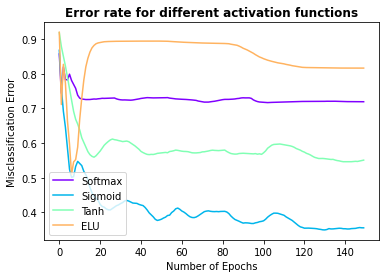

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('Error rate for different activation functions', fontweight='bold')
plt.legend()

## Rice31 - Facebook100



In [ ]:
X, Y, A_scaled = facebook100_import('Rice31.mat')

Non-Null adjacency matrix shape: (3564, 3564)
Connected adjacency matrix shape: (3560, 3560)
Connected Feature Matrix shape: (3560, 7)
torch.Size([3560, 1644])


In [ ]:
n = X.shape[0]
d = X.shape[1]
l = len(Y.unique()) # number of labels
p = 0.05 # known labels proportion

# Let us select the known labels
known = []
for lab in Y.unique():
    known_lab = torch.where(Y == lab)[0].numpy()
    known.extend(np.random.choice(known_lab, size=int(np.floor(len(known_lab)*p)), replace=False))
print('Number of known labels: ', len(known))

unknown = np.ones(n, dtype=bool)
unknown[known] = False

Y_one_hot = pd.get_dummies(Y)

# Construct the X_ matrix containing not just features but also the labels of the known points.
X_ = torch.cat([torch.zeros(X.shape[0], l), X], axis=1)
X_[known, :l] = torch.tensor(Y_one_hot.iloc[known].values, dtype=torch.float32)

Number of known labels:  174


### Fully Cross-Validated Model

In [ ]:
######### FULLY CROSS-VALIDATED MODEL ##########

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

n_rand_sampling = 1 # No. of different random samplings we will consider

activation_list = ['ReLU'] #'Tanh'

LS_accuracies = []
errors = {}
best_models = {}
total_errors = {}
errors_KIPF = {}
errors_KIPF_1000 = {}

for j in np.arange(n_rand_sampling):
    # We define a kfold with a random_state so that we can use the same split for
    # cross-validating both Label Spreading and the neural network.
    kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=rand.randint(0,10000))

    # Extraction of the known and unknown labels
    known = []
    for lab in Y.unique():
        known_lab = torch.where(Y == lab)[0].numpy()
        known.extend(np.random.choice(known_lab, size=int(np.floor(len(known_lab)*p)), replace=False))

    unknown = np.ones(n, dtype=bool)
    unknown[known] = False
    
    print('-------------------------------------------------------------------------')
    print('\t \t Random Sampling No. %d' %(j+1))
    print('-------------------------------------------------------------------------\n')
    print('Number of known labels: %d \n' %(len(known)))
    
    
    ############# LABEL SPREADING CROSS-VALIDATION #############

    print('############# LABEL SPREADING CROSS-VALIDATION #############')
    accuracies_alpha = {}

    for alpha in [0.1, 0.3, 0.5, 0.7, 0.9]:
        accuracy_folds = {}
        print('----------------------- Alpha=%.1f ----------------------' %(alpha))
        
        for fold, (train_ids, validation_ids) in enumerate(kfold.split(X_[known], Y[known])):
            train_ids = [known[j] for j in train_ids]
            validation_ids = [known[j] for j in validation_ids]
            
            X_zeros = torch.cat([torch.zeros(X.shape[0], l), X], axis=1)
            X_zeros[train_ids, :l] = torch.tensor(Y_one_hot.iloc[train_ids].values, dtype=torch.float32)
            X_LS = linear_label_spreading(X_zeros, A_scaled, alpha=alpha, tol=1e-5, max_iter=50)

            fold_pred = X_LS[validation_ids, :l].max(dim=1)[1]
            fold_accuracy = (fold_pred == Y[validation_ids].view(-1)).sum().item() / float(len(validation_ids))
            accuracy_folds[fold] = fold_accuracy

            # print('Fold %d - Validation Accuracy: %.3f' %(fold, fold_accuracy))
        
        accuracies_alpha[alpha] = np.mean(list(accuracy_folds.values()))
        print('---- Average Validation Accuracy for Alpha=%.1f: %.3f ---- \n' %(alpha, accuracies_alpha[alpha]))

    best_alpha = max(accuracies_alpha.keys(), key=(lambda x: accuracies_alpha[x]))
    # best_alphas.append(best_alpha)
    print('---------- Label Spreading - Best Alpha = %.1f ---------- \n' %(best_alpha))
    

    # LABEL SPREADING EVALUATION FOR best_alpha FOR THE RANDOM SAMPLING
    X_LS = linear_label_spreading(X_, A_scaled, alpha=best_alpha)

    X_LS_norm = X_LS / torch.max(X_LS, dim=1).values.reshape(-1,1)
    LS_accuracy = torch.sum((torch.argmax(X_LS[unknown,:l], 1) - Y[unknown])==0).item()/ float(len(unknown))
    LS_accuracies.append(LS_accuracy)

    print('---------- Label Spreading - Accuracy = %.3f ---------- \n' %(LS_accuracy))

    accuracies_beta = {}

    print('############# NEURAL NETWORK CROSS-VALIDATION #############')
    

    for act in activation_list:

        for beta in [0.1, 0.3, 0.5]:
            accuracy_folds = {}
            print('----------------------- Beta=%.1f ----------------------' %(beta))
            
            for fold, (train_ids, validation_ids) in enumerate(kfold.split(X_[known], Y[known])):

                train_ids = [known[j] for j in train_ids]
                validation_ids = [known[j] for j in validation_ids]

                f = ConvDEQLayer_NO_X(d+l, d+l, d+l, d+l, A_scaled, act, beta=beta)
                model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=50, m=5),
                                            nn.Linear(d+l, l),
                                            nn.Softmax(dim=1)
                                            ).to(device)

                opt = optim.Adam(model.parameters(), lr=1e-3)

                max_epochs = 100
                scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

                for i in np.arange(max_epochs):
                    ep = epoch_fold(X_LS_norm, Y, model, opt, scheduler, lambda_reg=0)

                    if not i%25 or i==max_epochs-1:
                        print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                            %(i, ep[0], ep[1], ep[2], ep[3]))
                    
                    if i == 0:
                        best_error = (ep[2], i)
                        best_model = deepcopy(model)
                    elif best_error[0] > ep[2]:
                        best_error = (ep[2], i)
                        best_model = deepcopy(model)

                # print('\t Fold %d - Best Error : %.3f - Reached at epoch %d' %(fold, best_error[0], best_error[1]))
                fold_pred = best_model(X_LS_norm.to(device))[validation_ids].max(dim=1)[1].detach().cpu()
                accuracy_folds[fold] = (fold_pred == Y[validation_ids].view(-1)).sum().item() / float(len(validation_ids))
            
            accuracies_beta[beta] = np.mean(list(accuracy_folds.values()))
            print('---- Average Validation Accuracy for Beta=%.1f: %.3f ---- \n' %(beta, accuracies_beta[beta]))

        best_beta = max(accuracies_beta.keys(), key=(lambda x: accuracies_beta[x]))
        print('--------------------- Best Beta=%.1f -------------------- \n' %(best_beta))
        print('--------------------- Model Training -------------------- \n')

        f = ConvDEQLayer_NO_X(d+l, d+l, d+l, d+l, A_scaled, act, beta=best_beta)
        model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=50, m=5),
                                        nn.Linear(d+l, l),
                                        nn.Softmax(dim=1)
                                        ).to(device)

        opt = optim.Adam(model.parameters(), lr=1e-3)

        print("Model Parmeters: %d " %(sum(a.numel() for a in model.parameters())))

        max_epochs = 750
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        train_error = []
        train_loss = []
        test_error = []
        test_loss = []

        for i in range(max_epochs):
            ep = epoch(X_LS_norm, Y, model, opt, scheduler, lambda_reg=0)

            train_error.append(ep[0])
            train_loss.append(ep[1])
            test_error.append(ep[2])
            test_loss.append(ep[3])

            if not i%10 or i==max_epochs-1:
                print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                        %(i, ep[0], ep[1], ep[2], ep[3]))
            
            if i == 0:
                best_error = (ep[2], i)
                best_model = deepcopy(model)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)
                best_model = deepcopy(model)

        print('------- Activation=%s - Best Error=%.5f (ep. %d) ------- \n' %(act, best_error[0], best_error[1]))

        act_ = act + '_' + str(j)
        best_models[act_] = best_model
        errors[act_] = best_error[0]
        total_errors[act_] = test_error

    print('------------------ Kipf and Welling Training ----------------- \n')        

    model_KIPF = nn.Sequential(nn.Linear(d, d),
                            nn.ReLU(),
                            nn.Linear(d, d),
                            nn.Softmax(dim=1)).to(device)

    AX = torch.tensor(A_scaled.toarray(), dtype=torch.float32, device=device) @ (X / torch.max(X, 1)[0].reshape(-1,1)).to(device)                               

    opt = optim.Adam(model_KIPF.parameters(), lr=1e-3)

    print("Parmeters: ", sum(a.numel() for a in model_KIPF.parameters()))

    max_epochs = 3000
    scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

    # train_error_KIPF = []
    # train_loss_KIPF = []
    # test_error_KIPF = []
    # test_loss_KIPF = []

    for i in range(max_epochs):
        ep = epoch(AX, Y, model_KIPF, opt, scheduler, lambda_reg=0)
        # train_error_KIPF.append(ep[0])
        # train_loss_KIPF.append(ep[1])
        # test_error_KIPF.append(ep[2])
        # test_loss_KIPF.append(ep[3])
        if not i%200 or i==max_epochs-1:
            print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                  %(i, ep[0], ep[1], ep[2], ep[3]))
            
        if i == 0:
            best_error_KIPF = (ep[2], i)
            best_error_KIPF_1000 = (ep[2], i)
            best_model_KIPF = deepcopy(model_KIPF)
        elif best_error_KIPF[0] > ep[2]:
                if i < 1000:
                    best_error_KIPF = (ep[2], i)
                    best_error_KIPF_1000 = (ep[2], i)
                    best_model_KIPF = deepcopy(model_KIPF)
                else:
                    best_error_KIPF = (ep[2], i)
                    best_model_KIPF = deepcopy(model_KIPF)

    print('-------- Best Error=%.5f reached at Ep. %d -------- \n' %(best_error_KIPF[0], best_error_KIPF[1]))
    print('---- Best Error after 1000 Ep.=%.5f (at Ep. %d) ---- \n' %(best_error_KIPF_1000[0], best_error_KIPF_1000[1]))
            
    act_ = 'ReLU' + '_' + str(i)
    errors_KIPF[act_] = best_error_KIPF[0]
    errors_KIPF_1000[act_] = best_error_KIPF_1000[0]

avg_acc_ReLU = 1 - np.mean([errors[act] for act in errors.keys() if act.startswith('ReLU')])
avg_acc_Tanh = 1 - np.mean([errors[act] for act in errors.keys() if act.startswith('Tanh')])
avg_acc_KIPF = 1 - np.mean([errors_KIPF[act] for act in errors_KIPF.keys() if act.startswith('ReLU')])
avg_acc_KIPF_1000 = 1 - np.mean([errors_KIPF_1000[act] for act in errors_KIPF_1000.keys() if act.startswith('ReLU')])

print('################################################################')
print('\t \t Result over the %d random sampling' %(n_rand_sampling))
print('Average Accuracy Label Spreading: %.5f' %(np.mean(LS_accuracies)))
print('Average Accuracy for ReLU: %.5f' %(avg_acc_ReLU))
print('Average Accuracy for Tanh: %.5f' %(avg_acc_Tanh))
print('Average Accuracy for Kipf & Welling after 1000 epochs: %.5f' %(avg_acc_KIPF_1000))
print('Average Accuracy for Kipf & Welling: %.5f' %(avg_acc_KIPF))
print('################################################################')

-------------------------------------------------------------------------
	 	 Random Sampling No. 1
-------------------------------------------------------------------------

Number of known labels: 174 

############# LABEL SPREADING CROSS-VALIDATION #############
----------------------- Alpha=0.1 ----------------------
---- Average Validation Accuracy for Alpha=0.1: 0.690 ---- 

----------------------- Alpha=0.3 ----------------------
---- Average Validation Accuracy for Alpha=0.3: 0.695 ---- 

----------------------- Alpha=0.5 ----------------------
---- Average Validation Accuracy for Alpha=0.5: 0.724 ---- 

----------------------- Alpha=0.7 ----------------------
---- Average Validation Accuracy for Alpha=0.7: 0.730 ---- 

----------------------- Alpha=0.9 ----------------------
---- Average Validation Accuracy for Alpha=0.9: 0.730 ---- 

---------- Label Spreading - Best Alpha = 0.7 ---------- 

---------- Label Spreading - Accuracy = 0.762 ---------- 

############# NEURAL NETWO

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
##### RESULTS OVER 5 RANDOM SAMPLINGS #####
LS = [0.778, 0.749, 0.788, 0.799, 0.762]
graph_DEQ = [0.20225, 0.27472, 0.23567, 0.24663, 0.30197]
kipf_and_welling = [0.27640, 0.24663, 0.23090, 0.21545, 0.20899]

print('Average Accuracy for Label Spreading: %.5f' %(np.mean(LS)))
print('Average Accuracy for graph DEQ: %.5f' %(1 - np.mean(graph_DEQ)))
print('Average Accuracy for Kipf & Welling: %.5f' %(1 - np.mean(kipf_and_welling)))

Average Accuracy for Label Spreading: 0.77520
Average Accuracy for graph DEQ: 0.74775
Average Accuracy for Kipf & Welling: 0.76433


### Linear Label Spreading + DEQ variants

In [ ]:
X_LS = linear_label_spreading(X_, A_scaled, alpha=0.6, tol=1e-5, max_iter=50)

print('Accuracy:', (torch.sum((torch.argmax(X_LS[unknown,:l], 1) - Y)==0)/ len(unknown)).item())

X_LS_norm = X_LS / torch.max(X_LS, dim=1)[0].reshape(-1,1)

Accuracy: 0.7820224761962891


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

error = {}
best_models = {}
activation_list = ['ReLU', 'Softmax', 'Sigmoid', 'Tanh', 'ELU']

for act in activation_list:

  f = ConvDEQLayer(d+l, d+l, d+l, d+l, A_scaled, act, alpha=0.2)
  model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=25, m=5),
                        nn.Linear(d+l, l),
                        nn.Softmax(dim=1)).to(device)

  opt = optim.Adam(model.parameters(), lr=1e-3)
  print("# Parmeters: ", sum(a.numel() for a in model.parameters()))

  max_epochs = 700
  scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

  total_error = []
  total_loss = []

  for i in range(max_epochs):
        ep = epoch(X_LS_norm, Y, model, opt, scheduler, lambda_reg=0)

        total_error.append(ep[1])
        total_loss.append(ep[2])
        if not i%10 or i==max_epochs-1:
            print(i, ep)
        
        if i == 0:
            best_error = (ep[1], i)
            best_model = deepcopy(model)
        elif best_error[0] > ep[1]:
            best_error = (ep[1], i)
            best_model = deepcopy(model)
            
    print(best_error)
    best_models[act] = best_model
    error[act] = total_error

# Parmeters:  5483010
0 (0.9213483146067416, 0.849438202247191, 2.197329521179199)
1 (0.8089887640449438, 0.8441011235955056, 2.1943492889404297)
2 (0.7921348314606742, 0.8441011235955056, 2.1912310123443604)
3 (0.7921348314606742, 0.8441011235955056, 2.187563180923462)
4 (0.8033707865168539, 0.8441011235955056, 2.1827781200408936)
5 (0.8089887640449438, 0.8441011235955056, 2.175823450088501)
6 (0.8370786516853933, 0.8441011235955056, 2.164186716079712)
7 (0.8370786516853933, 0.8441011235955056, 2.205415964126587)
8 (0.8370786516853933, 0.8441011235955056, 2.2002170085906982)
9 (0.7247191011235955, 0.8398876404494382, 2.1605751514434814)
10 (0.6179775280898876, 0.803932584269663, 2.15228533744812)
11 (0.5730337078651685, 0.7865168539325843, 2.146721601486206)
12 (0.601123595505618, 0.8224719101123595, 2.142207145690918)
13 (0.6741573033707865, 0.8407303370786516, 2.1372830867767334)
14 (0.7078651685393258, 0.8424157303370786, 2.131503105163574)
15 (0.7359550561797753, 0.842696629213483

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0 (0.8932584269662921, 0.8485955056179775, 2.1972038745880127)
1 (0.8932584269662921, 0.8485955056179775, 2.1971583366394043)
2 (0.8370786516853933, 0.8441011235955056, 2.197112798690796)
3 (0.8370786516853933, 0.8441011235955056, 2.1970670223236084)
4 (0.8370786516853933, 0.8441011235955056, 2.1970221996307373)
5 (0.8370786516853933, 0.8441011235955056, 2.1969759464263916)
6 (0.8370786516853933, 0.8441011235955056, 2.1969308853149414)
7 (0.8370786516853933, 0.8441011235955056, 2.196885585784912)
8 (0.8370786516853933, 0.8441011235955056, 2.1968400478363037)
9 (0.8370786516853933, 0.8441011235955056, 2.1967947483062744)
10 (0.8370786516853933, 0.8441011235955056, 2.196749210357666)
11 (0.8370786516853933, 0.8441011235955056, 2.1967039108276367)
12 (0.8370786516853933, 0.8441011235955056, 2.1966588497161865)
13 (0.8370786516853933, 0.8441011235955056, 2.1966135501861572)
14 (0.8370786516853933, 0.8441011235955056, 2.196568489074707)
15 (0.8370786516853933, 0.8441011235955056, 2.19652366

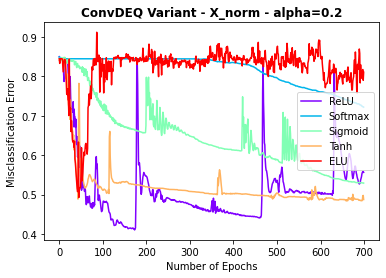

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('ConvDEQ Variant - X_norm - alpha=0.2', fontweight='bold')
plt.legend()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

error = {}
best_models = {}
activation_list = ['ReLU', 'Tanh', 'Sigmoid',  'ELU'] #'Softmax'

for act in activation_list:

  f = ConvDEQLayer_NO_X(d+l, d+l, d+l, d+l, A_scaled, act, alpha=0.2)
  model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=25, m=5),
                        nn.Linear(d+l, l),
                        nn.Softmax(dim=1)).to(device)

  opt = optim.Adam(model.parameters(), lr=1e-3)
  print("# Parmeters: ", sum(a.numel() for a in model.parameters()))

  max_epochs = 700
  scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

  total_error = []
  total_loss = []

  for i in range(max_epochs):
        ep = epoch(X_LS_norm, Y, model, opt, scheduler, lambda_reg=0)

        total_error.append(ep[1])
        total_loss.append(ep[2])
        if not i%10 or i==max_epochs-1:
            print(i, ep)
        
        if i == 0:
            best_error = (ep[1], i)
            best_model = deepcopy(model)
        elif best_error[0] > ep[1]:
            best_error = (ep[1], i)
            best_model = deepcopy(model)
            
    print(best_error)
    best_models[act] = best_model
    error[act] = total_error

# Parmeters:  5483010
0 (0.9269662921348315, 0.851685393258427, 2.1971874237060547)
1 (0.8146067415730337, 0.8418539325842697, 2.192326784133911)
2 (0.8258426966292135, 0.8421348314606741, 2.187211751937866)
3 (0.8314606741573034, 0.8421348314606741, 2.181567668914795)
4 (0.8314606741573034, 0.8421348314606741, 2.175098419189453)
5 (0.8314606741573034, 0.8421348314606741, 2.1674726009368896)
6 (0.8314606741573034, 0.8421348314606741, 2.158581495285034)
7 (0.8314606741573034, 0.8421348314606741, 2.149644136428833)
8 (0.8314606741573034, 0.8421348314606741, 2.145500898361206)
9 (0.8314606741573034, 0.8421348314606741, 2.140281915664673)
10 (0.8314606741573034, 0.8421348314606741, 2.131354808807373)
11 (0.8146067415730337, 0.8421348314606741, 2.12235951423645)
12 (0.7415730337078652, 0.8387640449438202, 2.1142044067382812)
13 (0.6741573033707865, 0.8112359550561797, 2.1055831909179688)
14 (0.6460674157303371, 0.7991573033707865, 2.095487356185913)
15 (0.6123595505617978, 0.799157303370786

KeyboardInterrupt: ignored

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('ConvDEQ_NO_X Variant - X_norm - alpha=0.2', fontweight='bold')
plt.legend()

### Tilde Graph DEQ  $ \longrightarrow Z = \sigma \left( \bar{A} Z W + \tilde{X} U + b \right) $

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

error = {}
activation_list = ['ReLU', 'Softmax', 'Sigmoid', 'Tanh', 'ELU']

for act in activation_list:

  f = ConvDEQLayer(d+l, d+l, d + l, l, A_scaled, act) # notice that w.r.t. the previous operation, we modified the dimenion of the U matrix.
  model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-7, max_iter=25, m=5)).to(device)

  opt = optim.Adam(model.parameters(), lr=1e-3)
  print("# Parmeters: ", sum(a.numel() for a in model.parameters()))

  max_epochs = 150
  scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*X_.shape[0], eta_min=1e-6)

  total_error = []
  total_loss = []

  for i in range(max_epochs):
      ep = epoch(X_, Y, model, opt, scheduler)
      total_error.append(ep[0])
      total_loss.append(ep[1])
      print(i, ep)
  error[act] = total_error

# Parmeters:  7905


RuntimeError: ignored

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('Error rate - 3% labelled', fontweight='bold')
plt.legend()

### Stacked Graph DEQ  $ \longrightarrow \tilde{Y} = softmax \left( Z^{\star} \Theta \right)$

In [ ]:
Y = torch.tensor(Y, dtype=torch.long)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(7)

error = {}
activation_list = ['ReLU']#, 'Sigmoid', 'Tanh', 'ELU'] # , 'Softmax',

for act in activation_list:

    f = ConvDEQLayer(d+l, d+l, d + l, d+l, A_scaled, act) # notice that w.r.t. the previous operation, we modified the dimenion of the U matrix.
    model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=25, m=5),
                            nn.Linear(d+l, l),
                            nn.Softmax()).to(device)

    opt = optim.Adam(model.parameters(), lr=1e-3)
    print("# Parmeters: ", sum(a.numel() for a in model.parameters()))

    max_epochs = 150
    scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*X_.shape[0], eta_min=1e-6)

    total_error = []
    total_loss = []

    for i in range(max_epochs):
        ep = epoch(X_, Y, model, opt, scheduler)
        total_error.append(ep[0])
        total_loss.append(ep[1])
        print(i, ep)
    error[act] = total_error

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


# Parmeters:  5364444


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([[6.9908e-04, 1.3257e-01, 1.2795e-06,  ..., 2.1817e-06, 1.5459e-02,
         1.6496e-02],
        [1.1281e-03, 1.3373e-01, 1.4796e-06,  ..., 3.1156e-06, 1.9001e-02,
         2.7570e-02],
        [4.4494e-04, 1.4755e-01, 1.1591e-06,  ..., 1.5039e-06, 1.3510e-02,
         1.0787e-02],
        ...,
        [1.4369e-03, 1.6067e-01, 1.0714e-06,  ..., 3.5350e-06, 1.2530e-02,
         6.1676e-02],
        [2.3949e-03, 1.2915e-01, 5.3661e-07,  ..., 4.0499e-06, 7.1216e-03,
         9.3888e-02],
        [1.3152e-03, 1.4732e-01, 1.4374e-06,  ..., 3.4527e-06, 1.8015e-02,
         4.2384e-02]], device='cuda:0', grad_fn=<SoftmaxBackward>)
0 (0.8924761370016845, 2.2250592708587646)
tensor([[1.4013e-45, 1.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.2009e-42,
         6.2909e-33],
        [1.0482e-41, 1.0000e+00, 1.4013e-43,  ..., 0.0000e+00, 7.3044e-39,
         2.3418e-30],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.4013e-45,
         3.7026e-35],
        ...,
        [1.99

KeyboardInterrupt: ignored

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('Error rate - 3% labelled', fontweight='bold')
plt.legend()

### Stacked DEQ BIS $\longrightarrow \tilde{Y} = softmax \left( Z^{\star} \Theta \right), Z = \sigma(\bar{A}ZW) + UX_0$

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(4)

error = {}
activation_list = ['ReLU', 'Tanh', 'ELU', 'Softmax', 'Sigmoid']

for act in activation_list:

  f = ConvDEQLayer_NO_X(d+l, d+l, d+l, d+l, A_scaled, act) # notice that w.r.t. the previous operation, we modified the dimenion of the U matrix.
  model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=50, m=5),
                        nn.Linear(d+l, 10),
                        nn.Softmax()).to(device)

  opt = optim.Adam(model.parameters(), lr=1e-3)
  print("# Parmeters: ", sum(a.numel() for a in model.parameters()))

  max_epochs = 200
  #scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*X.shape[0], eta_min=1e-6)
  #scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.9)

  total_error = []
  total_loss = []

  for i in range(max_epochs):
      ep = epoch(X_, Y, model, opt, scheduler)
      total_error.append(ep[0])
      total_loss.append(ep[1])
      print(i, ep)
  error[act] = total_error

# Parmeters:  5366080


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
0 (0.8834924199887704, 2.341555118560791)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
1 (0.8834924199887704, 2.341555118560791)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
2

KeyboardInterrupt: ignored

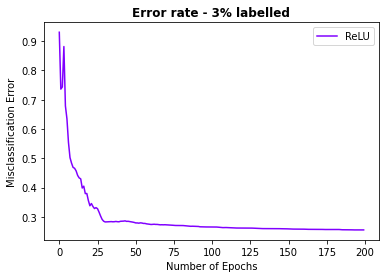

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('Error rate - 3% labelled', fontweight='bold')
plt.legend()

## Caltech 36 - Facebook100

In [ ]:
X, Y, A_scaled = facebook100_import('Caltech36.mat')

Non-Null adjacency matrix shape: (597, 597)
Connected adjacency matrix shape: (590, 590)
Connected Feature Matrix shape: (590, 7)
torch.Size([590, 513])


In [ ]:
n = X.shape[0]
d = X.shape[1]
l = len(Y.unique()) # number of labels
p = 0.05 # known labels proportion

# Let us select the known labels by random sampling p% elements of each label
known = []
for lab in Y.unique():
    known_lab = torch.where(Y == lab)[0].numpy()
    known.extend(np.random.choice(known_lab, size=int(np.floor(len(known_lab)*p)), replace=False))
print('Number of known labels: ', len(known))

unknown = np.ones(n, dtype=bool)
unknown[known] = False

Y_one_hot = pd.get_dummies(Y)

# Construct the X_ matrix containing not just features but also the labels of the known points.
X_ = torch.cat([torch.zeros(X.shape[0], l), X], axis=1)
X_[known, :l] = torch.tensor(Y_one_hot.iloc[known].values, dtype=torch.float32)

Number of known labels:  26


### Label Propagation

In [ ]:
Y_LP = linear_label_spreading(X_[:,:l], A_scaled, alpha=0.6)

print('Accuracy:', (torch.sum((torch.argmax(Y_LP[unknown], 1) - Y[unknown])==0)/ len(unknown)).item())

Accuracy: 0.6661016941070557


### Linear Label Spreading

In [ ]:
X_LS = linear_label_spreading(X_, A_scaled, alpha=0.6, tol=1e-5, max_iter=50)

X_LS_norm = X_LS / torch.max(X_LS, dim=1)[0].reshape(-1,1)

print('Accuracy:', (torch.sum((torch.argmax(X_LS[unknown,:l], 1) - Y[unknown])==0)/ len(unknown)).item())

Accuracy: 0.6610169410705566


In [ ]:
############## CROSS-VALIDATED LABEL SPREADING ######################

kfold = StratifiedKFold(n_splits=3)

n_random_sampling = 10
best_alphas = []
LS_accuracies = []

for j in np.arange(n_random_sampling):
    print('------------------------------------------------------------')
    print('-------------- Random sampling No. %d ----------------------' %(j+1))
    print('------------------------------------------------------------')
    
    accuracies_alpha = {} # Accuracies for different alpha for the same random sample

    # Let us select the known labels by random sampling p% elements of each label
    known = []
    for lab in Y.unique():
        known_lab = torch.where(Y == lab)[0].numpy()
        known.extend(np.random.choice(known_lab, size=int(np.floor(len(known_lab)*p)), replace=False))
    print('Number of known labels: ', len(known))

    unknown = np.ones(n, dtype=bool)
    unknown[known] = False

    for alpha in [0.1, 0.3, 0.5, 0.7, 0.9]:
        accuracy_folds = {}
        print('----------------------- Alpha=%.1f ----------------------' %(alpha))
        
        for fold, (train_ids, validation_ids) in enumerate(kfold.split(X_[known], Y[known])):
            train_ids = [known[j] for j in train_ids]
            validation_ids = [known[j] for j in validation_ids]
            X_zeros = torch.cat([torch.zeros(X.shape[0], l), X], axis=1)
            X_zeros[train_ids, :l] = torch.tensor(Y_one_hot.iloc[train_ids].values, dtype=torch.float32)
            X_LS = linear_label_spreading(X_zeros, A_scaled, alpha=alpha, tol=1e-5, max_iter=50)

            print('Fold %d - Validation Accuracy: %.3f' 
                %(fold, (torch.sum((torch.argmax(X_LS[validation_ids,:l], 1) - Y[validation_ids])==0)/ len(validation_ids)).item()))
            
            fold_pred = X_LS[validation_ids, :l].max(dim=1)[1]
            accuracy_folds[fold] = (fold_pred == Y[validation_ids].view(-1)).sum().item() / len(validation_ids)
        
        accuracies_alpha[alpha] = np.mean(list(accuracy_folds.values()))
        print('---------- Average Accuracy for Alpha=%.1f: %.3f ---------- \n' %(alpha, accuracies_alpha[alpha]))

    best_alpha = max(accuracies_alpha.keys(), key=(lambda x: accuracies_alpha[x]))
    best_alphas.append(best_alpha)
    print('---------------- Random Sampling No. %d - Best Alpha = %.1f ---------------- \n' %(j+1, best_alpha))

    # LABEL SPREADING EVALUATION FOR best_alpha FOR THE RANDOM SAMPLING
    X_LS = linear_label_spreading(X_, A_scaled, alpha=best_alpha)

    LS_accuracies.append((torch.sum((torch.argmax(X_LS[unknown,:l], 1) - Y[unknown])==0)/ len(unknown)).item())

best_alpha = max(best_alphas, key = best_alphas.count)
print('---------------- Overall Best Alpha = %.1f ---------------- \n' %(best_alpha))

print('-------------- Average LS Accuracy = %.4f -------------- \n' %(np.mean(LS_accuracies)))

# X_LS = linear_label_spreading(X_, A_scaled, alpha=best_alpha)
# X_LS_norm = X_LS / torch.max(X_LS, dim=1)[0].reshape(-1,1)

# print('Cross-Validated Linear Label Spreading Accuracy: %.4f' 
#       %(torch.sum((torch.argmax(X_LS[unknown,:l], 1) - Y[unknown])==0)/ len(unknown)).item())

------------------------------------------------------------
-------------- Random sampling No. 1 ----------------------
------------------------------------------------------------
Number of known labels:  26
----------------------- Alpha=0.1 ----------------------
Fold 0 - Validation Accuracy: 0.444


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 1 - Validation Accuracy: 0.667
Fold 2 - Validation Accuracy: 0.625
---------- Average Accuracy for Alpha=0.1: 0.579 ---------- 

----------------------- Alpha=0.3 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.444
Fold 1 - Validation Accuracy: 0.667
Fold 2 - Validation Accuracy: 0.750
---------- Average Accuracy for Alpha=0.3: 0.620 ---------- 

----------------------- Alpha=0.5 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.444
Fold 1 - Validation Accuracy: 0.667
Fold 2 - Validation Accuracy: 0.750
---------- Average Accuracy for Alpha=0.5: 0.620 ---------- 

----------------------- Alpha=0.7 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.333
Fold 1 - Validation Accuracy: 0.667
Fold 2 - Validation Accuracy: 0.625
---------- Average Accuracy for Alpha=0.7: 0.542 ---------- 

----------------------- Alpha=0.9 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.333
Fold 1 - Validation Accuracy: 0.667
Fold 2 - Validation Accuracy: 0.500
---------- Average Accuracy for Alpha=0.9: 0.500 ---------- 

---------------- Random Sampling No. 1 - Best Alpha = 0.3 ---------------- 

------------------------------------------------------------
-------------- Random sampling No. 2 ----------------------
------------------------------------------------------------
Number of known labels:  26
----------------------- Alpha=0.1 ----------------------
Fold 0 - Validation Accuracy: 0.556


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 1 - Validation Accuracy: 0.556
Fold 2 - Validation Accuracy: 0.750
---------- Average Accuracy for Alpha=0.1: 0.620 ---------- 

----------------------- Alpha=0.3 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.556
Fold 1 - Validation Accuracy: 0.667
Fold 2 - Validation Accuracy: 0.750
---------- Average Accuracy for Alpha=0.3: 0.657 ---------- 

----------------------- Alpha=0.5 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.556
Fold 1 - Validation Accuracy: 0.667
Fold 2 - Validation Accuracy: 0.750
---------- Average Accuracy for Alpha=0.5: 0.657 ---------- 

----------------------- Alpha=0.7 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.444
Fold 1 - Validation Accuracy: 0.778
Fold 2 - Validation Accuracy: 0.875
---------- Average Accuracy for Alpha=0.7: 0.699 ---------- 

----------------------- Alpha=0.9 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.333
Fold 1 - Validation Accuracy: 0.556
Fold 2 - Validation Accuracy: 0.750
---------- Average Accuracy for Alpha=0.9: 0.546 ---------- 

---------------- Random Sampling No. 2 - Best Alpha = 0.7 ---------------- 

------------------------------------------------------------
-------------- Random sampling No. 3 ----------------------
------------------------------------------------------------
Number of known labels:  26
----------------------- Alpha=0.1 ----------------------
Fold 0 - Validation Accuracy: 0.667


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 1 - Validation Accuracy: 0.444
Fold 2 - Validation Accuracy: 0.375
---------- Average Accuracy for Alpha=0.1: 0.495 ---------- 

----------------------- Alpha=0.3 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.667
Fold 1 - Validation Accuracy: 0.444
Fold 2 - Validation Accuracy: 0.500
---------- Average Accuracy for Alpha=0.3: 0.537 ---------- 

----------------------- Alpha=0.5 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.556
Fold 1 - Validation Accuracy: 0.444
Fold 2 - Validation Accuracy: 0.500
---------- Average Accuracy for Alpha=0.5: 0.500 ---------- 

----------------------- Alpha=0.7 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.556
Fold 1 - Validation Accuracy: 0.444
Fold 2 - Validation Accuracy: 0.500
---------- Average Accuracy for Alpha=0.7: 0.500 ---------- 

----------------------- Alpha=0.9 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.556
Fold 1 - Validation Accuracy: 0.556
Fold 2 - Validation Accuracy: 0.500
---------- Average Accuracy for Alpha=0.9: 0.537 ---------- 

---------------- Random Sampling No. 3 - Best Alpha = 0.3 ---------------- 

------------------------------------------------------------
-------------- Random sampling No. 4 ----------------------
------------------------------------------------------------
Number of known labels:  26
----------------------- Alpha=0.1 ----------------------
Fold 0 - Validation Accuracy: 0.778


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 1 - Validation Accuracy: 0.444
Fold 2 - Validation Accuracy: 0.625
---------- Average Accuracy for Alpha=0.1: 0.616 ---------- 

----------------------- Alpha=0.3 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.667
Fold 1 - Validation Accuracy: 0.444
Fold 2 - Validation Accuracy: 0.625
---------- Average Accuracy for Alpha=0.3: 0.579 ---------- 

----------------------- Alpha=0.5 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.667
Fold 1 - Validation Accuracy: 0.444
Fold 2 - Validation Accuracy: 0.625
---------- Average Accuracy for Alpha=0.5: 0.579 ---------- 

----------------------- Alpha=0.7 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.667
Fold 1 - Validation Accuracy: 0.333
Fold 2 - Validation Accuracy: 0.625
---------- Average Accuracy for Alpha=0.7: 0.542 ---------- 

----------------------- Alpha=0.9 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.556
Fold 1 - Validation Accuracy: 0.333
Fold 2 - Validation Accuracy: 0.625
---------- Average Accuracy for Alpha=0.9: 0.505 ---------- 

---------------- Random Sampling No. 4 - Best Alpha = 0.1 ---------------- 

------------------------------------------------------------
-------------- Random sampling No. 5 ----------------------
------------------------------------------------------------
Number of known labels:  26
----------------------- Alpha=0.1 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.667
Fold 1 - Validation Accuracy: 0.667
Fold 2 - Validation Accuracy: 0.750
---------- Average Accuracy for Alpha=0.1: 0.694 ---------- 

----------------------- Alpha=0.3 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.667
Fold 1 - Validation Accuracy: 0.778
Fold 2 - Validation Accuracy: 0.875
---------- Average Accuracy for Alpha=0.3: 0.773 ---------- 

----------------------- Alpha=0.5 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.667
Fold 1 - Validation Accuracy: 0.778
Fold 2 - Validation Accuracy: 0.875
---------- Average Accuracy for Alpha=0.5: 0.773 ---------- 

----------------------- Alpha=0.7 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.667
Fold 1 - Validation Accuracy: 0.889
Fold 2 - Validation Accuracy: 0.875
---------- Average Accuracy for Alpha=0.7: 0.810 ---------- 

----------------------- Alpha=0.9 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.556
Fold 1 - Validation Accuracy: 0.667
Fold 2 - Validation Accuracy: 0.625
---------- Average Accuracy for Alpha=0.9: 0.616 ---------- 

---------------- Random Sampling No. 5 - Best Alpha = 0.7 ---------------- 

------------------------------------------------------------
-------------- Random sampling No. 6 ----------------------
------------------------------------------------------------
Number of known labels:  26
----------------------- Alpha=0.1 ----------------------
Fold 0 - Validation Accuracy: 0.444


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 1 - Validation Accuracy: 0.444
Fold 2 - Validation Accuracy: 0.875
---------- Average Accuracy for Alpha=0.1: 0.588 ---------- 

----------------------- Alpha=0.3 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.444
Fold 1 - Validation Accuracy: 0.444
Fold 2 - Validation Accuracy: 0.750
---------- Average Accuracy for Alpha=0.3: 0.546 ---------- 

----------------------- Alpha=0.5 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.444
Fold 1 - Validation Accuracy: 0.444
Fold 2 - Validation Accuracy: 0.750
---------- Average Accuracy for Alpha=0.5: 0.546 ---------- 

----------------------- Alpha=0.7 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.444
Fold 1 - Validation Accuracy: 0.444
Fold 2 - Validation Accuracy: 0.750
---------- Average Accuracy for Alpha=0.7: 0.546 ---------- 

----------------------- Alpha=0.9 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.444
Fold 1 - Validation Accuracy: 0.222
Fold 2 - Validation Accuracy: 0.750
---------- Average Accuracy for Alpha=0.9: 0.472 ---------- 

---------------- Random Sampling No. 6 - Best Alpha = 0.1 ---------------- 

------------------------------------------------------------
-------------- Random sampling No. 7 ----------------------
------------------------------------------------------------
Number of known labels:  26
----------------------- Alpha=0.1 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.556
Fold 1 - Validation Accuracy: 0.556
Fold 2 - Validation Accuracy: 0.250
---------- Average Accuracy for Alpha=0.1: 0.454 ---------- 

----------------------- Alpha=0.3 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.556
Fold 1 - Validation Accuracy: 0.444
Fold 2 - Validation Accuracy: 0.250
---------- Average Accuracy for Alpha=0.3: 0.417 ---------- 

----------------------- Alpha=0.5 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.667
Fold 1 - Validation Accuracy: 0.444
Fold 2 - Validation Accuracy: 0.250
---------- Average Accuracy for Alpha=0.5: 0.454 ---------- 

----------------------- Alpha=0.7 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.556
Fold 1 - Validation Accuracy: 0.444
Fold 2 - Validation Accuracy: 0.250
---------- Average Accuracy for Alpha=0.7: 0.417 ---------- 

----------------------- Alpha=0.9 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.111
Fold 1 - Validation Accuracy: 0.222
Fold 2 - Validation Accuracy: 0.250
---------- Average Accuracy for Alpha=0.9: 0.194 ---------- 

---------------- Random Sampling No. 7 - Best Alpha = 0.1 ---------------- 

------------------------------------------------------------
-------------- Random sampling No. 8 ----------------------
------------------------------------------------------------
Number of known labels:  26
----------------------- Alpha=0.1 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.444
Fold 1 - Validation Accuracy: 0.667
Fold 2 - Validation Accuracy: 0.875
---------- Average Accuracy for Alpha=0.1: 0.662 ---------- 

----------------------- Alpha=0.3 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.444
Fold 1 - Validation Accuracy: 0.667
Fold 2 - Validation Accuracy: 0.875
---------- Average Accuracy for Alpha=0.3: 0.662 ---------- 

----------------------- Alpha=0.5 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.444
Fold 1 - Validation Accuracy: 0.667
Fold 2 - Validation Accuracy: 0.875
---------- Average Accuracy for Alpha=0.5: 0.662 ---------- 

----------------------- Alpha=0.7 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.444
Fold 1 - Validation Accuracy: 0.667
Fold 2 - Validation Accuracy: 0.875
---------- Average Accuracy for Alpha=0.7: 0.662 ---------- 

----------------------- Alpha=0.9 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.333
Fold 1 - Validation Accuracy: 0.556
Fold 2 - Validation Accuracy: 0.500
---------- Average Accuracy for Alpha=0.9: 0.463 ---------- 

---------------- Random Sampling No. 8 - Best Alpha = 0.1 ---------------- 

------------------------------------------------------------
-------------- Random sampling No. 9 ----------------------
------------------------------------------------------------
Number of known labels:  26
----------------------- Alpha=0.1 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.444
Fold 1 - Validation Accuracy: 0.667
Fold 2 - Validation Accuracy: 0.875
---------- Average Accuracy for Alpha=0.1: 0.662 ---------- 

----------------------- Alpha=0.3 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.444
Fold 1 - Validation Accuracy: 0.667
Fold 2 - Validation Accuracy: 0.875
---------- Average Accuracy for Alpha=0.3: 0.662 ---------- 

----------------------- Alpha=0.5 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.556
Fold 1 - Validation Accuracy: 0.667
Fold 2 - Validation Accuracy: 0.875
---------- Average Accuracy for Alpha=0.5: 0.699 ---------- 

----------------------- Alpha=0.7 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.667
Fold 1 - Validation Accuracy: 0.667
Fold 2 - Validation Accuracy: 0.875
---------- Average Accuracy for Alpha=0.7: 0.736 ---------- 

----------------------- Alpha=0.9 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.556
Fold 1 - Validation Accuracy: 0.556
Fold 2 - Validation Accuracy: 0.875
---------- Average Accuracy for Alpha=0.9: 0.662 ---------- 

---------------- Random Sampling No. 9 - Best Alpha = 0.7 ---------------- 

------------------------------------------------------------
-------------- Random sampling No. 10 ----------------------
------------------------------------------------------------
Number of known labels:  26
----------------------- Alpha=0.1 ----------------------
Fold 0 - Validation Accuracy: 0.333


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 1 - Validation Accuracy: 0.778
Fold 2 - Validation Accuracy: 0.500
---------- Average Accuracy for Alpha=0.1: 0.537 ---------- 

----------------------- Alpha=0.3 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.333
Fold 1 - Validation Accuracy: 0.778
Fold 2 - Validation Accuracy: 0.500
---------- Average Accuracy for Alpha=0.3: 0.537 ---------- 

----------------------- Alpha=0.5 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.333
Fold 1 - Validation Accuracy: 0.778
Fold 2 - Validation Accuracy: 0.500
---------- Average Accuracy for Alpha=0.5: 0.537 ---------- 

----------------------- Alpha=0.7 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.333
Fold 1 - Validation Accuracy: 0.778
Fold 2 - Validation Accuracy: 0.500
---------- Average Accuracy for Alpha=0.7: 0.537 ---------- 

----------------------- Alpha=0.9 ----------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 - Validation Accuracy: 0.222
Fold 1 - Validation Accuracy: 0.556
Fold 2 - Validation Accuracy: 0.500
---------- Average Accuracy for Alpha=0.9: 0.426 ---------- 

---------------- Random Sampling No. 10 - Best Alpha = 0.1 ---------------- 

---------------- Overall Best Alpha = 0.1 ---------------- 

---------------- Average LS Accuracy = 0.7012 -------------- 



In [ ]:
X_LS_norm_lab = X_LS[:, :l] / torch.max(X_LS[:, :l], dim=1).values.reshape(-1,1)
X_LS_norm_feat = X_LS[:, l:] / torch.max(X_LS[:, l:], dim=1).values.reshape(-1,1)


#### LOGISTIC REGRESSION WITH JUST LABELS ####

from sklearn.linear_model import LogisticRegression

lr_norm_lab = LogisticRegression(C=1000) # Essential to remove some regularization
lr_norm_lab.fit(X_LS_norm_lab[known], Y[known])

unknown = np.ones(n, dtype=bool)
unknown[known] = False

Y_pred = torch.tensor(lr_norm_lab.predict(X_LS_norm_lab[unknown, :l]), dtype=torch.long)
print('Accuracy LR on X_LS_norm_lab:', torch.sum((Y_pred - Y[unknown]) == 0) / Y[unknown].shape[0])

Accuracy LR on X_LS_norm_lab: tensor(0.5704)


In [ ]:
# LOGISTIC REGRESSION ONLY WITH X_LS_NORM FEATURES

lr_norm_feat = LogisticRegression(C=100, max_iter=250)
lr_norm_feat.fit(X_LS_norm_feat[known], Y[known])

Y_pred = torch.tensor(lr_norm_feat.predict(X_LS_norm_feat[unknown]), dtype=torch.long)
print(torch.sum((Y_pred - Y[unknown]) == 0) / Y[unknown].shape[0])

tensor(0.1676)


In [ ]:
# LOGISTIC REGRESSION WITH JUST LABELS AND FEATURES NORMALIZED SEPARATELY

X_NORM = torch.cat([X_LS_norm_lab, X_LS_norm_feat], dim=1)

lr_NORM = LogisticRegression(C=100) # this time some regularization helps
lr_NORM.fit(X_NORM[known], Y[known])

Y_pred = torch.tensor(lr_NORM.predict(X_NORM[unknown]), dtype=torch.long)
print('Accuracy LR on X_NORM:', torch.sum((Y_pred - Y[unknown]) == 0) / Y[unknown].shape[0])

Accuracy LR on X_NORM: tensor(0.5455)


### FULLY CROSS-VALIDATED MODEL

In [ ]:
####### FULLY CROSS VALIDATED MODEL ##########

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

n_rand_sampling = 10 # No. of different random samplings we will consider

activation_list = ['ReLU', 'Tanh']

LS_accuracies = []
errors = {}
best_models = {}
total_errors = {}

for j in np.arange(n_rand_sampling):
    # We define a kfold with a random_state so that we can use the same split for
    # cross-validating both Label Spreading and the neural network.
    kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=rand.randint(0,10000))

    # Extraction of the known and unknown labels
    known = []
    for lab in Y.unique():
        known_lab = torch.where(Y == lab)[0].numpy()
        known.extend(np.random.choice(known_lab, size=int(np.floor(len(known_lab)*p)), replace=False))

    unknown = np.ones(n, dtype=bool)
    unknown[known] = False
    
    print('-------------------------------------------------------------------------')
    print('\t \t Random Sampling No. %d' %(j+1))
    print('-------------------------------------------------------------------------\n')
    print('Number of known labels: %d \n' %(len(known)))
    
    
    ############# LABEL SPREADING CROSS-VALIDATION #############

    print('############# LABEL SPREADING CROSS-VALIDATION #############')
    accuracies_alpha = {}

    for alpha in [0.1, 0.3, 0.5, 0.7, 0.9]:
        accuracy_folds = {}
        print('----------------------- Alpha=%.1f ----------------------' %(alpha))
        
        for fold, (train_ids, validation_ids) in enumerate(kfold.split(X_[known], Y[known])):
            train_ids = [known[j] for j in train_ids]
            validation_ids = [known[j] for j in validation_ids]
            
            X_zeros = torch.cat([torch.zeros(X.shape[0], l), X], axis=1)
            X_zeros[train_ids, :l] = torch.tensor(Y_one_hot.iloc[train_ids].values, dtype=torch.float32)
            X_LS = linear_label_spreading(X_zeros, A_scaled, alpha=alpha, tol=1e-5, max_iter=50)

            fold_pred = X_LS[validation_ids, :l].max(dim=1)[1]
            fold_accuracy = (fold_pred == Y[validation_ids].view(-1)).sum().item() / len(validation_ids)
            accuracy_folds[fold] = fold_accuracy

            # print('Fold %d - Validation Accuracy: %.3f' %(fold, fold_accuracy))
        
        accuracies_alpha[alpha] = np.mean(list(accuracy_folds.values()))
        print('---- Average Validation Accuracy for Alpha=%.1f: %.3f ---- \n' %(alpha, accuracies_alpha[alpha]))

    best_alpha = max(accuracies_alpha.keys(), key=(lambda x: accuracies_alpha[x]))
    # best_alphas.append(best_alpha)
    print('---------- Label Spreading - Best Alpha = %.1f ---------- \n' %(best_alpha))
    

    # LABEL SPREADING EVALUATION FOR best_alpha FOR THE RANDOM SAMPLING
    X_LS = linear_label_spreading(X_, A_scaled, alpha=best_alpha)

    X_LS_norm = X_LS / torch.max(X_LS, dim=1).values.reshape(-1,1)
    LS_accuracy = (torch.sum((torch.argmax(X_LS[unknown,:l], 1) - Y[unknown])==0)/ len(unknown)).item()
    LS_accuracies.append(LS_accuracy)

    print('---------- Label Spreading - Accuracy = %.3f ---------- \n' %(LS_accuracy))

    accuracies_beta = {}

    print('############# NEURAL NETWORK CROSS-VALIDATION #############')
    

    for act in activation_list:

        for beta in [0.1, 0.2, 0.3, 0.5]:
            accuracy_folds = {}
            print('----------------------- Beta=%.1f ----------------------' %(beta))
            
            for fold, (train_ids, validation_ids) in enumerate(kfold.split(X_[known], Y[known])):

                train_ids = [known[j] for j in train_ids]
                validation_ids = [known[j] for j in validation_ids]

                f = ConvDEQLayer_NO_X(d+l, d+l, d+l, d+l, A_scaled, act, beta=beta)
                model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=50, m=5),
                                            nn.Linear(d+l, l),
                                            nn.Softmax(dim=1)
                                            ).to(device)

                opt = optim.Adam(model.parameters(), lr=1e-3)

                max_epochs = 150
                scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

                for i in np.arange(max_epochs):
                    ep = epoch_fold(X_LS_norm, Y, model, opt, scheduler, lambda_reg=0)

                    if not i%25 or i==max_epochs-1:
                        print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                              %(i, ep[0], ep[1], ep[2], ep[3]))
                    
                    if i == 0:
                        best_error = (ep[2], i)
                        best_model = deepcopy(model)
                    elif best_error[0] > ep[2]:
                        best_error = (ep[2], i)
                        best_model = deepcopy(model)

                # print('\t Fold %d - Best Error : %.3f - Reached at epoch %d' %(fold, best_error[0], best_error[1]))
                fold_pred = best_model(X_LS_norm.to(device))[validation_ids].max(dim=1)[1].detach().cpu()
                accuracy_folds[fold] = (fold_pred == Y[validation_ids].view(-1)).sum().item() / len(validation_ids)
            
            accuracies_beta[beta] = np.mean(list(accuracy_folds.values()))
            print('---- Average Validation Accuracy for Beta=%.1f: %.3f ---- \n' %(beta, accuracies_beta[beta]))

        best_beta = max(accuracies_beta.keys(), key=(lambda x: accuracies_beta[x]))
        print('--------------------- Best Beta=%.1f -------------------- \n' %(best_beta))
        print('--------------------- Model Training -------------------- \n')

        f = ConvDEQLayer_NO_X(d+l, d+l, d+l, d+l, A_scaled, act, beta=best_beta)
        model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=50, m=5),
                                        nn.Linear(d+l, l),
                                        nn.Softmax(dim=1)
                                        ).to(device)

        opt = optim.Adam(model.parameters(), lr=1e-3)

        print("Model Parmeters: %d " %(sum(a.numel() for a in model.parameters())))

        max_epochs = 1000
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        train_error = []
        train_loss = []
        test_error = []
        test_loss = []

        for i in range(max_epochs):
            ep = epoch(X_LS_norm, Y, model, opt, scheduler, lambda_reg=0)

            train_error.append(ep[0])
            train_loss.append(ep[1])
            test_error.append(ep[2])
            test_loss.append(ep[3])

            if not i%10 or i==max_epochs-1:
                print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                        %(i, ep[0], ep[1], ep[2], ep[3]))
            
            if i == 0:
                best_error = (ep[2], i)
                best_model = deepcopy(model)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)
                best_model = deepcopy(model)

        print('---------- Activation=%s - Best Error=%.5f ---------- \n' %(act, best_error[0]))

        act_ = act + '_' + str(j)
        best_models[act_] = best_model
        errors[act_] = best_error[0]
        total_errors[act_] = test_error


-------------------------------------------------------------------------
	 	 Random Sampling No. 1
-------------------------------------------------------------------------

Number of known labels: 26 

############# LABEL SPREADING CROSS-VALIDATION #############
----------------------- Alpha=0.1 ----------------------
---- Average Validation Accuracy for Alpha=0.1: 0.423 ---- 

----------------------- Alpha=0.3 ----------------------
---- Average Validation Accuracy for Alpha=0.3: 0.462 ---- 

----------------------- Alpha=0.5 ----------------------
---- Average Validation Accuracy for Alpha=0.5: 0.462 ---- 

----------------------- Alpha=0.7 ----------------------
---- Average Validation Accuracy for Alpha=0.7: 0.500 ---- 

----------------------- Alpha=0.9 ----------------------
---- Average Validation Accuracy for Alpha=0.9: 0.462 ---- 

---------- Label Spreading - Best Alpha = 0.7 ---------- 

---------- Label Spreading - Accuracy = 0.636 ---------- 

############# NEURAL NETWOR

In [ ]:
np.mean(LS_accuracies)

0.6381356120109558

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

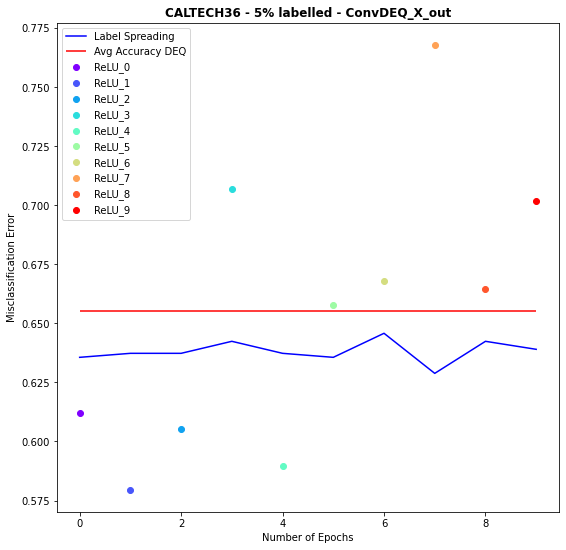

In [ ]:
plt.rcParams["figure.figsize"] = (9,9)
color=iter(plt.cm.rainbow(np.linspace(0,1,10)))
plt.plot(LS_accuracies, label="Label Spreading", c='b')
plt.hlines(0.65525, xmin=0, xmax=9, label='Avg Accuracy DEQ', colors='r') 
for i in np.arange(10):
    c=next(color)
    act = 'ReLU' + '_' + str(i)
    plt.scatter(i, 1 - errors[act], c=c, label=act)
 
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('CALTECH36 - 5% labelled - ConvDEQ_X_out', fontweight='bold')
plt.legend()
plt.show()

### Predict and Propagate Variants

In [ ]:
# ALTERNATIVE TRAINING OF THE NET WITH BOTH FEATURES AND LABELS

# SOFTMAX ON TOP OF LS_NORM WITH LABELS AND FEATURES NORMALIZED SEPARATELY
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

error = {}
best_models = {}
activation_list = ['ReLU']#, 'Sigmoid']#, 'Tanh', 'ELU']#, 'Softmax', ]

for act in activation_list:

    f = ConvDEQLayer_NO_X(d+l, d+l, d+l, d+l, A_scaled, act, alpha=0.2)
    model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=50, m=5),
                                nn.Linear(d+l, l),
                                nn.Softmax(dim=1)
                                ).to(device)

    opt = optim.Adam(model.parameters(), lr=1e-3)

    print("# Parmeters: ", sum(a.numel() for a in model.parameters()))

    max_epochs = 800
    scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

    total_error = []
    total_loss = []

    for i in range(max_epochs):
        ep = epoch(X_LS_norm, Y, model, opt, scheduler, lambda_reg=0)

        total_error.append(ep[1])
        total_loss.append(ep[2])
        if not i%10 or i==max_epochs-1:
            print(i, ep)
        
        if i == 0:
            best_error = (ep[1], i)
            best_model = deepcopy(model)
        elif best_error[0] > ep[1]:
            best_error = (ep[1], i)
            best_model = deepcopy(model)

    print(best_error)
    best_models[act] = best_model
    error[act] = total_error

# Parmeters:  548100
0 (0.9230769230769231, 0.8936170212765957, 2.0795083045959473)
10 (0.6538461538461539, 0.7943262411347518, 2.045549154281616)
20 (0.5, 0.7393617021276596, 1.9817185401916504)
30 (0.38461538461538464, 0.6631205673758865, 1.8700238466262817)
40 (0.15384615384615385, 0.5886524822695035, 1.6776846647262573)
50 (0.07692307692307693, 0.5283687943262412, 1.5043562650680542)
60 (0.07692307692307693, 0.46631205673758863, 1.4033697843551636)
70 (0.0, 0.4237588652482269, 1.3493834733963013)
80 (0.0, 0.4166666666666667, 1.3105595111846924)
90 (0.0, 0.4095744680851064, 1.2925658226013184)
100 (0.0, 0.39361702127659576, 1.2847931385040283)
110 (0.0, 0.3882978723404255, 1.2814034223556519)
120 (0.0, 0.39184397163120566, 1.2795344591140747)
130 (0.0, 0.3882978723404255, 1.2783374786376953)
140 (0.0, 0.38652482269503546, 1.2778319120407104)
150 (0.0, 0.38475177304964536, 1.2772791385650635)
160 (0.0, 0.37943262411347517, 1.2767634391784668)
170 (0.0, 0.37943262411347517, 1.27644741

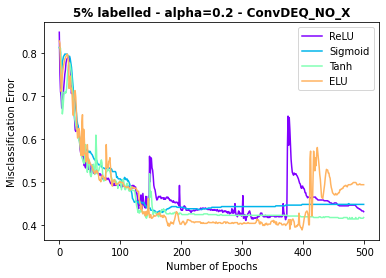

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('5% labelled - alpha=0.2 - ConvDEQ_NO_X', fontweight='bold')
plt.legend()

In [ ]:
# ALTERNATIVE TRAINING OF THE NET WITH BOTH FEATURES AND LABELS

# SOFTMAX ON TOP OF LS_NORM WITH LABELS AND FEATURES NORMALIZED SEPARATELY
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

error = {}
best_models = {}
activation_list = ['ReLU', 'Tanh', 'ELU']#, 'Softmax'], 'Sigmoid',

for act in activation_list:

    f = ConvDEQLayer(d+l, d+l, d+l, d+l, A_scaled, act, alpha=0.2)
    model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=50, m=5),
                                nn.Linear(d+l, l),
                                nn.Softmax(dim=1)
                                ).to(device)

    opt = optim.Adam(model.parameters(), lr=1e-3)

    print("# Parmeters: ", sum(a.numel() for a in model.parameters()))

    max_epochs = 500
    scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*X.shape[0], eta_min=1e-6)

    total_error = []
    total_loss = []

    for i in range(max_epochs):
        ep = epoch(X_LS_norm, Y, model, opt, scheduler, lambda_reg=0)

        total_error.append(ep[1])
        total_loss.append(ep[2])
        if not i%10 or i==max_epochs-1:
            print(i, ep)
        
        if i == 0:
            best_error = (ep[1], i)
            best_model = deepcopy(model)
        elif best_error[0] > ep[1]:
            best_error = (ep[1], i)
            best_model = deepcopy(model)
            
    print(best_error)
    best_models[act] = best_model
    error[act] = total_error

# Parmeters:  548100
0 (0.8461538461538461, 0.8546099290780141, 2.079756736755371)
10 (0.5384615384615384, 0.8031914893617021, 2.050999164581299)
20 (0.6153846153846154, 0.8351063829787234, 1.98633873462677)
30 (0.4230769230769231, 0.675531914893617, 1.8593192100524902)
40 (0.07692307692307693, 0.6560283687943262, 1.6551754474639893)
50 (0.038461538461538464, 0.5035460992907801, 1.5033785104751587)
60 (0.038461538461538464, 0.49822695035460995, 1.3846583366394043)
70 (0.0, 0.4698581560283688, 1.3288923501968384)
80 (0.0, 0.450354609929078, 1.305923581123352)
90 (0.0, 0.44858156028368795, 1.2902024984359741)
100 (0.0, 0.4326241134751773, 1.2841535806655884)
110 (0.0, 0.4219858156028369, 1.2811652421951294)
120 (0.0, 0.4308510638297872, 1.2794824838638306)
130 (0.0, 0.4219858156028369, 1.2784239053726196)
140 (0.0, 0.41312056737588654, 1.2776954174041748)
150 (0.0, 0.41134751773049644, 1.2771581411361694)
160 (0.0, 0.4095744680851064, 1.276737093925476)
170 (0.0, 0.4078014184397163, 1.27

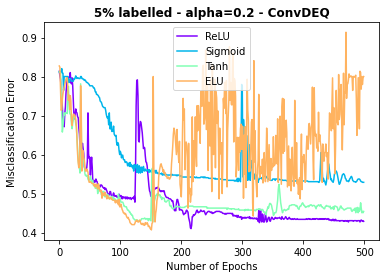

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('5% labelled - alpha=0.2 - ConvDEQ', fontweight='bold')
plt.legend()

### KIPF & WELLING $\longrightarrow f(X, A) = \text{softmax}\left(A \text{ ReLU} (A X W_1) W_2 \right)$



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

error = {}
activation_list = ['ReLU', 'Sigmoid', 'Tanh', 'ELU']#, 'Softmax', ]

for act in activation_list:

    model_KIPF = nn.Sequential(nn.Linear(d, d),
                               nn.ReLU(),
                               nn.Linear(d, d),
                               nn.Softmax()).to(device)

    AZ = torch.tensor(A_scaled.toarray(), dtype=torch.float32, device=device) @ (X / torch.max(X, 1)[0].reshape(-1,1)).to(device)                               

    opt = optim.Adam(model_KIPF.parameters(), lr=1e-3)

    print("# Parmeters: ", sum(a.numel() for a in model_KIPF.parameters()))

    max_epochs = 2000
    scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

    total_error = []
    total_loss = []

    for i in range(max_epochs):
        ep = epoch(AZ, Y, model_KIPF, opt, scheduler)
        total_error.append(ep[1])
        total_loss.append(ep[2])
        if not i%100 or i==max_epochs-1:
            print(i, ep)
    error[act] = total_error

# Parmeters:  527364
0 (1.0, 0.9508474576271186, 6.240288734436035)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


100 (0.20689655172413793, 0.5220338983050847, 5.569395065307617)
200 (0.20689655172413793, 0.5084745762711864, 5.454700469970703)
300 (0.13793103448275862, 0.5050847457627119, 5.390230178833008)
400 (0.10344827586206896, 0.4915254237288136, 5.348798751831055)
500 (0.10344827586206896, 0.48983050847457626, 5.347731113433838)
600 (0.034482758620689655, 0.42203389830508475, 5.28020715713501)
700 (0.034482758620689655, 0.4135593220338983, 5.2788848876953125)
800 (0.034482758620689655, 0.40847457627118644, 5.278552532196045)
900 (0.034482758620689655, 0.4101694915254237, 5.278402805328369)
1000 (0.034482758620689655, 0.4101694915254237, 5.278318881988525)
1100 (0.034482758620689655, 0.40847457627118644, 5.278265953063965)
1200 (0.034482758620689655, 0.411864406779661, 5.278229713439941)
1300 (0.034482758620689655, 0.411864406779661, 5.278202533721924)
1400 (0.034482758620689655, 0.411864406779661, 5.278182506561279)
1500 (0.034482758620689655, 0.4101694915254237, 5.278165817260742)
1600 (0.

### Stacked Graph DEQ  $ \longrightarrow \tilde{Y} = softmax \left( Z^{\star} \Theta \right)$

In [ ]:
Y = torch.tensor(Y, dtype=torch.long)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

error = {}
activation_list = ['ReLU']#,'Sigmoid', 'Tanh', 'ELU'] # , 'Softmax',

for act in activation_list:

  f = ConvDEQLayer(d+l, d+l, d+l, d+l, A_scaled, act)
  model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=50, m=5),
                        nn.Linear(d+l, l),
                        nn.Softmax()).to(device)

  opt = optim.Adam(model.parameters(), lr=1e-3)
  print("# Parmeters: ", sum(a.numel() for a in model.parameters()))

  max_epochs = 500
  scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*X_.shape[0], eta_min=1e-6)

  total_error = []
  total_loss = []

  for i in range(max_epochs):
      ep = epoch(X_, Y, model, opt, scheduler)
      total_error.append(ep[0])
      total_loss.append(ep[1])
      print(i, ep)
  error[act] = total_error

# Parmeters:  556508


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 (0.831081081081081, 2.079136848449707)
1 (0.8344594594594594, 2.076291084289551)
2 (0.7804054054054054, 2.0733084678649902)
3 (0.7516891891891891, 2.0695042610168457)
4 (0.7550675675675675, 2.062875986099243)
5 (0.8327702702702703, 2.05295991897583)
6 (0.7989864864864865, 2.0506818294525146)
7 (0.8175675675675675, 2.0496134757995605)
8 (0.8327702702702703, 2.0454459190368652)
9 (0.8429054054054054, 2.0408105850219727)
10 (0.839527027027027, 2.035433292388916)
11 (0.6942567567567568, 2.029634475708008)
12 (0.7195945945945946, 2.0248358249664307)
13 (0.7888513513513513, 2.0202817916870117)
14 (0.6655405405405406, 2.012566089630127)
15 (0.706081081081081, 2.0066471099853516)
16 (0.7584459459459459, 2.00030255317688)
17 (0.6925675675675675, 1.9908795356750488)
18 (0.6587837837837838, 1.9819793701171875)
19 (0.6570945945945946, 1.9726779460906982)
20 (0.6131756756756757, 1.9597986936569214)
21 (0.6858108108108109, 1.949952244758606)
22 (0.6351351351351351, 1.9417645931243896)
23 (0.621621

KeyboardInterrupt: ignored

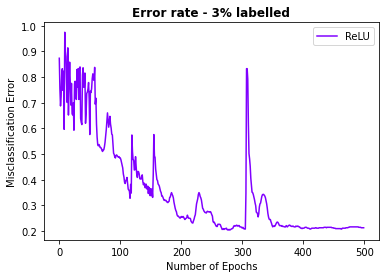

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('Error rate - 5% labelled', fontweight='bold')
plt.legend()

### Stacked DEQ BIS $\longrightarrow \tilde{Y} = softmax \left( Z^{\star} \Theta \right), Z = \sigma(\bar{A}ZW) + UX_0$

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

error = {}
activation_list = ['ReLU']#, 'Tanh', 'ELU', 'Softmax', 'Sigmoid']

for act in activation_list:

  f = ConvDEQLayer_NO_X(d+l, d+l, d+l, d+l, A_scaled, act) # notice that w.r.t. the previous operation, we modified the dimenion of the U matrix.
  model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-7, max_iter=50, m=5),
                        nn.Linear(d+l, l),
                        nn.Softmax()).to(device)

  opt = optim.Adam(model.parameters(), lr=1e-3)
  print("# Parmeters: ", sum(a.numel() for a in model.parameters()))

  max_epochs = 200
  scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*X.shape[0], eta_min=1e-6)
#   scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.9)

  total_error = []
  total_loss = []

  for i in range(max_epochs):
      ep = epoch(X_, Y, model, opt, scheduler)
      total_error.append(ep[0])
      total_loss.append(ep[1])
      print(i, ep)
  error[act] = total_error

# Parmeters:  556508
0 (0.831081081081081, 2.078165292739868)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


1 (0.8243243243243243, 2.069843053817749)
2 (0.8226351351351351, 2.0611624717712402)
3 (0.8243243243243243, 2.0516610145568848)
4 (0.8260135135135135, 2.040309429168701)
5 (0.831081081081081, 2.025752305984497)
6 (0.8293918918918919, 2.0058603286743164)
7 (0.8361486486486487, 1.9863530397415161)
8 (0.831081081081081, 1.9801048040390015)
9 (0.8716216216216216, 1.9673470258712769)
10 (0.8547297297297297, 1.9524781703948975)
11 (0.8429054054054054, 1.9433101415634155)
12 (0.8175675675675675, 1.9322433471679688)
13 (0.8006756756756757, 1.9185423851013184)
14 (0.8023648648648649, 1.9029282331466675)
15 (0.8040540540540541, 1.8863168954849243)
16 (0.7972972972972973, 1.8698599338531494)
17 (0.7989864864864865, 1.8530675172805786)
18 (0.8040540540540541, 1.8343392610549927)
19 (0.7922297297297297, 1.814626932144165)
20 (0.7922297297297297, 1.7949576377868652)
21 (0.793918918918919, 1.7761839628219604)
22 (0.7787162162162162, 1.7562768459320068)
23 (0.7668918918918919, 1.7361838817596436)
24 (

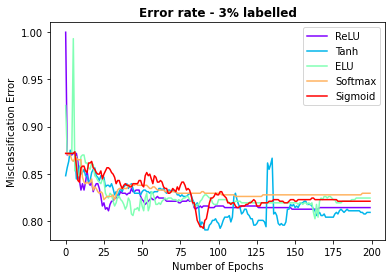

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('Error rate - 3% labelled', fontweight='bold')
plt.legend()

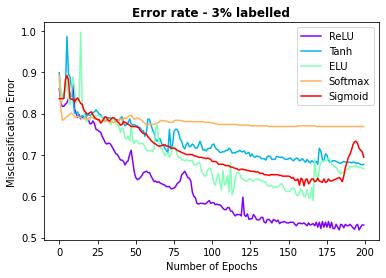

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('Error rate - 3% labelled', fontweight='bold')
plt.legend()

## Cora


In [ ]:
X, Y, A_scaled, A = cora_import()

n = X.shape[0]
d = X.shape[1]
l = len(Y.unique()) # number of labels
p = 0.05 # known labels proportion

Number of nodes Max Connected Component:  2485
Connected adjacency matrix shape: (2485, 2485)
Connected Feature Matrix shape: (2485, 1433)


### Fully Cross-Validated Model

In [ ]:
######### FULLY CROSS-VALIDATED MODEL ##########

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_rand_sampling = 5 # No. of different random samplings we will consider

activation_list = ['ReLU'] #'Tanh'

LS_accuracies = []
errors = {}
best_models = {}
total_errors = {}
errors_KIPF = {}
errors_KIPF_1000 = {}

for j in np.arange(n_rand_sampling):
    # We define a kfold with a random_state so that we can use the same split for
    # cross-validating both Label Spreading and the neural network.
    kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=rand.randint(0,10000))

    # Extraction of the known and unknown labels
    known = []
    for lab in Y.unique():
        known_lab = torch.where(Y == lab)[0].numpy()
        known.extend(np.random.choice(known_lab, size=int(np.floor(len(known_lab)*p)), replace=False))
        known = sorted(known)

    unknown = np.ones(n, dtype=bool)
    unknown[known] = False
    
    X_ = torch.cat([torch.zeros(X.shape[0], l), X], axis=1)
    X_[known, :l] = F.one_hot(Y[known]).type(torch.float)

    print('-------------------------------------------------------------------------')
    print('\t \t Random Sampling No. %d' %(j+1))
    print('-------------------------------------------------------------------------\n')
    print('Number of known labels: %d \n' %(len(known)))
    
    
    # ############# LABEL SPREADING CROSS-VALIDATION #############

    # print('############# LABEL SPREADING CROSS-VALIDATION #############')
    # accuracies_alpha = {}

    # for alpha in [0.1, 0.3, 0.5, 0.7, 0.9]:
    #     accuracy_folds = {}
    #     print('----------------------- Alpha=%.1f ----------------------' %(alpha))
        
    #     for fold, (train_ids, validation_ids) in enumerate(kfold.split(X_[known], Y[known])):
    #         train_ids = [known[j] for j in train_ids]
    #         validation_ids = [known[j] for j in validation_ids]
            
    #         X_zeros = torch.cat([torch.zeros(X.shape[0], l), X], axis=1)
    #         X_zeros[train_ids, :l] = F.one_hot(Y[train_ids]).type(torch.float)
    #         X_LS = linear_label_spreading(X_zeros, A_scaled, alpha=alpha, tol=1e-5, max_iter=50)

    #         fold_pred = X_LS[validation_ids, :l].max(dim=1)[1]
    #         fold_accuracy = (fold_pred == Y[validation_ids].view(-1)).sum().item() / float(len(validation_ids))
    #         accuracy_folds[fold] = fold_accuracy

    #         # print('Fold %d - Validation Accuracy: %.3f' %(fold, fold_accuracy))
        
    #     accuracies_alpha[alpha] = np.mean(list(accuracy_folds.values()))
    #     print('---- Average Validation Accuracy for Alpha=%.1f: %.3f ---- \n' %(alpha, accuracies_alpha[alpha]))

    # best_alpha = max(accuracies_alpha.keys(), key=(lambda x: accuracies_alpha[x]))
    # # best_alphas.append(best_alpha)
    # print('---------- Label Spreading - Best Alpha = %.1f ---------- \n' %(best_alpha))
    

    # # LABEL SPREADING EVALUATION FOR best_alpha FOR THE RANDOM SAMPLING
    # X_LS = linear_label_spreading(X_, A_scaled, alpha=best_alpha)

    # X_LS_norm = X_LS[:, l:] / torch.max(X_LS[:, l:], dim=1).values.reshape(-1,1)
    # LS_accuracy = torch.sum((torch.argmax(X_LS[unknown,:l], 1) - Y[unknown])==0).item()/ float(len(unknown))
    # LS_accuracies.append(LS_accuracy)

    # print('---------- Label Spreading - Accuracy = %.3f ---------- \n' %(LS_accuracy))

    accuracies_beta = {}

    print('############# NEURAL NETWORK CROSS-VALIDATION #############')
    

    for act in activation_list:

        f = ConvGEQLayer(d, d, d, d, A_scaled, act)
        model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=50, m=5),
                                        nn.Linear(d, l),
                                        nn.Softmax(dim=1)
                                        ).to(device)

        opt = optim.Adam(model.parameters(), lr=1e-3)

        print("Model Parmeters: %d " %(sum(a.numel() for a in model.parameters())))

        max_epochs = 200
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        train_error = []
        train_loss = []
        test_error = []
        test_loss = []

        for i in range(max_epochs):
            ep = epoch(X_[:,l:], Y, model, opt, scheduler, lambda_reg=0)

            train_error.append(ep[0])
            train_loss.append(ep[1])
            test_error.append(ep[2])
            test_loss.append(ep[3])

            if not i%10 or i==max_epochs-1:
                print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                        %(i, ep[0], ep[1], ep[2], ep[3]))
            
            if i == 0:
                best_error = (ep[2], i)
                best_model = deepcopy(model)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)
                best_model = deepcopy(model)

        print('------- Activation=%s - Best Error=%.5f (ep. %d) ------- \n' %(act, best_error[0], best_error[1]))

        act_ = act + '_' + str(j)
        best_models[act_] = best_model
        errors[act_] = best_error[0]
        total_errors[act_] = test_error

    print('------------------ Kipf and Welling Training ----------------- \n')        

    model_KIPF = KipfWelling(d, A_scaled).to(device)

    X_norm = (X / torch.max(X, 1)[0].reshape(-1,1)).to(device) 

    opt = optim.Adam(model_KIPF.parameters(), lr=1e-3)

    print("Parmeters: ", sum(a.numel() for a in model_KIPF.parameters()))

    max_epochs = 1000
    scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

    for i in range(max_epochs):
        ep = epoch(X_norm, Y, model_KIPF, opt, scheduler, lambda_reg=0)

        if not i%200 or i==max_epochs-1:
            print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                  %(i, ep[0], ep[1], ep[2], ep[3]))
            
        if i == 0:
            best_error_KIPF = (ep[2], i)
            best_error_KIPF_1000 = (ep[2], i)
            best_model_KIPF = deepcopy(model_KIPF)
        elif best_error_KIPF[0] > ep[2]:
                if i < 1000:
                    best_error_KIPF = (ep[2], i)
                    best_error_KIPF_1000 = (ep[2], i)
                    best_model_KIPF = deepcopy(model_KIPF)
                else:
                    best_error_KIPF = (ep[2], i)
                    best_model_KIPF = deepcopy(model_KIPF)

    print('-------- Best Error=%.5f reached at Ep. %d -------- \n' %(best_error_KIPF[0], best_error_KIPF[1]))
    print('---- Best Error after 1000 Ep.=%.5f (at Ep. %d) ---- \n' %(best_error_KIPF_1000[0], best_error_KIPF_1000[1]))
            
    act_ = 'ReLU' + '_' + str(i)
    errors_KIPF[act_] = best_error_KIPF[0]
    errors_KIPF_1000[act_] = best_error_KIPF_1000[0]


avg_acc_ReLU = 1 - np.mean([errors[act] for act in errors.keys() if act.startswith('ReLU')])
avg_acc_Tanh = 1 - np.mean([errors[act] for act in errors.keys() if act.startswith('Tanh')])
avg_acc_KIPF = 1 - np.mean([errors_KIPF[act] for act in errors_KIPF.keys() if act.startswith('ReLU')])
avg_acc_KIPF_1000 = 1 - np.mean([errors_KIPF_1000[act] for act in errors_KIPF_1000.keys() if act.startswith('ReLU')])

print('################################################################')
print('\t \t Result over the %d random sampling' %(n_rand_sampling))
print('Average Accuracy Label Spreading: %.5f' %(np.mean(LS_accuracies)))
print('Average Accuracy for ReLU: %.5f' %(avg_acc_ReLU))
print('Average Accuracy for Tanh: %.5f' %(avg_acc_Tanh))
print('Average Accuracy for Kipf & Welling after 1000 epochs: %.5f' %(avg_acc_KIPF_1000))
print('Average Accuracy for Kipf & Welling: %.5f' %(avg_acc_KIPF))
print('################################################################')

-------------------------------------------------------------------------
	 	 Random Sampling No. 1
-------------------------------------------------------------------------

Number of known labels: 121 

############# NEURAL NETWORK CROSS-VALIDATION #############
Model Parmeters: 4119882 
Epoch 0 - Training Error: 0.89256 - Train Loss: 1.9467 - Test Error: 0.87042 - Test Loss: 1.9467
Epoch 10 - Training Error: 0.09091 - Train Loss: 1.5181 - Test Error: 0.38833 - Test Loss: 1.7648
Epoch 20 - Training Error: 0.08264 - Train Loss: 1.3045 - Test Error: 0.39074 - Test Loss: 1.6111
Epoch 30 - Training Error: 0.04132 - Train Loss: 1.2330 - Test Error: 0.33078 - Test Loss: 1.5590
Epoch 40 - Training Error: 0.00000 - Train Loss: 1.1853 - Test Error: 0.27082 - Test Loss: 1.5087
Epoch 50 - Training Error: 0.00000 - Train Loss: 1.1729 - Test Error: 0.26036 - Test Loss: 1.4762
Epoch 60 - Training Error: 0.00000 - Train Loss: 1.1670 - Test Error: 0.24346 - Test Loss: 1.4422
Epoch 70 - Training Erro

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
torch.save(model.state_dict(), 'Cora_GEQ')

In [ ]:
LS = [0.728, 0.751, 0.749, 0.713,  0.750]
graph_DEQ = [0.17666, 0.16781, 0.16821, 0.18149, 0.17143]
kipf_welling = [0.22093, 0.20966, 0.20845, 0.23823]

print('Average Accuracy for Label Spreading: %.5f' %(np.mean(LS)))
print('Average Accuracy for Graph DEQ: %.5f' %(1 - np.mean(graph_DEQ)))
print('Average Accuracy for Kipf & Welling: %.5f' %(1 - np.mean(kipf_welling)))

Average Accuracy for Label Spreading: 0.73820
Average Accuracy for Graph DEQ: 0.82688
Average Accuracy for Kipf & Welling: 0.78068


In [ ]:
######### FULLY CROSS-VALIDATED WITH RANDOM PERTURBATION ##########

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

n_rand_sampling = 5 # No. of different random samplings we will consider

activation_list = ['ReLU'] #'Tanh'

LS_accuracies = []
errors = {}
best_models = {}
total_errors = {}
errors_KIPF = {}
errors_KIPF_1000 = {}

for j in np.arange(n_rand_sampling):

    # We define a kfold with a random_state so that we can use the same split for
    # cross-validating both Label Spreading and the neural network.
    kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=rand.randint(0,10000))

    # Extraction of the known and unknown labels
    known = []
    for lab in Y.unique():
        known_lab = torch.where(Y == lab)[0].numpy()
        known.extend(np.random.choice(known_lab, size=int(np.floor(len(known_lab)*p)), replace=False))
        known = sorted(known)
    unknown = np.ones(n, dtype=bool)
    unknown[known] = False
    
    print('-------------------------------------------------------------------------')
    print('\t \t Random Sampling No. %d' %(j+1))
    print('-------------------------------------------------------------------------\n')
    print('Number of known labels: %d \n' %(len(known)))
    
    # Perturbation of the labels
    Y_perturbed = random_perturbation(Y, 10)
    
    X_perturbed = torch.cat([torch.zeros(n, l), X], axis=1)
    X_perturbed[known, :l] = F.one_hot(Y_perturbed[known]).type(torch.float)
    
    ############# LABEL SPREADING CROSS-VALIDATION #############

    print('############# LABEL SPREADING CROSS-VALIDATION #############')
    accuracies_alpha = {}

    for alpha in [0.1, 0.3, 0.5, 0.7, 0.9]:
        accuracy_folds = {}
        print('----------------------- Alpha=%.1f ----------------------' %(alpha))
        
        for fold, (train_ids, validation_ids) in enumerate(kfold.split(X_perturbed[known], Y_perturbed[known])):
            train_ids = [known[j] for j in train_ids]
            validation_ids = [known[j] for j in validation_ids]
            
            X_zeros = torch.cat([torch.zeros(n, l), X], axis=1)
            X_zeros[train_ids, :l] = F.one_hot(Y_perturbed[train_ids]).type(torch.float)
            X_LS = linear_label_spreading(X_zeros, A_scaled, alpha=alpha, tol=1e-5, max_iter=50)

            fold_pred = X_LS[validation_ids, :l].max(dim=1)[1]
            fold_accuracy = (fold_pred == Y[validation_ids].view(-1)).sum().item() / float(len(validation_ids))
            accuracy_folds[fold] = fold_accuracy

            # print('Fold %d - Validation Accuracy: %.3f' %(fold, fold_accuracy))
        
        accuracies_alpha[alpha] = np.mean(list(accuracy_folds.values()))
        print('---- Average Validation Accuracy for Alpha=%.1f: %.3f ---- \n' %(alpha, accuracies_alpha[alpha]))

    best_alpha = max(accuracies_alpha.keys(), key=(lambda x: accuracies_alpha[x]))
    # best_alphas.append(best_alpha)
    print('---------- Label Spreading - Best Alpha = %.1f ---------- \n' %(best_alpha))

    # LABEL SPREADING EVALUATION FOR best_alpha FOR THE RANDOM SAMPLING
    X_LS = linear_label_spreading(X_perturbed, A_scaled, alpha=best_alpha, tol=1e-5, max_iter=50)

    X_LS_norm = X_LS[:, l:] / torch.max(X_LS[:, l:], dim=1).values.reshape(-1,1)
    LS_accuracy = torch.sum((torch.argmax(X_LS[unknown,:l], 1) - Y[unknown])==0).item()/ float(len(unknown))
    LS_accuracies.append(LS_accuracy)

    print('---------- Label Spreading - Accuracy = %.3f ---------- \n' %(LS_accuracy))

    accuracies_beta = {}

    print('############# NEURAL NETWORK CROSS-VALIDATION #############')
    

    for act in activation_list:

        f = ConvDEQLayer_NO_X_NO_beta(d, d, d, d, A_scaled, act)
        model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=50, m=5),
                                        nn.Linear(d, l),
                                        nn.Softmax(dim=1)
                                        ).to(device)

        opt = optim.Adam(model.parameters(), lr=1e-3)

        print("Model Parmeters: %d " %(sum(a.numel() for a in model.parameters())))

        max_epochs = 200
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        train_error = []
        train_loss = []
        test_error = []
        test_loss = []

        for i in range(max_epochs):
            ep = epoch(X, Y_perturbed, model, opt, scheduler, lambda_reg=0)

            train_error.append(ep[0])
            train_loss.append(ep[1])
            test_error.append(ep[2])
            test_loss.append(ep[3])

            if not i%10 or i==max_epochs-1:
                print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                        %(i, ep[0], ep[1], ep[2], ep[3]))
            
            if i == 0:
                best_error = (ep[2], i)
                best_model = deepcopy(model)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)
                best_model = deepcopy(model)

        print('------- Activation=%s - Best Error=%.5f (ep. %d) ------- \n' %(act, best_error[0], best_error[1]))

        act_ = act + '_' + str(j)
        best_models[act_] = best_model
        errors[act_] = best_error[0]
        total_errors[act_] = test_error

    print('------------------ Kipf and Welling Training ----------------- \n')        

    model_KIPF = KipfWelling(d, A_scaled).to(device)

    X_norm = (X / torch.max(X, 1)[0].reshape(-1,1)).to(device) 

    opt = optim.Adam(model_KIPF.parameters(), lr=1e-3)

    print("Parmeters: ", sum(a.numel() for a in model_KIPF.parameters()))

    max_epochs = 1000
    scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

    for i in range(max_epochs):
        ep = epoch(X, Y_perturbed, model_KIPF, opt, scheduler, lambda_reg=0)

        if not i%200 or i==max_epochs-1:
            print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                  %(i, ep[0], ep[1], ep[2], ep[3]))
            
        if i == 0:
            best_error_KIPF = (ep[2], i)
            best_error_KIPF_1000 = (ep[2], i)
            best_model_KIPF = deepcopy(model_KIPF)
        elif best_error_KIPF[0] > ep[2]:
                if i < 1000:
                    best_error_KIPF = (ep[2], i)
                    best_error_KIPF_1000 = (ep[2], i)
                    best_model_KIPF = deepcopy(model_KIPF)
                else:
                    best_error_KIPF = (ep[2], i)
                    best_model_KIPF = deepcopy(model_KIPF)

    print('-------- Best Error=%.5f reached at Ep. %d -------- \n' %(best_error_KIPF[0], best_error_KIPF[1]))
    print('---- Best Error after 1000 Ep.=%.5f (at Ep. %d) ---- \n' %(best_error_KIPF_1000[0], best_error_KIPF_1000[1]))
            
    act_ = 'ReLU' + '_' + str(i)
    errors_KIPF[act_] = best_error_KIPF[0]
    errors_KIPF_1000[act_] = best_error_KIPF_1000[0]


avg_acc_ReLU = 1 - np.mean([errors[act] for act in errors.keys() if act.startswith('ReLU')])
avg_acc_Tanh = 1 - np.mean([errors[act] for act in errors.keys() if act.startswith('Tanh')])
avg_acc_KIPF = 1 - np.mean([errors_KIPF[act] for act in errors_KIPF.keys() if act.startswith('ReLU')])
avg_acc_KIPF_1000 = 1 - np.mean([errors_KIPF_1000[act] for act in errors_KIPF_1000.keys() if act.startswith('ReLU')])

print('################################################################')
print('\t \t Result over the %d random sampling - RANDOM PERTURBATION' %(n_rand_sampling))
print('Average Accuracy Label Spreading: %.5f' %(np.mean(LS_accuracies)))
print('Average Accuracy for ReLU: %.5f' %(avg_acc_ReLU))
print('Average Accuracy for Tanh: %.5f' %(avg_acc_Tanh))
print('Average Accuracy for Kipf & Welling after 1000 epochs: %.5f' %(avg_acc_KIPF_1000))
print('Average Accuracy for Kipf & Welling: %.5f' %(avg_acc_KIPF))
print('################################################################')

-------------------------------------------------------------------------
	 	 Random Sampling No. 1
-------------------------------------------------------------------------

Number of known labels: 121 

############# LABEL SPREADING CROSS-VALIDATION #############
----------------------- Alpha=0.1 ----------------------
---- Average Validation Accuracy for Alpha=0.1: 0.529 ---- 

----------------------- Alpha=0.3 ----------------------
---- Average Validation Accuracy for Alpha=0.3: 0.545 ---- 

----------------------- Alpha=0.5 ----------------------
---- Average Validation Accuracy for Alpha=0.5: 0.554 ---- 

----------------------- Alpha=0.7 ----------------------
---- Average Validation Accuracy for Alpha=0.7: 0.562 ---- 

----------------------- Alpha=0.9 ----------------------
---- Average Validation Accuracy for Alpha=0.9: 0.620 ---- 

---------- Label Spreading - Best Alpha = 0.9 ---------- 

---------- Label Spreading - Accuracy = 0.698 ---------- 

############# NEURAL NETWO

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
######### FULLY CROSS-VALIDATED WITH DEGREE-BASED PERTURBATION ##########

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

n_rand_sampling = 5 # No. of different random samplings we will consider

activation_list = ['ReLU'] #'Tanh'

LS_accuracies = []
errors = {}
best_models = {}
total_errors = {}
errors_KIPF = {}
errors_KIPF_1000 = {}

for j in np.arange(n_rand_sampling):

    # We define a kfold with a random_state so that we can use the same split for
    # cross-validating both Label Spreading and the neural network.
    kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=rand.randint(0,10000))

    # Extraction of the known and unknown labels
    known = []
    for lab in Y.unique():
        known_lab = torch.where(Y == lab)[0].numpy()
        known.extend(np.random.choice(known_lab, size=int(np.floor(len(known_lab)*p)), replace=False))
        known = sorted(known)
    unknown = np.ones(n, dtype=bool)
    unknown[known] = False
    
    print('-------------------------------------------------------------------------')
    print('\t \t Random Sampling No. %d' %(j+1))
    print('-------------------------------------------------------------------------\n')
    print('Number of known labels: %d \n' %(len(known)))
    
    # Perturbation of the labels
    Y_perturbed = degree_perturbation(Y, A_scaled, 10)

    X_perturbed = torch.cat([torch.zeros(n, l), X], axis=1)
    X_perturbed[known, :l] = F.one_hot(Y_perturbed[known]).type(torch.float)
    
    ############# LABEL SPREADING CROSS-VALIDATION #############

    print('############# LABEL SPREADING CROSS-VALIDATION #############')
    accuracies_alpha = {}

    for alpha in [0.1, 0.3, 0.5, 0.7, 0.9]:
        accuracy_folds = {}
        print('----------------------- Alpha=%.1f ----------------------' %(alpha))
        
        for fold, (train_ids, validation_ids) in enumerate(kfold.split(X_perturbed[known], Y_perturbed[known])):
            train_ids = [known[j] for j in train_ids]
            validation_ids = [known[j] for j in validation_ids]
            
            X_zeros = torch.cat([torch.zeros(n, l), X], axis=1)
            X_zeros[train_ids, :l] = F.one_hot(Y_perturbed[train_ids]).type(torch.float)
            X_LS = linear_label_spreading(X_zeros, A_scaled, alpha=alpha, tol=1e-5, max_iter=50)

            fold_pred = X_LS[validation_ids, :l].max(dim=1)[1]
            fold_accuracy = (fold_pred == Y[validation_ids].view(-1)).sum().item() / float(len(validation_ids))
            accuracy_folds[fold] = fold_accuracy

            # print('Fold %d - Validation Accuracy: %.3f' %(fold, fold_accuracy))
        
        accuracies_alpha[alpha] = np.mean(list(accuracy_folds.values()))
        print('---- Average Validation Accuracy for Alpha=%.1f: %.3f ---- \n' %(alpha, accuracies_alpha[alpha]))

    best_alpha = max(accuracies_alpha.keys(), key=(lambda x: accuracies_alpha[x]))
    # best_alphas.append(best_alpha)
    print('---------- Label Spreading - Best Alpha = %.1f ---------- \n' %(best_alpha))

    # LABEL SPREADING EVALUATION FOR best_alpha FOR THE RANDOM SAMPLING
    
    print(torch.sum(F.one_hot(Y_perturbed[known]).type(torch.float) != X_perturbed[known,:l]))

    X_LS = linear_label_spreading(X_perturbed, A_scaled, alpha=best_alpha, tol=1e-5, max_iter=50)

    X_LS_norm = X_LS[:,l:] / torch.max(X_LS[:,l:], dim=1).values.reshape(-1,1)
    LS_accuracy = torch.sum((torch.argmax(X_LS[unknown,:l], 1) - Y[unknown])==0).item()/ float(len(unknown))
    LS_accuracies.append(LS_accuracy)

    print('---------- Label Spreading - Accuracy = %.3f ---------- \n' %(LS_accuracy))

    accuracies_beta = {}

    print('############# NEURAL NETWORK CROSS-VALIDATION #############')
    

    for act in activation_list:

        f = ConvDEQLayer_NO_X_NO_beta(d, d, d, d, A_scaled, act)
        model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=50, m=5),
                                        nn.Linear(d, l),
                                        nn.Softmax(dim=1)
                                        ).to(device)

        opt = optim.Adam(model.parameters(), lr=1e-3)

        print("Model Parmeters: %d " %(sum(a.numel() for a in model.parameters())))

        max_epochs = 200
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        train_error = []
        train_loss = []
        test_error = []
        test_loss = []

        for i in range(max_epochs):
            ep = epoch(X, Y_perturbed, model, opt, scheduler, lambda_reg=0)

            train_error.append(ep[0])
            train_loss.append(ep[1])
            test_error.append(ep[2])
            test_loss.append(ep[3])

            if not i%10 or i==max_epochs-1:
                print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                        %(i, ep[0], ep[1], ep[2], ep[3]))
            
            if i == 0:
                best_error = (ep[2], i)
                best_model = deepcopy(model)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)
                best_model = deepcopy(model)

        print('------- Activation=%s - Best Error=%.5f (ep. %d) ------- \n' %(act, best_error[0], best_error[1]))

        act_ = act + '_' + str(j)
        best_models[act_] = best_model
        errors[act_] = best_error[0]
        total_errors[act_] = test_error

    print('------------------ Kipf and Welling Training ----------------- \n')        

    model_KIPF = KipfWelling(d, A_scaled).to(device)

    X_norm = (X / torch.max(X, 1)[0].reshape(-1,1)).to(device) 

    opt = optim.Adam(model_KIPF.parameters(), lr=1e-3)

    print("Parmeters: ", sum(a.numel() for a in model_KIPF.parameters()))

    max_epochs = 1000
    scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

    for i in range(max_epochs):
        ep = epoch(X_norm, Y_perturbed, model_KIPF, opt, scheduler, lambda_reg=0)

        if not i%200 or i==max_epochs-1:
            print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                  %(i, ep[0], ep[1], ep[2], ep[3]))
            
        if i == 0:
            best_error_KIPF = (ep[2], i)
            best_error_KIPF_1000 = (ep[2], i)
            best_model_KIPF = deepcopy(model_KIPF)
        elif best_error_KIPF[0] > ep[2]:
                if i < 1000:
                    best_error_KIPF = (ep[2], i)
                    best_error_KIPF_1000 = (ep[2], i)
                    best_model_KIPF = deepcopy(model_KIPF)
                else:
                    best_error_KIPF = (ep[2], i)
                    best_model_KIPF = deepcopy(model_KIPF)

    print('-------- Best Error=%.5f reached at Ep. %d -------- \n' %(best_error_KIPF[0], best_error_KIPF[1]))
    print('---- Best Error after 1000 Ep.=%.5f (at Ep. %d) ---- \n' %(best_error_KIPF_1000[0], best_error_KIPF_1000[1]))
            
    act_ = 'ReLU' + '_' + str(i)
    errors_KIPF[act_] = best_error_KIPF[0]
    errors_KIPF_1000[act_] = best_error_KIPF_1000[0]


avg_acc_ReLU = 1 - np.mean([errors[act] for act in errors.keys() if act.startswith('ReLU')])
avg_acc_Tanh = 1 - np.mean([errors[act] for act in errors.keys() if act.startswith('Tanh')])
avg_acc_KIPF = 1 - np.mean([errors_KIPF[act] for act in errors_KIPF.keys() if act.startswith('ReLU')])
avg_acc_KIPF_1000 = 1 - np.mean([errors_KIPF_1000[act] for act in errors_KIPF_1000.keys() if act.startswith('ReLU')])

print('################################################################')
print('\t \t Result over the %d random sampling - DEGREE PERTURBATION' %(n_rand_sampling))
print('Average Accuracy Label Spreading: %.5f' %(np.mean(LS_accuracies)))
print('Average Accuracy for ReLU: %.5f' %(avg_acc_ReLU))
print('Average Accuracy for Tanh: %.5f' %(avg_acc_Tanh))
print('Average Accuracy for Kipf & Welling after 1000 epochs: %.5f' %(avg_acc_KIPF_1000))
print('Average Accuracy for Kipf & Welling: %.5f' %(avg_acc_KIPF))
print('################################################################')

-------------------------------------------------------------------------
	 	 Random Sampling No. 1
-------------------------------------------------------------------------

Number of known labels: 121 

############# LABEL SPREADING CROSS-VALIDATION #############
----------------------- Alpha=0.1 ----------------------
---- Average Validation Accuracy for Alpha=0.1: 0.438 ---- 

----------------------- Alpha=0.3 ----------------------
---- Average Validation Accuracy for Alpha=0.3: 0.446 ---- 

----------------------- Alpha=0.5 ----------------------
---- Average Validation Accuracy for Alpha=0.5: 0.446 ---- 

----------------------- Alpha=0.7 ----------------------
---- Average Validation Accuracy for Alpha=0.7: 0.446 ---- 

----------------------- Alpha=0.9 ----------------------
---- Average Validation Accuracy for Alpha=0.9: 0.455 ---- 

---------- Label Spreading - Best Alpha = 0.9 ---------- 

tensor(0)
---------- Label Spreading - Accuracy = 0.559 ---------- 

############# NE

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### GEQ for LS

In [ ]:
from sklearn.linear_model import LogisticRegression
######### FULLY CROSS-VALIDATED GEQ_MODEL ##########

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_rand_sampling = 3 # No. of different random samplings we will consider

activation_list = ['ReLU'] #'Tanh'

LS_accuracies = []
LR_accuracies = []
errors = {}
best_GEQ_models = {}
total_errors = {}
errors_softmax = {}
total_errors_softmax = {}
errors_KIPF = {}

for j in np.arange(n_rand_sampling):
    # We define a kfold with a random_state so that we can use the same split for
    # cross-validating both Label Spreading and the neural network.
    kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=rand.randint(0,10000))

    # Extraction of the known and unknown labels
    known = []
    for lab in Y.unique():
        known_lab = torch.where(Y == lab)[0].numpy()
        known.extend(np.random.choice(known_lab, size=int(np.floor(len(known_lab)*p)), replace=False))
        known = sorted(known)

    unknown = np.ones(n, dtype=bool)
    unknown[known] = False
    
    X_ = torch.cat([torch.zeros(X.shape[0], l), X], axis=1)
    X_[known, :l] = F.one_hot(Y[known]).type(torch.float)

    print('-------------------------------------------------------------------------')
    print('\t \t Random Sampling No. %d' %(j+1))
    print('-------------------------------------------------------------------------\n')
    print('Number of known labels: %d \n' %(len(known)))

    accuracies_beta = {}

    print('############# NEURAL NETWORK CROSS-VALIDATION #############')
    

    for act in activation_list:

        f = ConvGEQLayer(d+l, d+l, d+l, d+l, A_scaled, act)
        GEQ_model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=50, m=5)).to(device)
        opt = optim.Adam(GEQ_model.parameters(), lr=1e-3)

        print("GEQ_Model Parmeters: %d " %(sum(a.numel() for a in GEQ_model.parameters())))

        max_epochs = 200
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        train_error = []
        train_loss = []
        test_error = []
        test_loss = []

        for i in range(max_epochs):
            ep = epoch_LS(X_, Y, GEQ_model, opt, scheduler)

            train_error.append(ep[0])
            train_loss.append(ep[1])
            test_error.append(ep[2])
            test_loss.append(ep[3])

            if not i%10 or i==max_epochs-1:
                print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                        %(i, ep[0], ep[1], ep[2], ep[3]))
            
            if i == 0:
                best_error = (ep[2], i)
                best_GEQ_model = deepcopy(GEQ_model)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)
                best_GEQ_model = deepcopy(GEQ_model)

        print('------- Activation=%s - Best Error=%.5f (ep. %d) ------- \n' %(act, best_error[0], best_error[1]))

        act_ = act + '_' + str(j)
        best_GEQ_models[act_] = best_GEQ_model
        errors[act_] = best_error[0]
        total_errors[act_] = test_error

        X_LS = best_GEQ_model(X_.to(device)).detach()[:,l:]
        softmax_model = nn.Sequential(nn.Linear(d,l), nn.Softmax(dim=1)).to(device)
        opt = optim.Adam(softmax_model.parameters(), lr=1e-3)
        print("softmax_model Parmeters: %d " %(sum(a.numel() for a in softmax_model.parameters())))
        max_epochs = 500
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        for i in range(max_epochs):
            ep = epoch(X_LS, Y, softmax_model, opt, scheduler)

            if not i%10 or i==max_epochs-1:
                print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                        %(i, ep[0], ep[1], ep[2], ep[3]))

            if i == 0:
                best_error = (ep[2], i)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)

        print('------- SOFTMAX MODEL - Best Error=%.5f (ep. %d) ------- \n' %(best_error[0], best_error[1]))

        act_ = act + '_' + str(j)
        errors_softmax[act_] = best_error[0]
        total_errors_softmax[act_] = test_error

    
        X_LR = (best_GEQ_model(X_.to(device))).detach().cpu().numpy()
        log_reg = LogisticRegression(max_iter=200, C=1)
        log_reg.fit(X_LR[known], Y[known])
        print('Logistic Regression Error: %.5f \n' %(log_reg.score(X_LR[unknown], Y[unknown])))
        LR_accuracies.append(log_reg.score(X_LR[unknown], Y[unknown]))


avg_acc_ReLU = 1 - np.mean([errors[act] for act in errors.keys() if act.startswith('ReLU')])
avg_acc_LR = np.mean(LR_accuracies)
avg_acc_softamx = 1 - np.mean([errors_softmax[act] for act in errors_softmax.keys() if act.startswith('ReLU')])

print('################################################################')
print('\t \t Result over the %d random sampling' %(n_rand_sampling))
print('Average Accuracy for GEQ: %.5f' %(avg_acc_ReLU))
print('Average Accuracy for Logistic Regression after GEQ: %.5f' %(avg_acc_LR))
print('Average Accuracy for Linear+Softmax after GEQ: %.5f' %(avg_acc_softmax))
print('################################################################')

-------------------------------------------------------------------------
	 	 Random Sampling No. 1
-------------------------------------------------------------------------

Number of known labels: 121 

############# NEURAL NETWORK CROSS-VALIDATION #############
GEQ_Model Parmeters: 4150080 
Epoch 0 - Training Error: 0.88430 - Train Loss: 1.9490 - Test Error: 0.83903 - Test Loss: 1.9549
Epoch 10 - Training Error: 0.19835 - Train Loss: 1.1614 - Test Error: 0.44950 - Test Loss: 1.5812
Epoch 20 - Training Error: 0.16529 - Train Loss: 0.8320 - Test Error: 0.43380 - Test Loss: 1.4701
Epoch 30 - Training Error: 0.09091 - Train Loss: 0.3331 - Test Error: 0.27163 - Test Loss: 0.9663
Epoch 40 - Training Error: 0.03306 - Train Loss: 0.1731 - Test Error: 0.25513 - Test Loss: 0.8217
Epoch 50 - Training Error: 0.01653 - Train Loss: 0.1162 - Test Error: 0.21650 - Test Loss: 0.7754
Epoch 60 - Training Error: 0.00826 - Train Loss: 0.0846 - Test Error: 0.23903 - Test Loss: 0.8803
Epoch 70 - Training 

KeyboardInterrupt: ignored

### GEQ for LS - NO $\Theta_3$ - COMPLETE! $\Theta_3$ SERVE!

In [ ]:
from sklearn.linear_model import LogisticRegression
######### GEQ_MODEL WITH NO \THETA_3 ##########

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_rand_sampling = 5 # No. of different random samplings we will consider

activation_list = ['ReLU'] #'Tanh'

LS_accuracies = []
LR_accuracies = []
errors = {}
best_GEQ_models = {}
total_errors = {}
errors_softmax = {}
total_errors_softmax = {}
errors_KIPF = {}

for j in np.arange(n_rand_sampling):
    # We define a kfold with a random_state so that we can use the same split for
    # cross-validating both Label Spreading and the neural network.
    kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=rand.randint(0,10000))

    # Extraction of the known and unknown labels
    known = []
    for lab in Y.unique():
        known_lab = torch.where(Y == lab)[0].numpy()
        known.extend(np.random.choice(known_lab, size=int(np.floor(len(known_lab)*p)), replace=False))
        known = sorted(known)

    unknown = np.ones(n, dtype=bool)
    unknown[known] = False
    
    X_ = torch.cat([torch.zeros(X.shape[0], l), X], axis=1)
    X_[known, :l] = F.one_hot(Y[known]).type(torch.float)

    print('-------------------------------------------------------------------------')
    print('\t \t Random Sampling No. %d' %(j+1))
    print('-------------------------------------------------------------------------\n')
    print('Number of known labels: %d \n' %(len(known)))

    accuracies_beta = {}  

    for act in activation_list:

        f = ConvGEQLayer_NO_THETA_X(d+l, d+l, d+l, d+l, A_scaled, act)
        GEQ_model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=50, m=5)).to(device)
        opt = optim.Adam(GEQ_model.parameters(), lr=1e-3)

        print("GEQ_Model Parmeters: %d " %(sum(a.numel() for a in GEQ_model.parameters())))

        max_epochs = 200
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        train_error = []
        train_loss = []
        test_error = []
        test_loss = []

        for i in range(max_epochs):
            ep = epoch_LS(X_, Y, GEQ_model, opt, scheduler)

            train_error.append(ep[0])
            train_loss.append(ep[1])
            test_error.append(ep[2])
            test_loss.append(ep[3])

            if not i%10 or i==max_epochs-1:
                print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                        %(i, ep[0], ep[1], ep[2], ep[3]))
            
            if i == 0:
                best_error = (ep[2], i)
                best_GEQ_model = deepcopy(GEQ_model)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)
                best_GEQ_model = deepcopy(GEQ_model)

        print('------- Activation=%s - Best Error=%.5f (ep. %d) ------- \n' %(act, best_error[0], best_error[1]))

        act_ = act + '_' + str(j)
        best_GEQ_models[act_] = best_GEQ_model
        errors[act_] = best_error[0]
        total_errors[act_] = test_error

        X_LS = best_GEQ_model(X_.to(device)).detach()
        softmax_model = nn.Sequential(nn.Linear(d+l,l), nn.Softmax(dim=1)).to(device)
        opt = optim.Adam(softmax_model.parameters(), lr=1e-3)
        print("softmax_model Parmeters: %d " %(sum(a.numel() for a in softmax_model.parameters())))
        max_epochs = 500
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        for i in range(max_epochs):
            ep = epoch(X_LS, Y, softmax_model, opt, scheduler)

            if not i%10 or i==max_epochs-1:
                print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                        %(i, ep[0], ep[1], ep[2], ep[3]))

            if i == 0:
                best_error = (ep[2], i)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)

        print('------- SOFTMAX MODEL - Best Error=%.5f (ep. %d) ------- \n' %(best_error[0], best_error[1]))

        act_ = act + '_' + str(j)
        errors_softmax[act_] = best_error[0]
        total_errors_softmax[act_] = test_error

    
        X_LS = X_LS.cpu().numpy()
        log_reg = LogisticRegression(max_iter=200, C=1000)
        log_reg.fit(X_LS[known], Y[known])
        print('Logistic Regression Error: %.5f \n' %(log_reg.score(X_LS[unknown], Y[unknown])))
        LR_accuracies.append(log_reg.score(X_LS[unknown], Y[unknown]))

avg_acc_ReLU = 1 - np.mean([errors[act] for act in errors.keys() if act.startswith('ReLU')])
avg_acc_LR = np.mean(LR_accuracies)
avg_acc_softmax = 1 - np.mean([errors_softmax[act] for act in errors_softmax.keys() if act.startswith('ReLU')])

print('################################################################')
print('\t \t Result over the %d random sampling' %(n_rand_sampling))
print('Average Accuracy for GEQ: %.5f' %(avg_acc_ReLU))
print('Average Accuracy for Logistic Regression after GEQ: %.5f' %(avg_acc_LR))
print('Average Accuracy for Linear+Softmax after GEQ: %.5f' %(avg_acc_softmax))
print('################################################################')

-------------------------------------------------------------------------
	 	 Random Sampling No. 1
-------------------------------------------------------------------------

Number of known labels: 121 

GEQ_Model Parmeters: 4150080 
Epoch 0 - Training Error: 0.00000 - Train Loss: 1.1662 - Test Error: 0.83340 - Test Loss: 1.9471
Epoch 10 - Training Error: 0.00000 - Train Loss: 0.9779 - Test Error: 0.57183 - Test Loss: 1.7951
Epoch 20 - Training Error: 0.00826 - Train Loss: 0.8611 - Test Error: 0.50946 - Test Loss: 1.7204
Epoch 30 - Training Error: 0.64463 - Train Loss: 1.5027 - Test Error: 0.76942 - Test Loss: 2.5072
Epoch 40 - Training Error: 0.50413 - Train Loss: 1.5318 - Test Error: 0.81932 - Test Loss: 2.6578
Epoch 50 - Training Error: 0.00000 - Train Loss: 1.0248 - Test Error: 0.57666 - Test Loss: 1.8592
Epoch 60 - Training Error: 0.04959 - Train Loss: 0.8245 - Test Error: 0.60885 - Test Loss: 1.6194
Epoch 70 - Training Error: 0.05785 - Train Loss: 0.8704 - Test Error: 0.42535 - 

In [ ]:
######### FULLY CROSS-VALIDATED GEQ_MODEL ##########

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_rand_sampling = 5 # No. of different random samplings we will consider

activation_list = ['ReLU'] #'Tanh'

LS_accuracies = []
LR_accuracies = []
errors = {}
best_GEQ_models = {}
total_errors = {}
errors_softmax = {}
total_errors_softmax = {}
errors_KIPF = {}

for j in np.arange(n_rand_sampling):
    # We define a kfold with a random_state so that we can use the same split for
    # cross-validating both Label Spreading and the neural network.
    kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=rand.randint(0,10000))

    # Extraction of the known and unknown labels
    known = []
    for lab in Y.unique():
        known_lab = torch.where(Y == lab)[0].numpy()
        known.extend(np.random.choice(known_lab, size=int(np.floor(len(known_lab)*p)), replace=False))
        known = sorted(known)

    unknown = np.ones(n, dtype=bool)
    unknown[known] = False
    
    X_ = torch.cat([torch.zeros(X.shape[0], l), X], axis=1)
    X_[known, :l] = F.one_hot(Y[known]).type(torch.float)

    print('-------------------------------------------------------------------------')
    print('\t \t Random Sampling No. %d' %(j+1))
    print('-------------------------------------------------------------------------\n')
    print('Number of known labels: %d \n' %(len(known)))

    accuracies_beta = {}  

    for act in activation_list:

        f = ConvGEQLayer_NO_THETA_X(d+l, d+l, d+l, d+l, A_scaled, act)
        GEQ_model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=50, m=5)).to(device)
        opt = optim.Adam(GEQ_model.parameters(), lr=1e-3)

        print("GEQ_Model Parmeters: %d " %(sum(a.numel() for a in GEQ_model.parameters())))

        max_epochs = 200
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        train_error = []
        train_loss = []
        test_error = []
        test_loss = []

        for i in range(max_epochs):
            ep = epoch_LS(X_, Y, GEQ_model, opt, scheduler)

            train_error.append(ep[0])
            train_loss.append(ep[1])
            test_error.append(ep[2])
            test_loss.append(ep[3])

            if not i%10 or i==max_epochs-1:
                print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                        %(i, ep[0], ep[1], ep[2], ep[3]))
            
            if i == 0:
                best_error = (ep[2], i)
                best_GEQ_model = deepcopy(GEQ_model)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)
                best_GEQ_model = deepcopy(GEQ_model)

        print('------- Activation=%s - Best Error=%.5f (ep. %d) ------- \n' %(act, best_error[0], best_error[1]))

        act_ = act + '_' + str(j)
        best_GEQ_models[act_] = best_GEQ_model
        errors[act_] = best_error[0]
        total_errors[act_] = test_error

        X_LS = best_GEQ_model(X_.to(device)).detach()
        softmax_model = nn.Sequential(nn.Linear(d+l,l), nn.Softmax(dim=1)).to(device)
        opt = optim.Adam(softmax_model.parameters(), lr=1e-3)
        print("softmax_model Parmeters: %d " %(sum(a.numel() for a in softmax_model.parameters())))
        max_epochs = 500
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        for i in range(max_epochs):
            ep = epoch(X_LS, Y, softmax_model, opt, scheduler)

            if not i%10 or i==max_epochs-1:
                print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                        %(i, ep[0], ep[1], ep[2], ep[3]))

            if i == 0:
                best_error = (ep[2], i)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)

        print('------- SOFTMAX MODEL - Best Error=%.5f (ep. %d) ------- \n' %(best_error[0], best_error[1]))

        act_ = act + '_' + str(j)
        errors_softmax[act_] = best_error[0]
        total_errors_softmax[act_] = test_error

    
        X_LS = X_LS.cpu().numpy()
        log_reg = LogisticRegression(max_iter=200, C=1000)
        log_reg.fit(X_LS[known], Y[known])
        print('Logistic Regression Error: %.5f \n' %(log_reg.score(X_LS[unknown], Y[unknown])))
        LR_accuracies.append(log_reg.score(X_LS[unknown], Y[unknown]))


        print('\nGEQ LAYER TRAINING \n')

        f = ConvGEQLayer(d+l, d+l, d+l, d+l, A_scaled, act)
        GEQ_model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=50, m=5)).to(device)
        opt = optim.Adam(GEQ_model.parameters(), lr=1e-3)

        print("GEQ_Model Parmeters: %d " %(sum(a.numel() for a in GEQ_model.parameters())))

        max_epochs = 200
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        train_error = []
        train_loss = []
        test_error = []
        test_loss = []

        for i in range(max_epochs):
            ep = epoch_LS(X_, Y, GEQ_model, opt, scheduler)

            train_error.append(ep[0])
            train_loss.append(ep[1])
            test_error.append(ep[2])
            test_loss.append(ep[3])

            if not i%10 or i==max_epochs-1:
                print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                        %(i, ep[0], ep[1], ep[2], ep[3]))
            
            if i == 0:
                best_error = (ep[2], i)
                best_GEQ_model = deepcopy(GEQ_model)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)
                best_GEQ_model = deepcopy(GEQ_model)

        print('------- Activation=%s - Best Error=%.5f (ep. %d) ------- \n' %(act, best_error[0], best_error[1]))

        act_ = act + '_' + str(j)
        best_GEQ_models[act_] = best_GEQ_model
        errors[act_] = best_error[0]
        total_errors[act_] = test_error

        X_LS = best_GEQ_model(X_.to(device)).detach()
        softmax_model = nn.Sequential(nn.Linear(d+l,l), nn.Softmax(dim=1)).to(device)
        opt = optim.Adam(softmax_model.parameters(), lr=1e-3)
        print("softmax_model Parmeters: %d " %(sum(a.numel() for a in softmax_model.parameters())))
        max_epochs = 500
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        for i in range(max_epochs):
            ep = epoch(X_LS, Y, softmax_model, opt, scheduler)

            if not i%10 or i==max_epochs-1:
                print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                        %(i, ep[0], ep[1], ep[2], ep[3]))

            if i == 0:
                best_error = (ep[2], i)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)

        print('------- SOFTMAX MODEL - Best Error=%.5f (ep. %d) ------- \n' %(best_error[0], best_error[1]))

        act_ = act + '_' + str(j)
        errors_softmax[act_] = best_error[0]
        total_errors_softmax[act_] = test_error

    
        X_LS = X_LS.cpu().numpy()
        log_reg = LogisticRegression(max_iter=200, C=1000)
        log_reg.fit(X_LS[known], Y[known])
        print('Logistic Regression Error: %.5f \n' %(log_reg.score(X_LS[unknown], Y[unknown])))
        LR_accuracies.append(log_reg.score(X_LS[unknown], Y[unknown]))

# avg_acc_ReLU = 1 - np.mean([errors[act] for act in errors.keys() if act.startswith('ReLU')])
# avg_acc_LR = np.mean(LR_accuracies)
# avg_acc_softmax = 1 - np.mean([errors_softmax[act] for act in errors_softmax.keys() if act.startswith('ReLU')])

# print('################################################################')
# print('\t \t Result over the %d random sampling' %(n_rand_sampling))
# print('Average Accuracy for GEQ: %.5f' %(avg_acc_ReLU))
# print('Average Accuracy for Logistic Regression after GEQ: %.5f' %(avg_acc_LR))
# print('Average Accuracy for Linear+Softmax after GEQ: %.5f' %(avg_acc_softmax))
# print('################################################################')

-------------------------------------------------------------------------
	 	 Random Sampling No. 1
-------------------------------------------------------------------------

Number of known labels: 121 

GEQ_Model Parmeters: 4150080 
Epoch 0 - Training Error: 0.00000 - Train Loss: 1.1679 - Test Error: 0.82213 - Test Loss: 1.9479
Epoch 10 - Training Error: 0.01653 - Train Loss: 0.9532 - Test Error: 0.61046 - Test Loss: 1.7686
Epoch 20 - Training Error: 0.00000 - Train Loss: 0.8726 - Test Error: 0.40121 - Test Loss: 1.7178
Epoch 30 - Training Error: 0.40496 - Train Loss: 1.4536 - Test Error: 0.75010 - Test Loss: 2.2415
Epoch 40 - Training Error: 0.47107 - Train Loss: 10.4488 - Test Error: 0.67445 - Test Loss: 9.9365
Epoch 50 - Training Error: 0.36364 - Train Loss: 2.0144 - Test Error: 0.77787 - Test Loss: 2.8746
Epoch 60 - Training Error: 0.50413 - Train Loss: 4.3474 - Test Error: 0.70302 - Test Loss: 5.5152
Epoch 70 - Training Error: 0.66116 - Train Loss: 2.4454 - Test Error: 0.78913 -

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression Error: 0.77834 


GEQ LAYER TRAINING 

GEQ_Model Parmeters: 4150080 
Epoch 0 - Training Error: 0.84298 - Train Loss: 1.9408 - Test Error: 0.83179 - Test Loss: 1.9461
Epoch 10 - Training Error: 0.08264 - Train Loss: 0.9799 - Test Error: 0.38310 - Test Loss: 1.5012
Epoch 20 - Training Error: 0.05785 - Train Loss: 0.3730 - Test Error: 0.23018 - Test Loss: 1.0079
Epoch 30 - Training Error: 0.01653 - Train Loss: 0.1431 - Test Error: 0.23421 - Test Loss: 1.0992
Epoch 40 - Training Error: 0.01653 - Train Loss: 0.3202 - Test Error: 0.32435 - Test Loss: 1.0449
Epoch 50 - Training Error: 0.00000 - Train Loss: 0.1592 - Test Error: 0.22294 - Test Loss: 0.9428
Epoch 60 - Training Error: 0.00000 - Train Loss: 0.0561 - Test Error: 0.19396 - Test Loss: 0.7864
Epoch 70 - Training Error: 0.00000 - Train Loss: 0.0160 - Test Error: 0.20201 - Test Loss: 0.8470
Epoch 80 - Training Error: 0.00000 - Train Loss: 0.0048 - Test Error: 0.22093 - Test Loss: 1.2428
Epoch 90 - Training Error: 0.0

### Reduced Weights GEQ for LS


In [ ]:
######### REDUCED WEIGHTS GEQ - decoupled training ##########
r = 50

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_rand_sampling = 5 # No. of different random samplings we will consider

activation_list = ['ReLU'] #'Tanh'

LS_accuracies = []
LR_accuracies = []
errors = {}
best_GEQ_models = {}
total_errors = {}
errors_softmax = {}
total_errors_softmax = {}
errors_KIPF = {}

for j in np.arange(n_rand_sampling):
    # We define a kfold with a random_state so that we can use the same split for
    # cross-validating both Label Spreading and the neural network.
    kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=rand.randint(0,10000))

    # Extraction of the known and unknown labels
    known = []
    for lab in Y.unique():
        known_lab = torch.where(Y == lab)[0].numpy()
        known.extend(np.random.choice(known_lab, size=int(np.floor(len(known_lab)*p)), replace=False))
        known = sorted(known)

    unknown = np.ones(n, dtype=bool)
    unknown[known] = False
    
    X_ = torch.cat([torch.zeros(X.shape[0], l), X], axis=1)
    X_[known, :l] = F.one_hot(Y[known]).type(torch.float)

    print('-------------------------------------------------------------------------')
    print('\t \t Random Sampling No. %d' %(j+1))
    print('-------------------------------------------------------------------------\n')
    print('Number of known labels: %d \n' %(len(known)))

    accuracies_beta = {}  

    for act in activation_list:

        f = Reduced_GEQ(d+l, r, d+l, d+l, A_scaled, act)
        GEQ_model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=50, m=5)).to(device)
        opt = optim.Adam(GEQ_model.parameters(), lr=1e-3)

        print("GEQ_Model Parmeters: %d " %(sum(a.numel() for a in GEQ_model.parameters())))

        max_epochs = 200
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        train_error = []
        train_loss = []
        test_error = []
        test_loss = []

        for i in range(max_epochs):
            ep = epoch_LS(X_, Y, GEQ_model, opt, scheduler)

            train_error.append(ep[0])
            train_loss.append(ep[1])
            test_error.append(ep[2])
            test_loss.append(ep[3])

            if not i%10 or i==max_epochs-1:
                print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                        %(i, ep[0], ep[1], ep[2], ep[3]))
            
            if i == 0:
                best_error = (ep[2], i)
                best_GEQ_model = deepcopy(GEQ_model)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)
                best_GEQ_model = deepcopy(GEQ_model)

        print('------- Activation=%s - Best Error=%.5f (ep. %d) ------- \n' %(act, best_error[0], best_error[1]))

        act_ = act + '_' + str(j)
        best_GEQ_models[act_] = best_GEQ_model
        errors[act_] = best_error[0]
        total_errors[act_] = test_error

        X_LS = best_GEQ_model(X_.to(device)).detach()
        softmax_model = nn.Sequential(nn.Linear(d+l,l), nn.Softmax(dim=1)).to(device)
        opt = optim.Adam(softmax_model.parameters(), lr=1e-3)
        print("softmax_model Parmeters: %d " %(sum(a.numel() for a in softmax_model.parameters())))
        max_epochs = 500
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        for i in range(max_epochs):
            ep = epoch(X_LS, Y, softmax_model, opt, scheduler)

            if not i%10 or i==max_epochs-1:
                print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                        %(i, ep[0], ep[1], ep[2], ep[3]))

            if i == 0:
                best_error = (ep[2], i)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)

        print('------- SOFTMAX MODEL - Best Error=%.5f (ep. %d) ------- \n' %(best_error[0], best_error[1]))

        act_ = act + '_' + str(j)
        errors_softmax[act_] = best_error[0]
        total_errors_softmax[act_] = test_error

    
        X_LS = X_LS.cpu().numpy()
        log_reg = LogisticRegression(max_iter=200, C=1000)
        log_reg.fit(X_LS[known], Y[known])
        print('Logistic Regression Error: %.5f \n' %(log_reg.score(X_LS[unknown], Y[unknown])))
        LR_accuracies.append(log_reg.score(X_LS[unknown], Y[unknown]))

        f = ConvGEQLayer(d+l, d+l, d+l, d+l, A_scaled, act)
        GEQ_model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=50, m=5)).to(device)
        opt = optim.Adam(GEQ_model.parameters(), lr=1e-3)

        print("GEQ_Model Parmeters: %d " %(sum(a.numel() for a in GEQ_model.parameters())))

        max_epochs = 200
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        train_error = []
        train_loss = []
        test_error = []
        test_loss = []

        for i in range(max_epochs):
            ep = epoch_LS(X_, Y, GEQ_model, opt, scheduler)

            train_error.append(ep[0])
            train_loss.append(ep[1])
            test_error.append(ep[2])
            test_loss.append(ep[3])

            if not i%10 or i==max_epochs-1:
                print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                        %(i, ep[0], ep[1], ep[2], ep[3]))
            
            if i == 0:
                best_error = (ep[2], i)
                best_GEQ_model = deepcopy(GEQ_model)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)
                best_GEQ_model = deepcopy(GEQ_model)

        print('------- Activation=%s - Best Error=%.5f (ep. %d) ------- \n' %(act, best_error[0], best_error[1]))

        act_ = act + '_' + str(j)
        best_GEQ_models[act_] = best_GEQ_model
        errors[act_] = best_error[0]
        total_errors[act_] = test_error

        X_LS = best_GEQ_model(X_.to(device)).detach()
        softmax_model = nn.Sequential(nn.Linear(d+l,l), nn.Softmax(dim=1)).to(device)
        opt = optim.Adam(softmax_model.parameters(), lr=1e-3)
        print("softmax_model Parmeters: %d " %(sum(a.numel() for a in softmax_model.parameters())))
        max_epochs = 500
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        for i in range(max_epochs):
            ep = epoch(X_LS, Y, softmax_model, opt, scheduler)

            if not i%10 or i==max_epochs-1:
                print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                        %(i, ep[0], ep[1], ep[2], ep[3]))

            if i == 0:
                best_error = (ep[2], i)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)

        print('------- SOFTMAX MODEL - Best Error=%.5f (ep. %d) ------- \n' %(best_error[0], best_error[1]))

        act_ = act + '_' + str(j)
        errors_softmax[act_] = best_error[0]
        total_errors_softmax[act_] = test_error

    
        X_LS = X_LS.cpu().numpy()
        log_reg = LogisticRegression(max_iter=200, C=1000)
        log_reg.fit(X_LS[known], Y[known])
        print('Logistic Regression Error: %.5f \n' %(log_reg.score(X_LS[unknown], Y[unknown])))
        LR_accuracies.append(log_reg.score(X_LS[unknown], Y[unknown]))

# avg_acc_ReLU = 1 - np.mean([errors[act] for act in errors.keys() if act.startswith('ReLU')])
# avg_acc_LR = np.mean(LR_accuracies)
# avg_acc_softmax = 1 - np.mean([errors_softmax[act] for act in errors_softmax.keys() if act.startswith('ReLU')])

# print('################################################################')
# print('\t \t Result over the %d random sampling' %(n_rand_sampling))
# print('Average Accuracy for GEQ: %.5f' %(avg_acc_ReLU))
# print('Average Accuracy for Logistic Regression after GEQ: %.5f' %(avg_acc_LR))
# print('Average Accuracy for Linear+Softmax after GEQ: %.5f' %(avg_acc_softmax))
# print('################################################################')

-------------------------------------------------------------------------
	 	 Random Sampling No. 1
-------------------------------------------------------------------------

Number of known labels: 121 

GEQ_Model Parmeters: 2220530 
Epoch 0 - Training Error: 0.90083 - Train Loss: 1.9607 - Test Error: 0.82294 - Test Loss: 1.9495
Epoch 10 - Training Error: 0.13223 - Train Loss: 1.0324 - Test Error: 0.41650 - Test Loss: 1.5058
Epoch 20 - Training Error: 0.04959 - Train Loss: 0.5284 - Test Error: 0.28732 - Test Loss: 1.3230
Epoch 30 - Training Error: 0.43802 - Train Loss: 3.8800 - Test Error: 0.62173 - Test Loss: 4.4795
Epoch 40 - Training Error: 0.00826 - Train Loss: 0.2836 - Test Error: 0.31952 - Test Loss: 1.0933
Epoch 50 - Training Error: 0.00000 - Train Loss: 0.1752 - Test Error: 0.26962 - Test Loss: 0.9957
Epoch 60 - Training Error: 0.00000 - Train Loss: 0.0931 - Test Error: 0.24306 - Test Loss: 0.8864
Epoch 70 - Training Error: 0.00000 - Train Loss: 0.0536 - Test Error: 0.24266 - 

### GEQ for LS with $X_0$ inside - $\sigma_1 \left( \bar{A} Z \Theta_1 + X_0 \Theta_0 + B \right)$

In [ ]:
######### GEQ_MODEL WITH NO \THETA_3 ##########

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_rand_sampling = 5 # No. of different random samplings we will consider

activation_list = ['ReLU'] #'Tanh'

LS_accuracies = []
LR_accuracies = []
errors = {}
best_GEQ_models = {}
total_errors = {}
errors_softmax = {}
total_errors_softmax = {}
errors_KIPF = {}

for j in np.arange(n_rand_sampling):
    # We define a kfold with a random_state so that we can use the same split for
    # cross-validating both Label Spreading and the neural network.
    kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=rand.randint(0,10000))

    # Extraction of the known and unknown labels
    known = []
    for lab in Y.unique():
        known_lab = torch.where(Y == lab)[0].numpy()
        known.extend(np.random.choice(known_lab, size=int(np.floor(len(known_lab)*p)), replace=False))
        known = sorted(known)

    unknown = np.ones(n, dtype=bool)
    unknown[known] = False
    
    X_ = torch.cat([torch.zeros(X.shape[0], l), X], axis=1)
    X_[known, :l] = F.one_hot(Y[known]).type(torch.float)

    print('-------------------------------------------------------------------------')
    print('\t \t Random Sampling No. %d' %(j+1))
    print('-------------------------------------------------------------------------\n')
    print('Number of known labels: %d \n' %(len(known)))

    accuracies_beta = {}  

    for act in activation_list:

        f = Original_ConvGEQLayer(d+l, d+l, d+l, d+l, A_scaled, act)
        GEQ_model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=50, m=5)).to(device)
        opt = optim.Adam(GEQ_model.parameters(), lr=1e-3)

        print("GEQ_Model Parmeters: %d " %(sum(a.numel() for a in GEQ_model.parameters())))

        max_epochs = 200
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        train_error = []
        train_loss = []
        test_error = []
        test_loss = []

        for i in range(max_epochs):
            ep = epoch_LS(X_, Y, GEQ_model, opt, scheduler)

            train_error.append(ep[0])
            train_loss.append(ep[1])
            test_error.append(ep[2])
            test_loss.append(ep[3])

            if not i%10 or i==max_epochs-1:
                print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                        %(i, ep[0], ep[1], ep[2], ep[3]))
            
            if i == 0:
                best_error = (ep[2], i)
                best_GEQ_model = deepcopy(GEQ_model)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)
                best_GEQ_model = deepcopy(GEQ_model)

        print('------- Activation=%s - Best Error=%.5f (ep. %d) ------- \n' %(act, best_error[0], best_error[1]))

        act_ = act + '_' + str(j)
        best_GEQ_models[act_] = best_GEQ_model
        errors[act_] = best_error[0]
        total_errors[act_] = test_error

        X_LS = best_GEQ_model(X_.to(device)).detach()
        softmax_model = nn.Sequential(nn.Linear(d+l,l), nn.Softmax(dim=1)).to(device)
        opt = optim.Adam(softmax_model.parameters(), lr=1e-3)
        print("softmax_model Parmeters: %d " %(sum(a.numel() for a in softmax_model.parameters())))
        max_epochs = 500
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        for i in range(max_epochs):
            ep = epoch(X_LS, Y, softmax_model, opt, scheduler)

            if not i%10 or i==max_epochs-1:
                print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                        %(i, ep[0], ep[1], ep[2], ep[3]))

            if i == 0:
                best_error = (ep[2], i)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)

        print('------- SOFTMAX MODEL - Best Error=%.5f (ep. %d) ------- \n' %(best_error[0], best_error[1]))

        act_ = act + '_' + str(j)
        errors_softmax[act_] = best_error[0]
        total_errors_softmax[act_] = test_error

    
        X_LS = X_LS.cpu().numpy()
        log_reg = LogisticRegression(max_iter=200, C=1000)
        log_reg.fit(X_LS[known], Y[known])
        print('Logistic Regression Error: %.5f \n' %(log_reg.score(X_LS[unknown], Y[unknown])))
        LR_accuracies.append(log_reg.score(X_LS[unknown], Y[unknown]))

        f = ConvGEQLayer(d+l, d+l, d+l, d+l, A_scaled, act)
        GEQ_model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=50, m=5)).to(device)
        opt = optim.Adam(GEQ_model.parameters(), lr=1e-3)

        print("GEQ_Model Parmeters: %d " %(sum(a.numel() for a in GEQ_model.parameters())))

        max_epochs = 200
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        train_error = []
        train_loss = []
        test_error = []
        test_loss = []

        for i in range(max_epochs):
            ep = epoch_LS(X_, Y, GEQ_model, opt, scheduler)

            train_error.append(ep[0])
            train_loss.append(ep[1])
            test_error.append(ep[2])
            test_loss.append(ep[3])

            if not i%10 or i==max_epochs-1:
                print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                        %(i, ep[0], ep[1], ep[2], ep[3]))
            
            if i == 0:
                best_error = (ep[2], i)
                best_GEQ_model = deepcopy(GEQ_model)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)
                best_GEQ_model = deepcopy(GEQ_model)

        print('------- Activation=%s - Best Error=%.5f (ep. %d) ------- \n' %(act, best_error[0], best_error[1]))

        act_ = act + '_' + str(j)
        best_GEQ_models[act_] = best_GEQ_model
        errors[act_] = best_error[0]
        total_errors[act_] = test_error

        X_LS = best_GEQ_model(X_.to(device)).detach()
        softmax_model = nn.Sequential(nn.Linear(d+l,l), nn.Softmax(dim=1)).to(device)
        opt = optim.Adam(softmax_model.parameters(), lr=1e-3)
        print("softmax_model Parmeters: %d " %(sum(a.numel() for a in softmax_model.parameters())))
        max_epochs = 500
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        for i in range(max_epochs):
            ep = epoch(X_LS, Y, softmax_model, opt, scheduler)

            if not i%10 or i==max_epochs-1:
                print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                        %(i, ep[0], ep[1], ep[2], ep[3]))

            if i == 0:
                best_error = (ep[2], i)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)

        print('------- SOFTMAX MODEL - Best Error=%.5f (ep. %d) ------- \n' %(best_error[0], best_error[1]))

        act_ = act + '_' + str(j)
        errors_softmax[act_] = best_error[0]
        total_errors_softmax[act_] = test_error

    
        X_LS = X_LS.cpu().numpy()
        log_reg = LogisticRegression(max_iter=200, C=1000)
        log_reg.fit(X_LS[known], Y[known])
        print('Logistic Regression Error: %.5f \n' %(log_reg.score(X_LS[unknown], Y[unknown])))
        LR_accuracies.append(log_reg.score(X_LS[unknown], Y[unknown]))



# avg_acc_ReLU = 1 - np.mean([errors[act] for act in errors.keys() if act.startswith('ReLU')])
# avg_acc_LR = np.mean(LR_accuracies)
# avg_acc_softmax = 1 - np.mean([errors_softmax[act] for act in errors_softmax.keys() if act.startswith('ReLU')])

# print('################################################################')
# print('\t \t Result over the %d random sampling' %(n_rand_sampling))
# print('Average Accuracy for GEQ: %.5f' %(avg_acc_ReLU))
# print('Average Accuracy for Logistic Regression after GEQ: %.5f' %(avg_acc_LR))
# print('Average Accuracy for Linear+Softmax after GEQ: %.5f' %(avg_acc_softmax))
# print('################################################################')

-------------------------------------------------------------------------
	 	 Random Sampling No. 1
-------------------------------------------------------------------------

Number of known labels: 121 

GEQ_Model Parmeters: 4150080 
Epoch 0 - Training Error: 0.85124 - Train Loss: 1.9477 - Test Error: 0.81610 - Test Loss: 1.9473
Epoch 10 - Training Error: 0.12397 - Train Loss: 1.6123 - Test Error: 0.47968 - Test Loss: 1.8381
Epoch 20 - Training Error: 0.61983 - Train Loss: 5.2044 - Test Error: 0.73682 - Test Loss: 8.1934
Epoch 30 - Training Error: 0.84298 - Train Loss: 12.2249 - Test Error: 0.80684 - Test Loss: 12.4184
Epoch 40 - Training Error: 0.23140 - Train Loss: 1.2252 - Test Error: 0.59115 - Test Loss: 1.8186
Epoch 50 - Training Error: 0.02479 - Train Loss: 1.0980 - Test Error: 0.46801 - Test Loss: 1.7508
Epoch 60 - Training Error: 0.00000 - Train Loss: 0.9819 - Test Error: 0.40604 - Test Loss: 1.7099
Epoch 70 - Training Error: 0.00000 - Train Loss: 0.8491 - Test Error: 0.37827 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression Error: 0.73350 

GEQ_Model Parmeters: 4150080 
Epoch 0 - Training Error: 0.90909 - Train Loss: 1.9509 - Test Error: 0.79839 - Test Loss: 1.9429
Epoch 10 - Training Error: 0.33058 - Train Loss: 1.0559 - Test Error: 0.56137 - Test Loss: 1.5729
Epoch 20 - Training Error: 0.04132 - Train Loss: 0.4554 - Test Error: 0.33320 - Test Loss: 1.1160
Epoch 30 - Training Error: 0.01653 - Train Loss: 0.1232 - Test Error: 0.19437 - Test Loss: 0.7405
Epoch 40 - Training Error: 0.04132 - Train Loss: 0.1360 - Test Error: 0.26318 - Test Loss: 0.9122
Epoch 50 - Training Error: 0.00000 - Train Loss: 0.0855 - Test Error: 0.20362 - Test Loss: 0.7974
Epoch 60 - Training Error: 0.00000 - Train Loss: 0.0357 - Test Error: 0.19638 - Test Loss: 0.7289
Epoch 70 - Training Error: 0.00000 - Train Loss: 0.0142 - Test Error: 0.22938 - Test Loss: 0.8340
Epoch 80 - Training Error: 0.00000 - Train Loss: 0.0054 - Test Error: 0.25473 - Test Loss: 0.9879
Epoch 90 - Training Error: 0.00000 - Train Loss: 0.0

### Logistic Regression on top GEQ for LS
Tried considering logistic regression only on top of the $X^{\star}$ resulting from the GEQ_for_LS and also on top of $[ Y^{\star}  | X^{\star} ]$ obrained for the GEQ_for_LS.

In [ ]:
from sklearn.linear_model import LogisticRegression

######### FULLY CROSS-VALIDATED MODEL ##########

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_rand_sampling = 3 # No. of different random samplings we will consider

activation_list = ['ReLU'] #'Tanh'

LS_accuracies = []
LR_accuracies = []
errors = {}
best_models = {}
total_errors = {}
errors_KIPF = {}

for j in np.arange(n_rand_sampling):
    # We define a kfold with a random_state so that we can use the same split for
    # cross-validating both Label Spreading and the neural network.
    kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=rand.randint(0,10000))

    # Extraction of the known and unknown labels
    known = []
    for lab in Y.unique():
        known_lab = torch.where(Y == lab)[0].numpy()
        known.extend(np.random.choice(known_lab, size=int(np.floor(len(known_lab)*p)), replace=False))
        known = sorted(known)

    unknown = np.ones(n, dtype=bool)
    unknown[known] = False
    
    X_ = torch.cat([torch.zeros(X.shape[0], l), X], axis=1)
    X_[known, :l] = F.one_hot(Y[known]).type(torch.float)

    print('-------------------------------------------------------------------------')
    print('\t \t Random Sampling No. %d' %(j+1))
    print('-------------------------------------------------------------------------\n')
    print('Number of known labels: %d \n' %(len(known)))

    accuracies_beta = {}

    print('############# NEURAL NETWORK CROSS-VALIDATION #############')
    

    for act in activation_list:

        f = ConvGEQLayer(d+l, d+l, d+l, d+l, A_scaled, act)
        model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=50, m=5)).to(device)
        opt = optim.Adam(model.parameters(), lr=1e-3)

        print("Model Parmeters: %d " %(sum(a.numel() for a in model.parameters())))

        max_epochs = 200
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        train_error = []
        train_loss = []
        test_error = []
        test_loss = []

        for i in range(max_epochs):
            ep = epoch(X_, Y, model, opt, scheduler)

            train_error.append(ep[0])
            train_loss.append(ep[1])
            test_error.append(ep[2])
            test_loss.append(ep[3])

            if not i%10 or i==max_epochs-1:
                print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                        %(i, ep[0], ep[1], ep[2], ep[3]))
            
            if i == 0:
                best_error = (ep[2], i)
                best_model = deepcopy(model)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)
                best_model = deepcopy(model)

        print('------- Activation=%s - Best Error=%.5f (ep. %d) ------- \n' %(act, best_error[0], best_error[1]))

        act_ = act + '_' + str(j)
        best_models[act_] = best_model
        errors[act_] = best_error[0]
        total_errors[act_] = test_error
    
        X_LR = (best_model(X_.to(device))).detach().cpu().numpy()
        log_reg = LogisticRegression(max_iter=200, C=1)
        log_reg.fit(X_LR[known], Y[known])
        print('Logistic Regression Error: %.5f \n' %(log_reg.score(X_LR[unknown], Y[unknown])))
        LR_accuracies.append(log_reg.score(X_LR[unknown], Y[unknown]))


avg_acc_ReLU = 1 - np.mean([errors[act] for act in errors.keys() if act.startswith('ReLU')])
avg_acc_LR = np.mean(LR_accuracies)

print('################################################################')
print('\t \t Result over the %d random sampling' %(n_rand_sampling))
print('Average Accuracy for GEQ: %.5f' %(avg_acc_ReLU))
print('Average Accuracy for Logistic Regression after GEQ: %.5f' %(avg_acc_LR))
print('################################################################')

-------------------------------------------------------------------------
	 	 Random Sampling No. 1
-------------------------------------------------------------------------

Number of known labels: 121 

############# NEURAL NETWORK CROSS-VALIDATION #############
Model Parmeters: 4150080 
Epoch 0 - Training Error: 1.00000 - Train Loss: 7.2940 - Test Error: 0.95091 - Test Loss: 7.2958
Epoch 10 - Training Error: 0.31405 - Train Loss: 5.0075 - Test Error: 0.55091 - Test Loss: 5.7821
Epoch 20 - Training Error: 0.53719 - Train Loss: 7.4781 - Test Error: 0.60241 - Test Loss: 8.4451
Epoch 30 - Training Error: 0.04959 - Train Loss: 2.0651 - Test Error: 0.48773 - Test Loss: 3.5367
Epoch 40 - Training Error: 0.04959 - Train Loss: 0.7223 - Test Error: 0.28773 - Test Loss: 1.6321
Epoch 50 - Training Error: 0.04959 - Train Loss: 0.5627 - Test Error: 0.23179 - Test Loss: 1.3702
Epoch 60 - Training Error: 0.04959 - Train Loss: 0.4192 - Test Error: 0.21087 - Test Loss: 1.2892
Epoch 70 - Training Erro

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression Error: 0.77327 

-------------------------------------------------------------------------
	 	 Random Sampling No. 2
-------------------------------------------------------------------------

Number of known labels: 121 

############# NEURAL NETWORK CROSS-VALIDATION #############
Model Parmeters: 4150080 
Epoch 0 - Training Error: 1.00000 - Train Loss: 7.2592 - Test Error: 0.95131 - Test Loss: 7.2638
Epoch 10 - Training Error: 0.35537 - Train Loss: 5.1045 - Test Error: 0.60845 - Test Loss: 5.5830
Epoch 20 - Training Error: 0.51240 - Train Loss: 3.8382 - Test Error: 0.68934 - Test Loss: 5.3218
Epoch 30 - Training Error: 0.74380 - Train Loss: 33.8247 - Test Error: 0.73642 - Test Loss: 28.0561
Epoch 40 - Training Error: 0.95868 - Train Loss: 147.1735 - Test Error: 0.90744 - Test Loss: 140.0715
Epoch 50 - Training Error: 0.07438 - Train Loss: 1.5711 - Test Error: 0.44547 - Test Loss: 3.4092
Epoch 60 - Training Error: 0.18182 - Train Loss: 1.7733 - Test Error: 0.44708 -

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression Error: 0.72800 

-------------------------------------------------------------------------
	 	 Random Sampling No. 3
-------------------------------------------------------------------------

Number of known labels: 121 

############# NEURAL NETWORK CROSS-VALIDATION #############
Model Parmeters: 4150080 
Epoch 0 - Training Error: 0.99174 - Train Loss: 7.2552 - Test Error: 0.95010 - Test Loss: 7.2630
Epoch 10 - Training Error: 0.06612 - Train Loss: 4.3988 - Test Error: 0.40523 - Test Loss: 5.4458
Epoch 20 - Training Error: 0.67769 - Train Loss: 5.5319 - Test Error: 0.77586 - Test Loss: 6.6798
Epoch 30 - Training Error: 0.14050 - Train Loss: 1.6112 - Test Error: 0.39839 - Test Loss: 2.8620
Epoch 40 - Training Error: 0.01653 - Train Loss: 0.7031 - Test Error: 0.22052 - Test Loss: 2.6552
Epoch 50 - Training Error: 0.06612 - Train Loss: 0.7284 - Test Error: 0.31670 - Test Loss: 2.0461
Epoch 60 - Training Error: 0.00826 - Train Loss: 0.1744 - Test Error: 0.26962 - Test 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
X_LR = (model(X_.to(device))).detach().cpu().numpy()
log_reg = LogisticRegression(max_iter=200, C=10000)
log_reg.fit(X_LR[known], Y[known])
print('Logistic Regression Error: %.5f \n' %(log_reg.score(X_LR[unknown], Y[unknown])))
LR_accuracies.append(log_reg.score(X_LR[unknown], Y[unknown]))

Logistic Regression Error: 0.77157 



### GEQ for LS only with $X_0 = [X]$

In [ ]:
from sklearn.linear_model import LogisticRegression

######### FULLY CROSS-VALIDATED MODEL ##########

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_rand_sampling = 3 # No. of different random samplings we will consider

activation_list = ['ReLU'] #'Tanh'

LS_accuracies = []
LR_accuracies = []
errors = {}
best_models = {}
total_errors = {}
errors_KIPF = {}

for j in np.arange(n_rand_sampling):

    # Extraction of the known and unknown labels
    known = []
    for lab in Y.unique():
        known_lab = torch.where(Y == lab)[0].numpy()
        known.extend(np.random.choice(known_lab, size=int(np.floor(len(known_lab)*p)), replace=False))
        known = sorted(known)

    unknown = np.ones(n, dtype=bool)
    unknown[known] = False

    print('-------------------------------------------------------------------------')
    print('\t \t Random Sampling No. %d' %(j+1))
    print('-------------------------------------------------------------------------\n')
    print('Number of known labels: %d \n' %(len(known)))

    accuracies_beta = {}

    print('############# NEURAL NETWORK CROSS-VALIDATION #############')
    

    for act in activation_list:

        f = ConvDEQLayer_NO_X_NO_beta(d, d, d, d, A_scaled, act)
        model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=50, m=5),
                              nn.Linear(d,l),
                              nn.Softmax(dim=1)
                              ).to(device)
        opt = optim.Adam(model.parameters(), lr=1e-3)

        print("Model Parmeters: %d " %(sum(a.numel() for a in model.parameters())))

        max_epochs = 200
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        train_error = []
        train_loss = []
        test_error = []
        test_loss = []

        for i in range(max_epochs):
            ep = epoch(X, Y, model, opt, scheduler)

            train_error.append(ep[0])
            train_loss.append(ep[1])
            test_error.append(ep[2])
            test_loss.append(ep[3])

            if not i%10 or i==max_epochs-1:
                print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                        %(i, ep[0], ep[1], ep[2], ep[3]))
            
            if i == 0:
                best_error = (ep[2], i)
                best_model = deepcopy(model)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)
                best_model = deepcopy(model)

        print('------- Activation=%s - Best Error=%.5f (ep. %d) ------- \n' %(act, best_error[0], best_error[1]))

        act_ = act + '_' + str(j)
        best_models[act_] = best_model
        errors[act_] = best_error[0]
        total_errors[act_] = test_error

avg_acc_ReLU = 1 - np.mean([errors[act] for act in errors.keys() if act.startswith('ReLU')])

print('################################################################')
print('\t \t Result over the %d random sampling' %(n_rand_sampling))
print('Average Accuracy for GEQ: %.5f' %(avg_acc_ReLU))
print('################################################################')

-------------------------------------------------------------------------
	 	 Random Sampling No. 1
-------------------------------------------------------------------------

Number of known labels: 121 

############# NEURAL NETWORK CROSS-VALIDATION #############
Model Parmeters: 4119882 
Epoch 0 - Training Error: 0.84298 - Train Loss: 1.9456 - Test Error: 0.80563 - Test Loss: 1.9456
Epoch 10 - Training Error: 0.51240 - Train Loss: 1.6880 - Test Error: 0.57465 - Test Loss: 1.7840
Epoch 20 - Training Error: 0.00000 - Train Loss: 1.1952 - Test Error: 0.20443 - Test Loss: 1.4822
Epoch 30 - Training Error: 0.01653 - Train Loss: 1.1827 - Test Error: 0.22897 - Test Loss: 1.4089
Epoch 40 - Training Error: 0.00000 - Train Loss: 1.1714 - Test Error: 0.20483 - Test Loss: 1.4222
Epoch 50 - Training Error: 0.00000 - Train Loss: 1.1672 - Test Error: 0.21247 - Test Loss: 1.4238
Epoch 60 - Training Error: 0.00000 - Train Loss: 1.1659 - Test Error: 0.20765 - Test Loss: 1.4113
Epoch 70 - Training Erro

### Skew-Symmetric weights

In [ ]:
##############################################
####### FULLY CROSS VALIDATED MODEL ##########
##############################################

n_samplings = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

activation_list = ['ReLU']

LS_accuracies = []
errors = {}
best_models = {}
total_errors = {}
errors_KIPF = {}

for j in np.arange(n_samplings):
    # We define a kfold with a random_state so that we can use the same split for
    # cross-validating both Label Spreading and the neural network.
    kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=rand.randint(0,10000))

    # Extraction of the known and unknown labels
    known = []
    for lab in Y.unique():
        known_lab = torch.where(Y == lab)[0].numpy()
        known.extend(np.random.choice(known_lab, size=int(np.floor(len(known_lab)*p)), replace=False))

    unknown = np.ones(n, dtype=bool)
    unknown[known] = False

    X_ = torch.cat([torch.zeros(X.shape[0], l), X], axis=1)
    X_[known, :l] = F.one_hot(Y[known]).type(torch.float)

    print('-------------------------------------------------------------------------')
    print('\t \t Random Sampling No. %d' %(j+1))
    print('-------------------------------------------------------------------------\n')
    print('Number of known labels: %d \n' %(len(known)))

    ############# LABEL SPREADING CROSS-VALIDATION #############

    print('############# LABEL SPREADING CROSS-VALIDATION #############')
    accuracies_alpha = {}

    # for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    #     accuracy_folds = {}
    #     # print('----------------------- Alpha=%.1f ----------------------' %(alpha))

    #     for fold, (train_ids, validation_ids) in enumerate(kfold.split(X_[known], Y[known])):
    #         train_ids = [known[j] for j in train_ids]
    #         validation_ids = [known[j] for j in validation_ids]

    #         X_zeros = torch.cat([torch.zeros(X.shape[0], l), X], axis=1)
    #         X_zeros[train_ids, :l] = F.one_hot(Y[train_ids]).type(torch.float)
    #         X_LS = linear_label_spreading(X_zeros, A_scaled, alpha=alpha, tol=1e-5, max_iter=50)

    #         fold_pred = X_LS[validation_ids, :l].max(dim=1)[1]
    #         fold_accuracy = (fold_pred == Y[validation_ids].view(-1)).sum().item() / float(len(validation_ids))
    #         accuracy_folds[fold] = fold_accuracy

    #         print('Fold %d - Validation Accuracy: %.3f' %(fold, fold_accuracy))

    #     accuracies_alpha[alpha] = np.mean(list(accuracy_folds.values()))
    #     # print('---- Average Validation Accuracy for Alpha=%.1f: %.3f ---- \n' %(alpha, accuracies_alpha[alpha]))

    # best_alpha = max(accuracies_alpha.keys(), key=(lambda x: accuracies_alpha[x]))

    # LABEL SPREADING EVALUATION FOR best_alpha FOR THE RANDOM SAMPLING
    X_LS = linear_label_spreading(X_, A_scaled, alpha=best_alpha)

    LS_accuracy = torch.sum((torch.argmax(X_LS[unknown,:l], 1) - Y[unknown])==0).item()/ float(len(unknown))
    LS_accuracies.append(LS_accuracy)

    print('---------- Label Spreading - Best Alpha = %.1f - Accuracy = %.3f ---------- \n' %(best_alpha, LS_accuracy))

    accuracies_beta = {}

    print('############# NEURAL NETWORK #############')


    for act in activation_list:

        f = SkewSym_ConvGEQLayer(d+l, d+l, A_scaled, act)
        GEQ_model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=50, m=5)).to(device)

        opt = optim.Adam(GEQ_model.parameters(), lr=1e-3)

        print("Model Parmeters: %d " %(sum(a.numel() for a in GEQ_model.parameters())))

        max_epochs = 300
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        train_error = []
        train_loss = []
        test_error = []
        test_loss = []

        for i in range(max_epochs):
            ep = epoch_LS(X_, Y, GEQ_model, opt, scheduler)

            train_error.append(ep[0])
            train_loss.append(ep[1])
            test_error.append(ep[2])
            test_loss.append(ep[3])

            if not i%20 or i==max_epochs-1:
                print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f'
                        %(i, ep[0], ep[1], ep[2], ep[3]))

            if i == 0:
                best_error = (ep[2], i)
                best_model = deepcopy(GEQ_model)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)
                best_model = deepcopy(GEQ_model)

        print('------- Activation=%s - Best Error=%.5f (ep. %d) ------- \n' %(act, best_error[0], best_error[1]))

        act_ = act + '_' + str(j)
        best_models[act_] = best_model
        errors[act_] = best_error[0]
        total_errors[act_] = test_error

    print('------------------ Kipf and Welling Training ----------------- \n')

    model_KIPF = KipfWelling(d, A_scaled).to(device)

    X_norm = (X / torch.max(X, 1)[0].reshape(-1,1)).to(device)

    opt = optim.Adam(model_KIPF.parameters(), lr=1e-3)

    print("Parmeters: ", sum(a.numel() for a in model_KIPF.parameters()))

    max_epochs = 700
    scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

    for i in range(max_epochs):
        ep = epoch(X_norm, Y, model_KIPF, opt, scheduler)

        if not i%200 or i==max_epochs-1:
            print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f'
                %(i, ep[0], ep[1], ep[2], ep[3]))

        if i == 0:
            best_error_KIPF = (ep[2], i)
            best_model_KIPF = deepcopy(model_KIPF)
        elif best_error_KIPF[0] > ep[2]:
            best_error_KIPF = (ep[2], i)
            best_model_KIPF = deepcopy(model_KIPF)

    print('-------- Best Error=%.5f reached at Ep. %d -------- \n' %(best_error_KIPF[0], best_error_KIPF[1]))

    act_ = 'ReLU' + '_' + str(i)
    errors_KIPF[act_] = best_error_KIPF[0]

avg_acc_ReLU = 1 - np.mean([errors[act] for act in errors.keys() if act.startswith('ReLU')])
avg_acc_KIPF = 1 - np.mean([errors_KIPF[act] for act in errors_KIPF.keys() if act.startswith('ReLU')])

print('################################################################')
print('\t \t Result over the %d random sampling' %(n_samplings))
print('Average Accuracy Label Spreading: %.5f' %(np.mean(LS_accuracies)))
print('Average Accuracy GEQ: %.5f' %(avg_acc_ReLU))
print('Average Accuracy for Kipf & Welling: %.5f' %(avg_acc_KIPF))
print('################################################################')


-------------------------------------------------------------------------
	 	 Random Sampling No. 1
-------------------------------------------------------------------------

Number of known labels: 121 

############# LABEL SPREADING CROSS-VALIDATION #############
---------- Label Spreading - Best Alpha = 0.9 - Accuracy = 0.719 ---------- 

############# NEURAL NETWORK #############
Model Parmeters: 3111120 
Epoch 0 - Training Error: 0.83471 - Train Loss: 1.9405 - Test Error: 0.80121 - Test Loss: 1.9430
Epoch 20 - Training Error: 0.00826 - Train Loss: 0.8072 - Test Error: 0.43260 - Test Loss: 1.3936
Epoch 40 - Training Error: 0.00000 - Train Loss: 0.5438 - Test Error: 0.40523 - Test Loss: 1.4086
Epoch 60 - Training Error: 0.00000 - Train Loss: 0.3907 - Test Error: 0.39115 - Test Loss: 1.3838
Epoch 80 - Training Error: 0.00000 - Train Loss: 0.2920 - Test Error: 0.36901 - Test Loss: 1.3360
Epoch 100 - Training Error: 0.00000 - Train Loss: 0.2276 - Test Error: 0.36298 - Test Loss: 1.2973

In [ ]:
for param in GEQ_model.parameters():
    print(param.shape)

Parameter containing:
tensor([ 0.0323, -0.0039,  0.0114,  ..., -0.0073, -0.0036,  0.0158],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 0.0257, -0.0946, -0.0498,  ..., -0.0591, -0.0504,  0.0335],
        [-0.0376,  0.1162, -0.0346,  ...,  0.0218, -0.0147, -0.0354],
        [-0.0325, -0.1053,  0.0398,  ..., -0.0207, -0.0463,  0.0243],
        ...,
        [-0.0159,  0.0396, -0.0593,  ..., -0.0042,  0.0263,  0.0236],
        [ 0.0289,  0.0136,  0.0216,  ...,  0.0454,  0.0250,  0.0045],
        [-0.0158,  0.0034,  0.0380,  ...,  0.0113, -0.0307,  0.0275]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.0791,  0.0979, -0.1342,  ..., -0.0120,  0.0391, -0.0014],
       device='cuda:0', requires_grad=True)


### Linear Label Spreading

In [ ]:
Z_perturbed = degree_perturbation(Y, A_scaled, 4*10)
X_perturbed = torch.cat([torch.zeros(n, l), X], axis=1)
X_perturbed[known, :l] = F.one_hot(Z_perturbed[known]).type(torch.float)

X_LS = linear_label_spreading(X_perturbed, A_scaled, alpha=0.9, tol=1e-5, max_iter=50)
print('Accuracy with degree-based perturbation on %d labels: %.5f' 
        %(4*10, (torch.sum((torch.argmax(X_LS[unknown,:l], 1) - Y[unknown])==0)/ len(unknown)).item()))

Accuracy with degree-based perturbation on 20 labels: 0.45191


In [ ]:
X_LS = linear_label_spreading(X_, A_scaled, alpha=0.9, tol=1e-5, max_iter=50)

print('Accuracy: %.5f' %((torch.sum((torch.argmax(X_LS[unknown,:l], 1) - Y[unknown])==0)/ len(unknown)).item()))

for i in np.arange(1, 4):
    Y_perturbed = random_perturbation(Y,i*10)
    X_perturbed = torch.cat([torch.zeros(n, l), X], axis=1)
    X_perturbed[known, :l] = F.one_hot(Y_perturbed[known]).type(torch.float)

    X_LS = linear_label_spreading(X_perturbed, A_scaled, alpha=0.9, tol=1e-5, max_iter=50)

    print('Accuracy with random perturbation on %d labels: %.5f' 
          %(i*10, (torch.sum((torch.argmax(X_LS[unknown,:l], 1) - Y[unknown])==0)/  len(unknown)).item()))
    
    Z_perturbed = degree_perturbation(Y, A_scaled, i*10)
    X_perturbed = torch.cat([torch.zeros(n, l), X], axis=1)
    X_perturbed[known, :l] = F.one_hot(Z_perturbed[known]).type(torch.float)

    X_LS = linear_label_spreading(X_perturbed, A_scaled, alpha=0.9, tol=1e-5, max_iter=50)
    print('Accuracy with degree-based perturbation on %d labels: %.5f' 
          %(i*10, (torch.sum((torch.argmax(X_LS[unknown,:l], 1) - Y[unknown])==0)/  len(unknown)).item()))

Accuracy: 0.71227
Accuracy with random perturbation on 10 labels: 0.73280
Accuracy with degree-based perturbation on 10 labels: 0.70744
Accuracy with random perturbation on 20 labels: 0.70141
Accuracy with degree-based perturbation on 20 labels: 0.64909
Accuracy with random perturbation on 30 labels: 0.68531
Accuracy with degree-based perturbation on 30 labels: 0.58270


### Deep Graph DEQ NO_X  $ \longrightarrow \tilde{Y} = softmax \left( Z^{\star} \Theta \right), Z^{\star} = \alpha \sigma \left( \bar{A} Z W\right) + (1 - \alpha) X U $

In [ ]:
# ALTERNATIVE TRAINING OF THE NET WITH BOTH FEATURES AND LABELS

# SOFTMAX ON TOP OF LS_NORM WITH LABELS AND FEATURES NORMALIZED SEPARATELY
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

error = {}
activation_list = ['ReLU', 'Sigmoid', 'Tanh', 'ELU']#, 'Softmax']

for act in activation_list:

    f = ConvDEQLayer_NO_X(d+l, d+l, d+l, d+l, A_scaled, act, alpha=0.2)
    model_train = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=50, m=5),
                                nn.Linear(d+l, l),
                                nn.Softmax()
                                ).to(device)

    # f_test = ConvDEQLayer_NO_X(d+l, d+l, d+l, d+l, A_scaled[mask][:, mask], act, alpha=0.2)
    # model_test = nn.Sequential(DEQFixedPoint(f_test, anderson, tol=1e-5, max_iter=50, m=5)).to(device)


    opt = optim.Adam(model_train.parameters(), lr=1e-3)

    print("# Parmeters: ", sum(a.numel() for a in model_train.parameters()))

    max_epochs = 200
    scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

    total_error = []
    total_loss = []

    for i in range(max_epochs):
        ep = epoch(X_, Y, model_train, opt, scheduler)
        total_error.append(ep[1])
        total_loss.append(ep[2])
        if not i%10 or i==max_epochs-1:
            print(i, ep)
    error[act] = total_error

# Parmeters:  4160167


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 (0.8548387096774194, 0.779476861167002, 1.945420265197754)
10 (0.056451612903225805, 0.41448692152917505, 1.3568397760391235)
20 (0.008064516129032258, 0.2511066398390342, 1.1865906715393066)
30 (0.0, 0.28772635814889336, 1.1681787967681885)
40 (0.0, 0.27645875251509056, 1.1662657260894775)
50 (0.0, 0.2599597585513079, 1.1656845808029175)
60 (0.0, 0.2539235412474849, 1.165572166442871)
70 (0.0, 0.2498993963782696, 1.1655081510543823)
80 (0.0, 0.24507042253521127, 1.1654839515686035)
90 (0.0, 0.24748490945674045, 1.1654685735702515)
100 (0.0, 0.24748490945674045, 1.1654590368270874)
110 (0.0, 0.2454728370221328, 1.165452241897583)
120 (0.0, 0.24507042253521127, 1.1654475927352905)
130 (0.0, 0.2442655935613682, 1.1654434204101562)
140 (0.0, 0.24346076458752516, 1.165440320968628)
150 (0.0, 0.2426559356136821, 1.1654380559921265)
160 (0.0, 0.24305835010060362, 1.165436029434204)
170 (0.0, 0.2426559356136821, 1.1654342412948608)
180 (0.0, 0.2414486921529175, 1.1654326915740967)
190 (0.0,

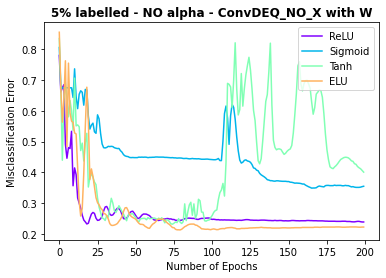

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('5% labelled - NO alpha - ConvDEQ_NO_X with W', fontweight='bold')
plt.legend()

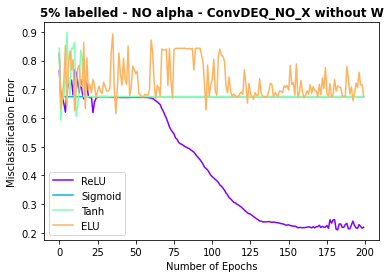

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('5% labelled - NO alpha - ConvDEQ_NO_X without W', fontweight='bold')
plt.legend()

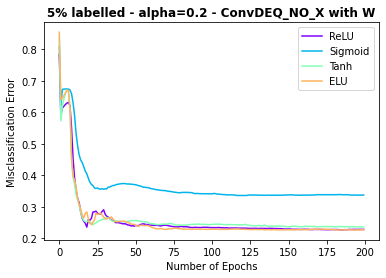

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('5% labelled - alpha=0.2 - ConvDEQ_NO_X with W', fontweight='bold')
plt.legend()

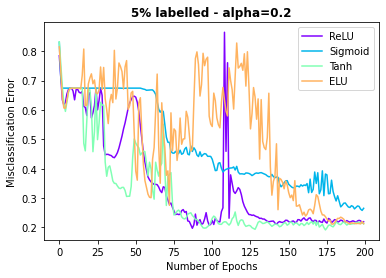

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('5% labelled - alpha=0.2', fontweight='bold')
plt.legend()

### Deep Graph DEQ $ \longrightarrow \tilde{Y} = softmax \left( Z^{\star} \Theta \right), Z^{\star} =  \sigma \left( \alpha \bar{A} Z W + (1 - \alpha) X U \right) $

In [ ]:
# ALTERNATIVE TRAINING OF THE NET WITH BOTH FEATURES AND LABELS

# SOFTMAX ON TOP OF LS_NORM WITH LABELS AND FEATURES NORMALIZED SEPARATELY
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

error = {}
activation_list = ['ReLU', 'Sigmoid', 'Tanh', 'ELU']#, 'Softmax']

for act in activation_list:

    f = ConvDEQLayer(d+l, d+l, d+l, d+l, A_scaled, act, alpha=0.2)
    model_train = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=50, m=5),
                                nn.Linear(d+l, l),
                                nn.Softmax()
                                ).to(device)

    opt = optim.Adam(model_train.parameters(), lr=1e-3)

    print("# Parmeters: ", sum(a.numel() for a in model_train.parameters()))

    max_epochs = 200
    scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

    total_error = []
    total_loss = []

    for i in range(max_epochs):
        ep = epoch(X_, Y, model_train, opt, scheduler)
        total_error.append(ep[1])
        total_loss.append(ep[2])
        if not i%10 or i==max_epochs-1:
            print(i, ep)
    error[act] = total_error

# Parmeters:  4160167


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 (0.8870967741935484, 0.757344064386318, 1.9454123973846436)
10 (0.14516129032258066, 0.5879275653923541, 1.591495394706726)
20 (0.03225806451612903, 0.30422535211267604, 1.2370623350143433)
30 (0.0, 0.2563380281690141, 1.179042100906372)
40 (0.0, 0.2917505030181087, 1.1663968563079834)
50 (0.0, 0.254728370221328, 1.165805697441101)
60 (0.0, 0.2720321931589537, 1.1656899452209473)
70 (0.0, 0.2370221327967807, 1.1655322313308716)
80 (0.0, 0.23943661971830985, 1.1654855012893677)
90 (0.0, 0.24507042253521127, 1.1654679775238037)
100 (0.0, 0.2535211267605634, 1.1654582023620605)
110 (0.0, 0.24949698189134809, 1.1654510498046875)
120 (0.0, 0.24788732394366197, 1.1654462814331055)
130 (0.0, 0.24748490945674045, 1.1654430627822876)
140 (0.0, 0.2470824949698189, 1.165440559387207)
150 (0.0, 0.24587525150905432, 1.1654382944107056)
160 (0.0, 0.24305835010060362, 1.1654363870620728)
170 (0.0, 0.24064386317907444, 1.1654349565505981)
180 (0.0, 0.23943661971830985, 1.165433645248413)
190 (0.0, 0

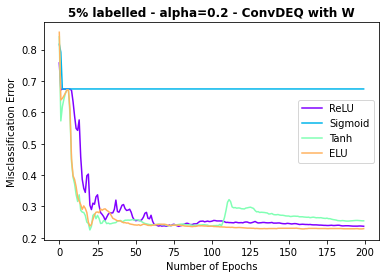

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('5% labelled - alpha=0.2 - ConvDEQ with W', fontweight='bold')
plt.legend()

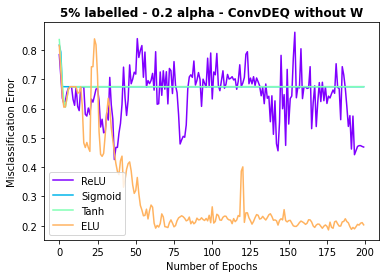

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('5% labelled - 0.2 alpha - ConvDEQ without W', fontweight='bold')
plt.legend()

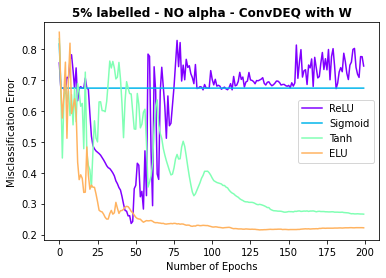

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('5% labelled - NO alpha - ConvDEQ with W', fontweight='bold')
plt.legend()

### Propagate and Predict Variants

In [ ]:
# DEEP GRAPH DEQ NO_X

# DEQ ON TOP OF LS_NORM WITH LABELS AND FEATURES NORMALIZED SEPARATELY

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

error = {}
best_models = {}
activation_list = ['ReLU', 'Sigmoid', 'Tanh', 'ELU']#, 'Softmax']

for act in activation_list:

    f = ConvDEQLayer_NO_X(d+l, d+l, d+l, d+l, A_scaled, act, alpha=0.2)
    model_train = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=50, m=5),
                                nn.Linear(d+l, l),
                                nn.Softmax()
                                ).to(device)

    opt = optim.Adam(model_train.parameters(), lr=1e-3)

    print("# Parmeters: ", sum(a.numel() for a in model_train.parameters()))

    max_epochs = 200
    scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

    total_error = []
    total_loss = []

    for i in range(max_epochs):
        ep = epoch(X_LS_norm, Y, model, opt, scheduler, lambda_reg=0)

        total_error.append(ep[1])
        total_loss.append(ep[2])
        if not i%10 or i==max_epochs-1:
            print(i, ep)
        
        if i == 0:
            best_error = (ep[1], i)
            best_model = deepcopy(model)
        elif best_error[0] > ep[1]:
            best_error = (ep[1], i)
            best_model = deepcopy(model)
            
    print(best_error)
    best_models[act] = best_model
    error[act] = total_error

# Parmeters:  4160167


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 (0.7741935483870968, 0.7859154929577464, 1.9449273347854614)
10 (0.12096774193548387, 0.26519114688128775, 1.4160451889038086)
20 (0.056451612903225805, 0.22253521126760564, 1.2226309776306152)
30 (0.016129032258064516, 0.20603621730382293, 1.198738694190979)
40 (0.008064516129032258, 0.2052313883299799, 1.1768641471862793)
50 (0.008064516129032258, 0.20482897384305834, 1.1741129159927368)
60 (0.008064516129032258, 0.20201207243460764, 1.1728274822235107)
70 (0.0, 0.18993963782696177, 1.1663243770599365)
80 (0.0, 0.19597585513078472, 1.165736198425293)
90 (0.0, 0.20080482897384305, 1.1655890941619873)
100 (0.0, 0.19798792756539235, 1.165509819984436)
110 (0.0, 0.19436619718309858, 1.1654809713363647)
120 (0.0, 0.19517102615694165, 1.1654670238494873)
130 (0.0, 0.19396378269617706, 1.16545832157135)
140 (0.0, 0.19396378269617706, 1.1654518842697144)
150 (0.0, 0.19235412474849095, 1.165447473526001)
160 (0.0, 0.19275653923541247, 1.1654438972473145)
170 (0.0, 0.19275653923541247, 1.165

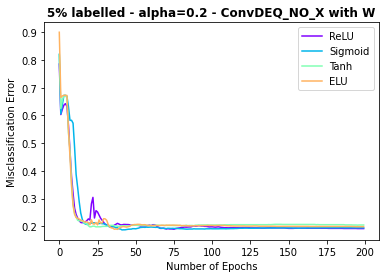

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('5% labelled - alpha=0.2 - ConvDEQ_NO_X with W', fontweight='bold')
plt.legend()

In [ ]:
# DEEP GRAPH DEQ NO_X

# DEQ ON TOP OF LS_NORM WITH LABELS AND FEATURES NORMALIZED SEPARATELY

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

error = {}
best_models = {}
activation_list = ['ReLU', 'Sigmoid', 'Tanh', 'ELU']#, 'Softmax']

for act in activation_list:

    f = ConvDEQLayer_NO_X(d+l, d+l, d+l, d+l, A_scaled, act, alpha=0.2)
    model_train = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=50, m=5),
                                nn.Linear(d+l, l),
                                nn.Softmax()
                                ).to(device)

    # f_test = ConvDEQLayer_NO_X(d+l, d+l, d+l, d+l, A_scaled[mask][:, mask], act, alpha=0.2)
    # model_test = nn.Sequential(DEQFixedPoint(f_test, anderson, tol=1e-5, max_iter=50, m=5)).to(device)


    opt = optim.Adam(model_train.parameters(), lr=1e-3)

    print("# Parmeters: ", sum(a.numel() for a in model_train.parameters()))

    max_epochs = 200
    scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

    total_error = []
    total_loss = []

    for i in range(max_epochs):
        ep = epoch(X_LS_norm, Y, model, opt, scheduler, lambda_reg=0)

        total_error.append(ep[1])
        total_loss.append(ep[2])
        if not i%10 or i==max_epochs-1:
            print(i, ep)
        
        if i == 0:
            best_error = (ep[1], i)
            best_model = deepcopy(model)
        elif best_error[0] > ep[1]:
            best_error = (ep[1], i)
            best_model = deepcopy(model)
            
    print(best_error)
    best_models[act] = best_model
    error[act] = total_error

# Parmeters:  4160167


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 (0.7661290322580645, 0.7633802816901408, 1.9447870254516602)
10 (0.1774193548387097, 0.3183098591549296, 1.462049126625061)
20 (0.06451612903225806, 0.22253521126760564, 1.2382196187973022)
30 (0.056451612903225805, 0.21851106639839035, 1.2166718244552612)
40 (0.008064516129032258, 0.21287726358148892, 1.1794096231460571)
50 (0.008064516129032258, 0.20321931589537223, 1.1745089292526245)
60 (0.008064516129032258, 0.19959758551307846, 1.1737679243087769)
70 (0.008064516129032258, 0.2040241448692153, 1.1735759973526)
80 (0.008064516129032258, 0.20925553319919518, 1.1732666492462158)
90 (0.008064516129032258, 0.20040241448692153, 1.173038125038147)
100 (0.008064516129032258, 0.19476861167002013, 1.1725232601165771)
110 (0.0, 0.19839034205231387, 1.1659882068634033)
120 (0.0, 0.19396378269617706, 1.1655234098434448)
130 (0.0, 0.193158953722334, 1.1655086278915405)
140 (0.0, 0.18993963782696177, 1.1654680967330933)
150 (0.0, 0.186317907444668, 1.165452480316162)
160 (0.0, 0.18551307847082

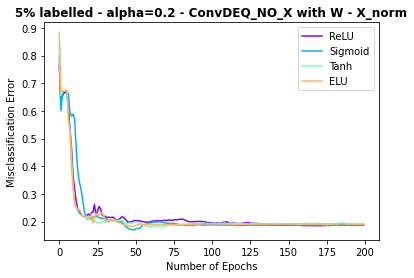

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('5% labelled - alpha=0.2 - ConvDEQ_NO_X with W - X_norm', fontweight='bold')
plt.legend()

In [ ]:
# DEEP GRAPH DEQ

# SOFTMAX ON TOP OF LS_NORM WITH LABELS AND FEATURES NORMALIZED SEPARATELY
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

error = {}
best_models = {}
activation_list = ['ReLU', 'Sigmoid', 'Tanh', 'ELU']#, 'Softmax']

for act in activation_list:

    f = ConvDEQLayer(d+l, d+l, d+l, d+l, A_scaled, act, alpha=0.2)
    model_train = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=50, m=5),
                                nn.Linear(d+l, l),
                                nn.Softmax()
                                ).to(device)

    opt = optim.Adam(model_train.parameters(), lr=1e-3)

    print("# Parmeters: ", sum(a.numel() for a in model_train.parameters()))

    max_epochs = 200
    scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

    total_error = []
    total_loss = []

    for i in range(max_epochs):
        ep = epoch(X_LS_norm, Y, model, opt, scheduler, lambda_reg=0)

        total_error.append(ep[1])
        total_loss.append(ep[2])
        if not i%10 or i==max_epochs-1:
            print(i, ep)
        
        if i == 0:
            best_error = (ep[1], i)
            best_model = deepcopy(model)
        elif best_error[0] > ep[1]:
            best_error = (ep[1], i)
            best_model = deepcopy(model)
            
    print(best_error)
    best_models[act] = best_model
    error[act] = total_error

# Parmeters:  4160167


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 (0.7903225806451613, 0.7665995975855131, 1.945023775100708)
10 (0.16129032258064516, 0.2772635814889336, 1.5200117826461792)
20 (0.08064516129032258, 0.23943661971830985, 1.254520297050476)
30 (0.04838709677419355, 0.2152917505030181, 1.2208020687103271)
40 (0.04838709677419355, 0.20885311871227363, 1.211984395980835)
50 (0.0, 0.20643863179074445, 1.192223072052002)
60 (0.0, 0.2052313883299799, 1.1714930534362793)
70 (0.0, 0.2012072434607646, 1.1663954257965088)
80 (0.0, 0.20603621730382293, 1.1658235788345337)
90 (0.0, 0.19718309859154928, 1.1656063795089722)
100 (0.0, 0.19718309859154928, 1.1655478477478027)
110 (0.0, 0.19678068410462776, 1.165521264076233)
120 (0.0, 0.19758551307847083, 1.1655068397521973)
130 (0.0, 0.19597585513078472, 1.1654963493347168)
140 (0.0, 0.19517102615694165, 1.165488600730896)
150 (0.0, 0.19557344064386317, 1.165482521057129)
160 (0.0, 0.19517102615694165, 1.1654771566390991)
170 (0.0, 0.19597585513078472, 1.1654728651046753)
180 (0.0, 0.19517102615694

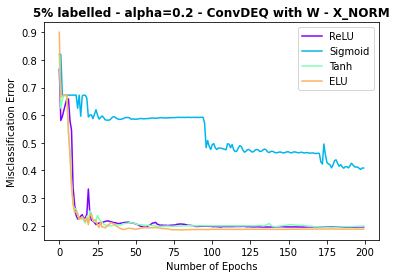

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('5% labelled - alpha=0.2 - ConvDEQ with W - X_NORM', fontweight='bold')
plt.legend()

In [ ]:
# DEEP GRAPH DEQ

# SOFTMAX ON TOP OF LS_NORM WITH LABELS AND FEATURES NORMALIZED SEPARATELY
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

error = {}
best_models = {}
activation_list = ['ReLU', 'Sigmoid', 'Tanh', 'ELU']#, 'Softmax']

for act in activation_list:

    f = ConvDEQLayer(d+l, d+l, d+l, d+l, A_scaled, act, alpha=0.2)
    model_train = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=50, m=5),
                                nn.Linear(d+l, l),
                                nn.Softmax(dim=1)
                                ).to(device)

    opt = optim.Adam(model_train.parameters(), lr=1e-3)

    print("# Parmeters: ", sum(a.numel() for a in model_train.parameters()))

    max_epochs = 200
    scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

    total_error = []
    total_loss = []

    for i in range(max_epochs):
        ep = epoch(X_LS_norm, Y, model, opt, scheduler, lambda_reg=0)

        total_error.append(ep[1])
        total_loss.append(ep[2])
        if not i%10 or i==max_epochs-1:
            print(i, ep)
        
        if i == 0:
            best_error = (ep[1], i)
            best_model = deepcopy(model)
        elif best_error[0] > ep[1]:
            best_error = (ep[1], i)
            best_model = deepcopy(model)
            
    print(best_error)
    best_models[act] = best_model
    error[act] = total_error

# Parmeters:  4160167


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 (0.7741935483870968, 0.7207243460764587, 1.9449037313461304)
10 (0.22580645161290322, 0.34164989939637824, 1.5762100219726562)
20 (0.1532258064516129, 0.2627766599597586, 1.313027024269104)
30 (0.06451612903225806, 0.20442655935613682, 1.2516844272613525)
40 (0.04838709677419355, 0.2056338028169014, 1.2243951559066772)
50 (0.04838709677419355, 0.2052313883299799, 1.210384488105774)
60 (0.0, 0.18591549295774648, 1.1803196668624878)
70 (0.0, 0.19275653923541247, 1.168710470199585)
80 (0.0, 0.18712273641851107, 1.1661133766174316)
90 (0.0, 0.1879275653923541, 1.1657469272613525)
100 (0.0, 0.1818913480885312, 1.1656132936477661)
110 (0.0, 0.17987927565392353, 1.1655505895614624)
120 (0.0, 0.18430583501006037, 1.165526270866394)
130 (0.0, 0.18309859154929578, 1.1655112504959106)
140 (0.0, 0.18148893360160967, 1.1654995679855347)
150 (0.0, 0.1822937625754527, 1.1654903888702393)
160 (0.0, 0.1822937625754527, 1.1654831171035767)
170 (0.0, 0.18269617706237423, 1.1654771566390991)
180 (0.0, 0

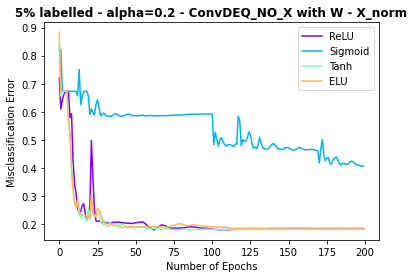

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('5% labelled - alpha=0.2 - ConvDEQ_NO_X with W - X_norm', fontweight='bold')
plt.legend()

### KIPF & WELLING $\longrightarrow f(X, A) = \text{softmax}\left(A \text{ ReLU} (A X W_1) W_2 \right)$



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

errors = {}
activation_list = ['ReLU', 'Tanh'] #'Softmax', 'Sigmoid', 'ELU'

n_rand_sampling = 100

for j in np.arange(n_rand_sampling):
    # We define a kfold with a random_state so that we can use the same split for
    # cross-validating both Label Spreading and the neural network.

    print('-------------------------------------------------------------------------')
    print('\t \t Random Sampling No. %d' %(j+1))
    print('-------------------------------------------------------------------------\n')
    
    # Extraction of the known and unknown labels
    known = []
    for lab in Y.unique():
        known_lab = torch.where(Y == lab)[0].numpy()
        known.extend(np.random.choice(known_lab, size=int(np.floor(len(known_lab)*p)), replace=False))

    unknown = np.ones(n, dtype=bool)
    unknown[known] = False

    for act in activation_list:

        model_KIPF = nn.Sequential(nn.Linear(d, d),
                                nn.ReLU(),
                                nn.Linear(d, d),
                                nn.Softmax(dim=1)).to(device)

        AX = torch.tensor(A_scaled.toarray(), dtype=torch.float32, device=device) @ (X / torch.max(X, 1)[0].reshape(-1,1)).to(device)                               

        opt = optim.Adam(model_KIPF.parameters(), lr=1e-3)

        print("Parmeters: ", sum(a.numel() for a in model_KIPF.parameters()))

        max_epochs = 2000
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        train_error = []
        train_loss = []
        test_error = []
        test_loss = []

        for i in range(max_epochs):
            ep = epoch(AX, Y, model_KIPF, opt, scheduler, lambda_reg=0)
            train_error.append(ep[0])
            train_loss.append(ep[1])
            test_error.append(ep[2])
            test_loss.append(ep[3])
            if not i%100 or i==max_epochs-1:
                print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                      %(i, ep[0], ep[1], ep[2], ep[3]))
                
            if i == 0:
                best_error = (ep[2], i)
                best_model = deepcopy(model_KIPF)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)
                best_model = deepcopy(model_KIPF)

        print('---- Activation=%s - Best Error=%.5f reached at Ep. %d ---- \n' %(act, best_error[0], best_error[1]))
                
        act_ = act + '_' + str(i)
        errors[act_] = best_error[0]

Parmeters:  4109844


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 0 - Training Error: 1.00000 - Train Loss: 7.2675 - Test Error: 0.95091 - Test Loss: 7.2676
Epoch 100 - Training Error: 0.04959 - Train Loss: 6.3187 - Test Error: 0.23702 - Test Loss: 6.5750
Epoch 200 - Training Error: 0.04959 - Train Loss: 6.3184 - Test Error: 0.24386 - Test Loss: 6.5680
Epoch 300 - Training Error: 0.04959 - Train Loss: 6.3184 - Test Error: 0.24306 - Test Loss: 6.5646
Epoch 400 - Training Error: 0.04959 - Train Loss: 6.3183 - Test Error: 0.24306 - Test Loss: 6.5622
Epoch 500 - Training Error: 0.00000 - Train Loss: 6.2688 - Test Error: 0.24024 - Test Loss: 6.5561
Epoch 600 - Training Error: 0.00000 - Train Loss: 6.2688 - Test Error: 0.22334 - Test Loss: 6.5400
Epoch 700 - Training Error: 0.00000 - Train Loss: 6.2687 - Test Error: 0.22254 - Test Loss: 6.5369
Epoch 800 - Training Error: 0.00000 - Train Loss: 6.2687 - Test Error: 0.22254 - Test Loss: 6.5353
Epoch 900 - Training Error: 0.00000 - Train Loss: 6.2687 - Test Error: 0.22294 - Test Loss: 6.5345
Epoch 1000 -

## Citeseer

In [ ]:
X, Y, A_scaled = citeseer_import()

Is G connected? False
Number of nodes Max Connected Component:  2110
Connected adjacency matrix shape: (2110, 2110)
Connected Feature Matrix shape: (2110, 3703)


In [ ]:
n = X.shape[0]
d = X.shape[1]
l = len(Y.unique()) # number of labels
p = 0.05 # known labels proportion

# Let us select the known labels
known = []
for lab in Y.unique():
    known_lab = torch.where(Y == lab)[0].numpy()
    known.extend(np.random.choice(known_lab, size=int(np.floor(len(known_lab)*p)), replace=False))
print('Number of known labels: ', len(known))

unknown = np.ones(n, dtype=bool)
unknown[known] = False

Y_one_hot = pd.get_dummies(Y)

# Construct the X_ matrix containing not just features but also the labels of the known points.
X_ = torch.cat([torch.zeros(X.shape[0], l), X], axis=1)
X_[known, :l] = F.one_hot(Y[known]).type(torch.float)

Number of known labels:  103


### Linear Label Spreading

In [ ]:
X_LS = linear_label_spreading(X_, A_scaled, alpha=0.8, tol=1e-5, max_iter=50)

print('Accuracy:', (torch.sum((torch.argmax(X_LS[unknown,:l], 1) - Y)==0)/ len(unknown)).item())

X_LS_norm_lab = X_LS[:, :l] / torch.max(X_LS[:, :l], dim=1).values.reshape(-1,1)
X_LS_norm_feat = X_LS[:, l:] / torch.max(X_LS[:, l:], dim=1).values.reshape(-1,1)

X_norm = X_LS / torch.max(X_LS, dim=1).values.reshape(-1,1)

X_NORM = torch.cat([X_LS_norm_lab, X_LS_norm_feat], dim=1)

Accuracy: 0.6748815178871155


### FULLY CROSS-VALIDATED MODEL

In [ ]:
######### FULLY CROSS-VALIDATED MODEL ##########

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

n_rand_sampling = 1 # No. of different random samplings we will consider

activation_list = ['ReLU'] #'Tanh'

LS_accuracies = []
errors = {}
best_models = {}
total_errors = {}
errors_KIPF = {}
errors_KIPF_1000 = {}

for j in np.arange(n_rand_sampling):
    # We define a kfold with a random_state so that we can use the same split for
    # cross-validating both Label Spreading and the neural network.
    kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=rand.randint(0,10000))

    # Extraction of the known and unknown labels
    known = []
    for lab in Y.unique():
        known_lab = torch.where(Y == lab)[0].numpy()
        known.extend(np.random.choice(known_lab, size=int(np.floor(len(known_lab)*p)), replace=False))

    unknown = np.ones(n, dtype=bool)
    unknown[known] = False
    
    print('-------------------------------------------------------------------------')
    print('\t \t Random Sampling No. %d' %(j+1))
    print('-------------------------------------------------------------------------\n')
    print('Number of known labels: %d \n' %(len(known)))
    
    
    ############# LABEL SPREADING CROSS-VALIDATION #############

    print('############# LABEL SPREADING CROSS-VALIDATION #############')
    accuracies_alpha = {}

    for alpha in [0.1, 0.3, 0.5, 0.7, 0.9]:
        accuracy_folds = {}
        print('----------------------- Alpha=%.1f ----------------------' %(alpha))
        
        for fold, (train_ids, validation_ids) in enumerate(kfold.split(X_[known], Y[known])):
            train_ids = [known[j] for j in train_ids]
            validation_ids = [known[j] for j in validation_ids]
            
            X_zeros = torch.cat([torch.zeros(X.shape[0], l), X], axis=1)
            X_zeros[train_ids, :l] = torch.tensor(Y_one_hot.iloc[train_ids].values, dtype=torch.float32)
            X_LS = linear_label_spreading(X_zeros, A_scaled, alpha=alpha, tol=1e-5, max_iter=50)

            fold_pred = X_LS[validation_ids, :l].max(dim=1)[1]
            fold_accuracy = (fold_pred == Y[validation_ids].view(-1)).sum().item() / float(len(validation_ids))
            accuracy_folds[fold] = fold_accuracy

            # print('Fold %d - Validation Accuracy: %.3f' %(fold, fold_accuracy))
        
        accuracies_alpha[alpha] = np.mean(list(accuracy_folds.values()))
        print('---- Average Validation Accuracy for Alpha=%.1f: %.3f ---- \n' %(alpha, accuracies_alpha[alpha]))

    best_alpha = max(accuracies_alpha.keys(), key=(lambda x: accuracies_alpha[x]))
    # best_alphas.append(best_alpha)
    print('---------- Label Spreading - Best Alpha = %.1f ---------- \n' %(best_alpha))
    

    # LABEL SPREADING EVALUATION FOR best_alpha FOR THE RANDOM SAMPLING
    X_LS = linear_label_spreading(X_, A_scaled, alpha=best_alpha)

    X_LS_norm = X_LS / torch.max(X_LS, dim=1).values.reshape(-1,1)
    LS_accuracy = torch.sum((torch.argmax(X_LS[unknown,:l], 1) - Y[unknown])==0).item()/ float(len(unknown))
    LS_accuracies.append(LS_accuracy)

    print('---------- Label Spreading - Accuracy = %.3f ---------- \n' %(LS_accuracy))

    accuracies_beta = {}

    print('############# NEURAL NETWORK CROSS-VALIDATION #############')
    

    for act in activation_list:

        for beta in [0.1, 0.3, 0.5]:
            accuracy_folds = {}
            print('----------------------- Beta=%.1f ----------------------' %(beta))
            
            for fold, (train_ids, validation_ids) in enumerate(kfold.split(X_[known], Y[known])):

                train_ids = [known[j] for j in train_ids]
                validation_ids = [known[j] for j in validation_ids]

                f = ConvDEQLayer_NO_X(d+l, d+l, d+l, d+l, A_scaled, act, beta=beta)
                model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=50, m=5),
                                            nn.Linear(d+l, l),
                                            nn.Softmax(dim=1)
                                            ).to(device)

                opt = optim.Adam(model.parameters(), lr=1e-3)

                max_epochs = 100
                scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

                for i in np.arange(max_epochs):
                    ep = epoch_fold(X_LS_norm, Y, model, opt, scheduler, lambda_reg=0)

                    if not i%25 or i==max_epochs-1:
                        print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                            %(i, ep[0], ep[1], ep[2], ep[3]))
                    
                    if i == 0:
                        best_error = (ep[2], i)
                        best_model = deepcopy(model)
                    elif best_error[0] > ep[2]:
                        best_error = (ep[2], i)
                        best_model = deepcopy(model)

                # print('\t Fold %d - Best Error : %.3f - Reached at epoch %d' %(fold, best_error[0], best_error[1]))
                fold_pred = best_model(X_LS_norm.to(device))[validation_ids].max(dim=1)[1].detach().cpu()
                accuracy_folds[fold] = (fold_pred == Y[validation_ids].view(-1)).sum().item() / float(len(validation_ids))
            
            accuracies_beta[beta] = np.mean(list(accuracy_folds.values()))
            print('---- Average Validation Accuracy for Beta=%.1f: %.3f ---- \n' %(beta, accuracies_beta[beta]))

        best_beta = max(accuracies_beta.keys(), key=(lambda x: accuracies_beta[x]))
        print('--------------------- Best Beta=%.1f -------------------- \n' %(best_beta))
        print('--------------------- Model Training -------------------- \n')

        f = ConvDEQLayer_NO_X(d+l, d+l, d+l, d+l, A_scaled, act, beta=best_beta)
        model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=50, m=5),
                                        nn.Linear(d+l, l),
                                        nn.Softmax(dim=1)
                                        ).to(device)

        opt = optim.Adam(model.parameters(), lr=1e-3)

        print("Model Parmeters: %d " %(sum(a.numel() for a in model.parameters())))

        max_epochs = 750
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        train_error = []
        train_loss = []
        test_error = []
        test_loss = []

        for i in range(max_epochs):
            ep = epoch(X_LS_norm, Y, model, opt, scheduler, lambda_reg=0)

            train_error.append(ep[0])
            train_loss.append(ep[1])
            test_error.append(ep[2])
            test_loss.append(ep[3])

            if not i%10 or i==max_epochs-1:
                print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                        %(i, ep[0], ep[1], ep[2], ep[3]))
            
            if i == 0:
                best_error = (ep[2], i)
                best_model = deepcopy(model)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)
                best_model = deepcopy(model)

        print('------- Activation=%s - Best Error=%.5f (ep. %d) ------- \n' %(act, best_error[0], best_error[1]))

        act_ = act + '_' + str(j)
        best_models[act_] = best_model
        errors[act_] = best_error[0]
        total_errors[act_] = test_error

    print('------------------ Kipf and Welling Training ----------------- \n')        

    model_KIPF = nn.Sequential(nn.Linear(d, d),
                            nn.ReLU(),
                            nn.Linear(d, d),
                            nn.Softmax(dim=1)).to(device)

    AX = torch.tensor(A_scaled.toarray(), dtype=torch.float32, device=device) @ (X / torch.max(X, 1)[0].reshape(-1,1)).to(device)                               

    opt = optim.Adam(model_KIPF.parameters(), lr=1e-3)

    print("Parmeters: ", sum(a.numel() for a in model_KIPF.parameters()))

    max_epochs = 3000
    scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

    # train_error_KIPF = []
    # train_loss_KIPF = []
    # test_error_KIPF = []
    # test_loss_KIPF = []

    for i in range(max_epochs):
        ep = epoch(AX, Y, model_KIPF, opt, scheduler, lambda_reg=0)
        # train_error_KIPF.append(ep[0])
        # train_loss_KIPF.append(ep[1])
        # test_error_KIPF.append(ep[2])
        # test_loss_KIPF.append(ep[3])
        if not i%200 or i==max_epochs-1:
            print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                  %(i, ep[0], ep[1], ep[2], ep[3]))
            
        if i == 0:
            best_error_KIPF = (ep[2], i)
            best_error_KIPF_1000 = (ep[2], i)
            best_model_KIPF = deepcopy(model_KIPF)
        elif best_error_KIPF[0] > ep[2]:
                if i < 1000:
                    best_error_KIPF = (ep[2], i)
                    best_error_KIPF_1000 = (ep[2], i)
                    best_model_KIPF = deepcopy(model_KIPF)
                else:
                    best_error_KIPF = (ep[2], i)
                    best_model_KIPF = deepcopy(model_KIPF)

    print('-------- Best Error=%.5f reached at Ep. %d -------- \n' %(best_error_KIPF[0], best_error_KIPF[1]))
    print('---- Best Error after 1000 Ep.=%.5f (at Ep. %d) ---- \n' %(best_error_KIPF_1000[0], best_error_KIPF_1000[1]))
            
    act_ = 'ReLU' + '_' + str(i)
    errors_KIPF[act_] = best_error_KIPF[0]
    errors_KIPF_1000[act_] = best_error_KIPF_1000[0]

avg_acc_ReLU = 1 - np.mean([errors[act] for act in errors.keys() if act.startswith('ReLU')])
avg_acc_Tanh = 1 - np.mean([errors[act] for act in errors.keys() if act.startswith('Tanh')])
avg_acc_KIPF = 1 - np.mean([errors_KIPF[act] for act in errors_KIPF.keys() if act.startswith('ReLU')])
avg_acc_KIPF_1000 = 1 - np.mean([errors_KIPF_1000[act] for act in errors_KIPF_1000.keys() if act.startswith('ReLU')])

print('################################################################')
print('\t \t Result over the %d random sampling' %(n_rand_sampling))
print('Average Accuracy Label Spreading: %.5f' %(np.mean(LS_accuracies)))
print('Average Accuracy for ReLU: %.5f' %(avg_acc_ReLU))
print('Average Accuracy for Tanh: %.5f' %(avg_acc_Tanh))
print('Average Accuracy for Kipf & Welling after 1000 epochs: %.5f' %(avg_acc_KIPF_1000))
print('Average Accuracy for Kipf & Welling: %.5f' %(avg_acc_KIPF))
print('################################################################')

-------------------------------------------------------------------------
	 	 Random Sampling No. 1
-------------------------------------------------------------------------

Number of known labels: 103 

############# LABEL SPREADING CROSS-VALIDATION #############
----------------------- Alpha=0.1 ----------------------
---- Average Validation Accuracy for Alpha=0.1: 0.553 ---- 

----------------------- Alpha=0.3 ----------------------
---- Average Validation Accuracy for Alpha=0.3: 0.583 ---- 

----------------------- Alpha=0.5 ----------------------
---- Average Validation Accuracy for Alpha=0.5: 0.612 ---- 

----------------------- Alpha=0.7 ----------------------
---- Average Validation Accuracy for Alpha=0.7: 0.622 ---- 

----------------------- Alpha=0.9 ----------------------
---- Average Validation Accuracy for Alpha=0.9: 0.660 ---- 

---------- Label Spreading - Best Alpha = 0.9 ---------- 

---------- Label Spreading - Accuracy = 0.636 ---------- 

############# NEURAL NETWO

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
LS_accuracies = [0.63649, 0.64787, 0.66019, 0.65877, 0.64692]
model_accuracies = [0.73839, 0.73981, 0.74502, 0.74123, 0.74976]
kipf_accuracies = [0.74265, 0.72749, 0.72891, 0.70569, 0.73175]

print()

### Deep Graph DEQ NO_X  $ \longrightarrow \tilde{Y} = softmax \left( Z^{\star} \Theta \right), Z^{\star} = \alpha \sigma \left( \bar{A} Z W\right) + (1 - \alpha) X U $

In [ ]:
# ALTERNATIVE TRAINING OF THE NET WITH BOTH FEATURES AND LABELS

# SOFTMAX ON TOP OF LS_NORM WITH LABELS AND FEATURES NORMALIZED SEPARATELY
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

error = {}
activation_list = ['ReLU', 'Sigmoid', 'Tanh', 'ELU']#, 'Softmax']

for act in activation_list:

    f = ConvDEQLayer_NO_X(d+l, d+l, d+l, d+l, A_scaled, act, alpha=0.2)
    model_train = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=50, m=5),
                                nn.Linear(d+l, l),
                                nn.Softmax()
                                ).to(device)

    # f_test = ConvDEQLayer_NO_X(d+l, d+l, d+l, d+l, A_scaled[mask][:, mask], act, alpha=0.2)
    # model_test = nn.Sequential(DEQFixedPoint(f_test, anderson, tol=1e-5, max_iter=50, m=5)).to(device)


    opt = optim.Adam(model_train.parameters(), lr=1e-3)

    print("# Parmeters: ", sum(a.numel() for a in model_train.parameters()))

    max_epochs = 200
    scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

    total_error = []
    total_loss = []

    for i in range(max_epochs):
        ep = epoch(X_, Y, model_train, opt, scheduler)
        total_error.append(ep[1])
        total_loss.append(ep[2])
        if not i%10 or i==max_epochs-1:
            print(i, ep)
    error[act] = total_error

# Parmeters:  27543040


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 (0.819047619047619, 0.7966824644549763, 1.7916191816329956)
10 (0.047619047619047616, 0.6672985781990521, 1.0980576276779175)
20 (0.0, 0.49715639810426543, 1.0439939498901367)
30 (0.0, 0.4819905213270142, 1.04365873336792)
40 (0.0, 0.47393364928909953, 1.0436190366744995)
50 (0.0, 0.4720379146919431, 1.043608546257019)
60 (0.0, 0.466824644549763, 1.0436041355133057)
70 (0.0, 0.46445497630331756, 1.0436018705368042)
80 (0.0, 0.4606635071090047, 1.0436004400253296)
90 (0.0, 0.4601895734597156, 1.0435996055603027)
100 (0.0, 0.45734597156398105, 1.0435987710952759)
110 (0.0, 0.4549763033175355, 1.043597936630249)
120 (0.0, 0.45402843601895737, 1.0435974597930908)
130 (0.0, 0.45355450236966827, 1.0435971021652222)
140 (0.0, 0.45118483412322274, 1.0435967445373535)
150 (0.0, 0.45071090047393364, 1.0435961484909058)
160 (0.0, 0.4492890995260663, 1.0435959100723267)
170 (0.0, 0.44691943127962086, 1.043595552444458)
180 (0.0, 0.44502369668246444, 1.0435954332351685)
190 (0.0, 0.44312796208530

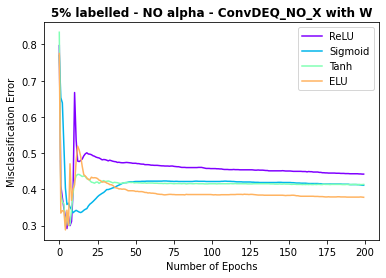

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('5% labelled - NO alpha - ConvDEQ_NO_X with W', fontweight='bold')
plt.legend()

### Deep Graph DEQ $ \longrightarrow \tilde{Y} = softmax \left( Z^{\star} \Theta \right), Z^{\star} =  \sigma \left( \alpha \bar{A} Z W + (1 - \alpha) X U \right) $

In [ ]:
# ALTERNATIVE TRAINING OF THE NET WITH BOTH FEATURES AND LABELS

# SOFTMAX ON TOP OF LS_NORM WITH LABELS AND FEATURES NORMALIZED SEPARATELY
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

error = {}
activation_list = ['ReLU', 'Sigmoid', 'Tanh', 'ELU']#, 'Softmax']

for act in activation_list:

    f = ConvDEQLayer(d+l, d+l, d+l, d+l, A_scaled, act, alpha=0.2)
    model_train = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=50, m=5),
                                nn.Linear(d+l, l),
                                nn.Softmax()
                                ).to(device)

    opt = optim.Adam(model_train.parameters(), lr=1e-3)

    print("# Parmeters: ", sum(a.numel() for a in model_train.parameters()))

    max_epochs = 200
    scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

    total_error = []
    total_loss = []

    for i in range(max_epochs):
        ep = epoch(X_, Y, model_train, opt, scheduler)
        total_error.append(ep[1])
        total_loss.append(ep[2])
        if not i%10 or i==max_epochs-1:
            print(i, ep)
    error[act] = total_error

# Parmeters:  27543040


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 (0.8952380952380953, 0.8744075829383886, 1.7920355796813965)
10 (0.0, 0.3739336492890995, 1.0706486701965332)
20 (0.0, 0.33933649289099527, 1.0437020063400269)
30 (0.0, 0.3928909952606635, 1.043670892715454)
40 (0.0, 0.3853080568720379, 1.0436162948608398)
50 (0.0, 0.37156398104265403, 1.043603539466858)
60 (0.0, 0.3639810426540284, 1.0435993671417236)
70 (0.0, 0.36161137440758295, 1.04359769821167)
80 (0.0, 0.35639810426540286, 1.043596863746643)
90 (0.0, 0.35260663507109, 1.0435962677001953)
100 (0.0, 0.35355450236966823, 1.0435960292816162)
110 (0.0, 0.35165876777251187, 1.043595790863037)
120 (0.0, 0.35023696682464456, 1.0435954332351685)
130 (0.0, 0.34834123222748814, 1.0435951948165894)
140 (0.0, 0.3469194312796208, 1.0435949563980103)
150 (0.0, 0.3464454976303318, 1.0435948371887207)
160 (0.0, 0.34502369668246446, 1.0435945987701416)
170 (0.0, 0.34549763033175357, 1.0435943603515625)
180 (0.0, 0.34502369668246446, 1.043594241142273)
190 (0.0, 0.34407582938388626, 1.04359412193

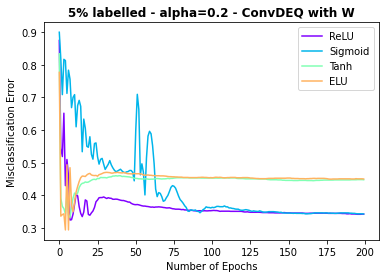

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('5% labelled - alpha=0.2 - ConvDEQ with W', fontweight='bold')
plt.legend()

### Propagate and Predict Variants

In [ ]:
# DEEP GRAPH DEQ NO_X

# DEQ ON TOP OF LS_NORM WITH LABELS AND FEATURES NORMALIZED SEPARATELY

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

error = {}
best_models = {}
activation_list = ['ReLU', 'Sigmoid', 'Tanh', 'ELU']#, 'Softmax']

for act in activation_list:

    f = ConvDEQLayer_NO_X(d+l, d+l, d+l, d+l, A_scaled, act, alpha=0.2)
    model_train = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=50, m=5),
                                nn.Linear(d+l, l),
                                nn.Softmax()
                                ).to(device)

    # f_test = ConvDEQLayer_NO_X(d+l, d+l, d+l, d+l, A_scaled[mask][:, mask], act, alpha=0.2)
    # model_test = nn.Sequential(DEQFixedPoint(f_test, anderson, tol=1e-5, max_iter=50, m=5)).to(device)


    opt = optim.Adam(model_train.parameters(), lr=1e-3)

    print("# Parmeters: ", sum(a.numel() for a in model_train.parameters()))

    max_epochs = 200
    scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

    total_error = []
    total_loss = []

    for i in range(max_epochs):
        ep = epoch(X_LS_norm, Y, model, opt, scheduler, lambda_reg=0)

        total_error.append(ep[1])
        total_loss.append(ep[2])
        if not i%10 or i==max_epochs-1:
            print(i, ep)
        
        if i == 0:
            best_error = (ep[1], i)
            best_model = deepcopy(model)
        elif best_error[0] > ep[1]:
            best_error = (ep[1], i)
            best_model = deepcopy(model)
            
    print(best_error)
    best_models[act] = best_model
    error[act] = total_error

# Parmeters:  27543040


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 (0.8380952380952381, 0.828909952606635, 1.7918227910995483)
10 (0.0380952380952381, 0.2881516587677725, 1.0775437355041504)
20 (0.0, 0.3180094786729858, 1.0454394817352295)
30 (0.0, 0.30995260663507107, 1.0441739559173584)
40 (0.0, 0.3075829383886256, 1.0436757802963257)
50 (0.0, 0.3104265402843602, 1.0436475276947021)
60 (0.0, 0.3075829383886256, 1.043619990348816)
70 (0.0, 0.3118483412322275, 1.0436114072799683)
80 (0.0, 0.3118483412322275, 1.0436091423034668)
90 (0.0, 0.3118483412322275, 1.0436078310012817)
100 (0.0, 0.3118483412322275, 1.043606162071228)
110 (0.0, 0.3113744075829384, 1.043605089187622)
120 (0.0, 0.30995260663507107, 1.0436041355133057)
130 (0.0, 0.3104265402843602, 1.0436033010482788)
140 (0.0, 0.30995260663507107, 1.043602466583252)
150 (0.0, 0.30995260663507107, 1.0436018705368042)
160 (0.0, 0.30995260663507107, 1.043601155281067)
170 (0.0, 0.30947867298578197, 1.0436005592346191)
180 (0.0, 0.3090047393364929, 1.0436002016067505)
190 (0.0, 0.30947867298578197, 

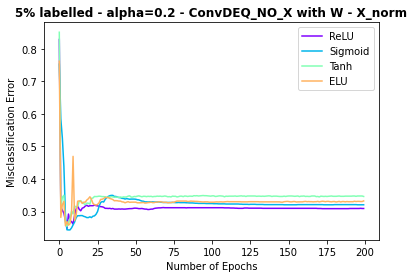

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('5% labelled - alpha=0.2 - ConvDEQ_NO_X with W - X_norm', fontweight='bold')
plt.legend()

In [ ]:
# DEEP GRAPH DEQ

# SOFTMAX ON TOP OF LS_NORM WITH LABELS AND FEATURES NORMALIZED SEPARATELY
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

error = {}
best_models = {}
activation_list = ['ReLU', 'Sigmoid', 'Tanh', 'ELU']#, 'Softmax']

for act in activation_list:

    f = ConvDEQLayer(d+l, d+l, d+l, d+l, A_scaled, act, alpha=0.2)
    model_train = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=50, m=5),
                                nn.Linear(d+l, l),
                                nn.Softmax()
                                ).to(device)

    opt = optim.Adam(model_train.parameters(), lr=1e-3)

    print("# Parmeters: ", sum(a.numel() for a in model_train.parameters()))

    max_epochs = 200
    scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

    total_error = []
    total_loss = []

    for i in range(max_epochs):
        ep = epoch(X_LS_norm, Y, model, opt, scheduler, lambda_reg=0)

        total_error.append(ep[1])
        total_loss.append(ep[2])
        if not i%10 or i==max_epochs-1:
            print(i, ep)
        
        if i == 0:
            best_error = (ep[1], i)
            best_model = deepcopy(model)
        elif best_error[0] > ep[1]:
            best_error = (ep[1], i)
            best_model = deepcopy(model)
            
    print(best_error)
    best_models[act] = best_model
    error[act] = total_error

# Parmeters:  27543040


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 (0.8857142857142857, 0.8810426540284361, 1.7918355464935303)
10 (0.047619047619047616, 0.2663507109004739, 1.103682041168213)
20 (0.0, 0.3018957345971564, 1.0475455522537231)
30 (0.0, 0.3123222748815166, 1.044431209564209)
40 (0.0, 0.3165876777251185, 1.0438531637191772)
50 (0.0, 0.3014218009478673, 1.043674349784851)
60 (0.0, 0.3028436018957346, 1.0436420440673828)
70 (0.0, 0.3004739336492891, 1.043622612953186)
80 (0.0, 0.3004739336492891, 1.0436136722564697)
90 (0.0, 0.3014218009478673, 1.0436078310012817)
100 (0.0, 0.3033175355450237, 1.0436040163040161)
110 (0.0, 0.3028436018957346, 1.043601155281067)
120 (0.0, 0.3042654028436019, 1.0435991287231445)
130 (0.0, 0.3071090047393365, 1.0435978174209595)
140 (0.0, 0.3071090047393365, 1.043596863746643)
150 (0.0, 0.3066350710900474, 1.0435961484909058)
160 (0.0, 0.3056872037914692, 1.043595790863037)
170 (0.0, 0.3066350710900474, 1.0435954332351685)
180 (0.0, 0.3061611374407583, 1.0435949563980103)
190 (0.0, 0.3061611374407583, 1.0435

KeyboardInterrupt: ignored

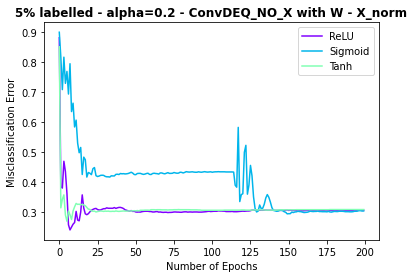

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in activation_list:
    c=next(color)
    plt.plot(error[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Misclassification Error')
plt.title('5% labelled - alpha=0.2 - ConvDEQ_NO_X with W - X_norm', fontweight='bold')
plt.legend()

### KIPF & WELLING $\longrightarrow f(X, A) = \text{softmax}\left(A \text{ ReLU} (A X W_1) W_2 \right)$



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

error = {}
activation_list = ['ReLU', 'Sigmoid', 'Tanh', 'ELU']#, 'Softmax', ]

for act in activation_list:

    model_KIPF = nn.Sequential(nn.Linear(d, d),
                               nn.ReLU(),
                               nn.Linear(d, d),
                               nn.Softmax()).to(device)

    AX = torch.tensor(A_scaled.toarray(), dtype=torch.float32, device=device) @ (X / torch.max(X, 1)[0].reshape(-1,1)).to(device)                               

    opt = optim.Adam(model_KIPF.parameters(), lr=1e-3)

    print("# Parmeters: ", sum(a.numel() for a in model_KIPF.parameters()))

    max_epochs = 200
    scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

    total_error = []
    total_loss = []

    for i in range(max_epochs):
        ep = epoch(AX, Y, model_KIPF, opt, scheduler)
        total_error.append(ep[1])
        total_loss.append(ep[2])
        # if not i%100 or i==max_epochs-1:
        print(i, ep)
    error[act] = total_error

# Parmeters:  27431824
0 (1.0, 0.9502369668246445, 8.216898918151855)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


1 (0.047619047619047616, 0.4075829383886256, 8.216814041137695)
2 (0.047619047619047616, 0.4052132701421801, 8.2166748046875)
3 (0.05714285714285714, 0.3995260663507109, 8.216343879699707)
4 (0.05714285714285714, 0.395260663507109, 8.215030670166016)
5 (0.05714285714285714, 0.390521327014218, 8.209647178649902)
6 (0.06666666666666667, 0.3966824644549763, 8.202301979064941)
7 (0.0761904761904762, 0.4165876777251185, 8.189457893371582)
8 (0.09523809523809523, 0.42938388625592416, 8.153635025024414)
9 (0.11428571428571428, 0.4374407582938389, 8.080233573913574)
10 (0.12380952380952381, 0.43033175355450237, 7.960855007171631)
11 (0.12380952380952381, 0.4127962085308057, 7.813007354736328)
12 (0.09523809523809523, 0.3928909952606635, 7.670192241668701)
13 (0.08571428571428572, 0.36824644549763036, 7.55762243270874)
14 (0.0761904761904762, 0.35308056872037913, 7.472653865814209)
15 (0.0761904761904762, 0.3355450236966825, 7.4077935218811035)
16 (0.05714285714285714, 0.3184834123222749, 7.359

## PUBMED-DIABETES

In [ ]:
X, Y, A_scaled = pubmed_import() 

In [ ]:
n = X.shape[0]
d = X.shape[1]
l = len(Y.unique()) # number of labels
p = 0.05 # known labels proportion

# Let us select the known labels
known = []
for lab in Y.unique():
    known_lab = torch.where(Y == lab)[0].numpy()
    known.extend(np.random.choice(known_lab, size=int(np.floor(len(known_lab)*p)), replace=False))
print('Number of known labels: ', len(known))

unknown = np.ones(n, dtype=bool)
unknown[known] = False

Y_one_hot = pd.get_dummies(Y)

# Construct the X_ matrix containing not just features but also the labels of the known points.
X_ = torch.cat([torch.zeros(X.shape[0], l), X], axis=1)
X_[known, :l] = F.one_hot(Y[known]).type(torch.float)

Number of known labels:  984


### Fully Cross-Validated Model

In [ ]:
######### FULLY CROSS-VALIDATED MODEL ##########

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

n_rand_sampling = 1 # No. of different random samplings we will consider

activation_list = ['ReLU'] #'Tanh'

LS_accuracies = []
errors = {}
best_models = {}
total_errors = {}
errors_KIPF = {}
errors_KIPF_1000 = {}

for j in np.arange(n_rand_sampling):
    # We define a kfold with a random_state so that we can use the same split for
    # cross-validating both Label Spreading and the neural network.
    kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=rand.randint(0,10000))

    # Extraction of the known and unknown labels
    known = []
    for lab in Y.unique():
        known_lab = torch.where(Y == lab)[0].numpy()
        known.extend(np.random.choice(known_lab, size=int(np.floor(len(known_lab)*p)), replace=False))

    unknown = np.ones(n, dtype=bool)
    unknown[known] = False
    
    print('-------------------------------------------------------------------------')
    print('\t \t Random Sampling No. %d' %(j+1))
    print('-------------------------------------------------------------------------\n')
    print('Number of known labels: %d \n' %(len(known)))
    
    
    ############# LABEL SPREADING CROSS-VALIDATION #############

    print('############# LABEL SPREADING CROSS-VALIDATION #############')
    accuracies_alpha = {}

    for alpha in [0.1, 0.3, 0.5, 0.7, 0.9]:
        accuracy_folds = {}
        print('----------------------- Alpha=%.1f ----------------------' %(alpha))
        
        for fold, (train_ids, validation_ids) in enumerate(kfold.split(X_[known], Y[known])):
            train_ids = [known[j] for j in train_ids]
            validation_ids = [known[j] for j in validation_ids]
            
            X_zeros = torch.cat([torch.zeros(X.shape[0], l), X], axis=1)
            X_zeros[train_ids, :l] = torch.tensor(Y_one_hot.iloc[train_ids].values, dtype=torch.float32)
            X_LS = linear_label_spreading(X_zeros, A_scaled, alpha=alpha, tol=1e-5, max_iter=50)

            fold_pred = X_LS[validation_ids, :l].max(dim=1)[1]
            fold_accuracy = (fold_pred == Y[validation_ids].view(-1)).sum().item() / float(len(validation_ids))
            accuracy_folds[fold] = fold_accuracy

            # print('Fold %d - Validation Accuracy: %.3f' %(fold, fold_accuracy))
        
        accuracies_alpha[alpha] = np.mean(list(accuracy_folds.values()))
        print('---- Average Validation Accuracy for Alpha=%.1f: %.3f ---- \n' %(alpha, accuracies_alpha[alpha]))

    best_alpha = max(accuracies_alpha.keys(), key=(lambda x: accuracies_alpha[x]))
    # best_alphas.append(best_alpha)
    print('---------- Label Spreading - Best Alpha = %.1f ---------- \n' %(best_alpha))
    

    # LABEL SPREADING EVALUATION FOR best_alpha FOR THE RANDOM SAMPLING
    X_LS = linear_label_spreading(X_, A_scaled, alpha=best_alpha)

    X_LS_norm = X_LS / torch.max(X_LS, dim=1).values.reshape(-1,1)
    LS_accuracy = torch.sum((torch.argmax(X_LS[unknown,:l], 1) - Y[unknown])==0).item()/ float(len(unknown))
    LS_accuracies.append(LS_accuracy)

    print('---------- Label Spreading - Accuracy = %.3f ---------- \n' %(LS_accuracy))

    accuracies_beta = {}

    print('############# NEURAL NETWORK CROSS-VALIDATION #############')
    

    for act in activation_list:

        for beta in [0.1, 0.3, 0.5]:
            accuracy_folds = {}
            print('----------------------- Beta=%.1f ----------------------' %(beta))
            
            for fold, (train_ids, validation_ids) in enumerate(kfold.split(X_[known], Y[known])):

                train_ids = [known[j] for j in train_ids]
                validation_ids = [known[j] for j in validation_ids]

                f = ConvDEQLayer_NO_X(d+l, d+l, d+l, d+l, A_scaled, act, beta=beta)
                model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=50, m=5),
                                            nn.Linear(d+l, l),
                                            nn.Softmax(dim=1)
                                            ).to(device)

                opt = optim.Adam(model.parameters(), lr=1e-3)

                max_epochs = 100
                scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

                for i in np.arange(max_epochs):
                    ep = epoch_fold(X_LS_norm, Y, model, opt, scheduler, lambda_reg=0)

                    if not i%25 or i==max_epochs-1:
                        print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                            %(i, ep[0], ep[1], ep[2], ep[3]))
                    
                    if i == 0:
                        best_error = (ep[2], i)
                        best_model = deepcopy(model)
                    elif best_error[0] > ep[2]:
                        best_error = (ep[2], i)
                        best_model = deepcopy(model)

                # print('\t Fold %d - Best Error : %.3f - Reached at epoch %d' %(fold, best_error[0], best_error[1]))
                fold_pred = best_model(X_LS_norm.to(device))[validation_ids].max(dim=1)[1].detach().cpu()
                accuracy_folds[fold] = (fold_pred == Y[validation_ids].view(-1)).sum().item() / float(len(validation_ids))
            
            accuracies_beta[beta] = np.mean(list(accuracy_folds.values()))
            print('---- Average Validation Accuracy for Beta=%.1f: %.3f ---- \n' %(beta, accuracies_beta[beta]))

        best_beta = max(accuracies_beta.keys(), key=(lambda x: accuracies_beta[x]))
        print('--------------------- Best Beta=%.1f -------------------- \n' %(best_beta))
        print('--------------------- Model Training -------------------- \n')

        f = ConvDEQLayer_NO_X(d+l, d+l, d+l, d+l, A_scaled, act, beta=best_beta)
        model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=50, m=5),
                                        nn.Linear(d+l, l),
                                        nn.Softmax(dim=1)
                                        ).to(device)

        opt = optim.Adam(model.parameters(), lr=1e-3)

        print("Model Parmeters: %d " %(sum(a.numel() for a in model.parameters())))

        max_epochs = 750
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        train_error = []
        train_loss = []
        test_error = []
        test_loss = []

        for i in range(max_epochs):
            ep = epoch(X_LS_norm, Y, model, opt, scheduler, lambda_reg=0)

            train_error.append(ep[0])
            train_loss.append(ep[1])
            test_error.append(ep[2])
            test_loss.append(ep[3])

            if not i%10 or i==max_epochs-1:
                print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                        %(i, ep[0], ep[1], ep[2], ep[3]))
            
            if i == 0:
                best_error = (ep[2], i)
                best_model = deepcopy(model)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)
                best_model = deepcopy(model)

        print('------- Activation=%s - Best Error=%.5f (ep. %d) ------- \n' %(act, best_error[0], best_error[1]))

        act_ = act + '_' + str(j)
        best_models[act_] = best_model
        errors[act_] = best_error[0]
        total_errors[act_] = test_error

    print('------------------ Kipf and Welling Training ----------------- \n')        

    model_KIPF = nn.Sequential(nn.Linear(d, d),
                            nn.ReLU(),
                            nn.Linear(d, d),
                            nn.Softmax(dim=1)).to(device)

    AX = torch.tensor(A_scaled.toarray(), dtype=torch.float32, device=device) @ (X / torch.max(X, 1)[0].reshape(-1,1)).to(device)                               

    opt = optim.Adam(model_KIPF.parameters(), lr=1e-3)

    print("Parmeters: ", sum(a.numel() for a in model_KIPF.parameters()))

    max_epochs = 3000
    scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

    # train_error_KIPF = []
    # train_loss_KIPF = []
    # test_error_KIPF = []
    # test_loss_KIPF = []

    for i in range(max_epochs):
        ep = epoch(AX, Y, model_KIPF, opt, scheduler, lambda_reg=0)
        # train_error_KIPF.append(ep[0])
        # train_loss_KIPF.append(ep[1])
        # test_error_KIPF.append(ep[2])
        # test_loss_KIPF.append(ep[3])
        if not i%200 or i==max_epochs-1:
            print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                  %(i, ep[0], ep[1], ep[2], ep[3]))
            
        if i == 0:
            best_error_KIPF = (ep[2], i)
            best_error_KIPF_1000 = (ep[2], i)
            best_model_KIPF = deepcopy(model_KIPF)
        elif best_error_KIPF[0] > ep[2]:
                if i < 1000:
                    best_error_KIPF = (ep[2], i)
                    best_error_KIPF_1000 = (ep[2], i)
                    best_model_KIPF = deepcopy(model_KIPF)
                else:
                    best_error_KIPF = (ep[2], i)
                    best_model_KIPF = deepcopy(model_KIPF)

    print('-------- Best Error=%.5f reached at Ep. %d -------- \n' %(best_error_KIPF[0], best_error_KIPF[1]))
    print('---- Best Error after 1000 Ep.=%.5f (at Ep. %d) ---- \n' %(best_error_KIPF_1000[0], best_error_KIPF_1000[1]))
            
    act_ = 'ReLU' + '_' + str(i)
    errors_KIPF[act_] = best_error_KIPF[0]
    errors_KIPF_1000[act_] = best_error_KIPF_1000[0]

avg_acc_ReLU = 1 - np.mean([errors[act] for act in errors.keys() if act.startswith('ReLU')])
avg_acc_Tanh = 1 - np.mean([errors[act] for act in errors.keys() if act.startswith('Tanh')])
avg_acc_KIPF = 1 - np.mean([errors_KIPF[act] for act in errors_KIPF.keys() if act.startswith('ReLU')])
avg_acc_KIPF_1000 = 1 - np.mean([errors_KIPF_1000[act] for act in errors_KIPF_1000.keys() if act.startswith('ReLU')])

print('################################################################')
print('\t \t Result over the %d random sampling' %(n_rand_sampling))
print('Average Accuracy Label Spreading: %.5f' %(np.mean(LS_accuracies)))
print('Average Accuracy for ReLU: %.5f' %(avg_acc_ReLU))
print('Average Accuracy for Tanh: %.5f' %(avg_acc_Tanh))
print('Average Accuracy for Kipf & Welling after 1000 epochs: %.5f' %(avg_acc_KIPF_1000))
print('Average Accuracy for Kipf & Welling: %.5f' %(avg_acc_KIPF))
print('################################################################')

### Linear Label Spreading

In [ ]:
X_LS = linear_label_spreading(X_, A_scaled, alpha=0.8, tol=1e-5, max_iter=50)

print('Accuracy:', (torch.sum((torch.argmax(X_LS[unknown,:l], 1) - Y)==0)/ len(unknown)).item())

X_norm = X_LS / torch.max(X_LS, dim=1).values.reshape(-1,1)

## INCIDENCE MATRIX

In [ ]:
X, Y, A_scaled, A = cora_import()

n = X.shape[0]
d = X.shape[1]
l = len(Y.unique()) # number of labels
p = 0.05 # known labels proportion

Number of nodes Max Connected Component:  2485
Connected adjacency matrix shape: (2485, 2485)
Connected Feature Matrix shape: (2485, 1433)


In [ ]:
X, Y, B_scaled, B = cora_import(adj=False)

Number of nodes Max Connected Component:  2485
Connected incidence matrix shape: (2485, 5069)
Connected Feature Matrix shape: (2485, 1433)


In [ ]:
D = sparse.diags(np.squeeze(np.asarray(np.sum(A, axis=1))))
np.sum(B.dot(B.transpose()) != D + A)

0

In [ ]:
D_ = sparse.diags(np.squeeze(np.asarray(1 / np.sqrt(np.sum(A, axis=1)))))
np.sum(B_scaled.dot(B_scaled.transpose()) != sparse.identity(n) + A_scaled)

1740

In [ ]:
np.sum(D_ @ D @ D_ != sparse.identity(n))

1392

In [ ]:
np.set_printoptions(threshold=np.inf)
np.sum(D_ @ D @ D_, axis=0)

matrix([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.

In [ ]:
(D_ @ D @ D_).data

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [ ]:
d

1433

In [ ]:
##############################################
####### FULLY CROSS VALIDATED MODEL ##########
##############################################

n_samplings = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

activation_list = ['ReLU']

LS_accuracies = []
errors = {}
total_errors = {}

errors_2 = {}
total_errors_2 = {}

for j in np.arange(n_samplings):

    # Extraction of the known and unknown labels
    known = []
    for lab in Y.unique():
        known_lab = torch.where(Y == lab)[0].numpy()
        known.extend(np.random.choice(known_lab, size=int(np.floor(len(known_lab)*p)), replace=False))

    unknown = np.ones(n, dtype=bool)
    unknown[known] = False

    X_ = torch.cat([torch.zeros(X.shape[0], l), X], axis=1)
    X_[known, :l] = F.one_hot(Y[known]).type(torch.float)

    print('-------------------------------------------------------------------------')
    print('\t \t Random Sampling No. %d' %(j+1))
    print('-------------------------------------------------------------------------\n')
    print('Number of known labels: %d \n' %(len(known)))
    print('-------------------------------------------------------------------------\n')

    for act in activation_list:

        f = Incidence_GEQLayer(d+l, d+l, d+l, d+l, B_scaled, act, act)
        GEQ_model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=50, m=5),
                                  nn.Linear(d+l,l),
                                  nn.Softmax(dim=1)).to(device)

        opt = optim.Adam(GEQ_model.parameters(), lr=1e-3)

        print("Model Parmeters: %d " %(sum(a.numel() for a in GEQ_model.parameters())))

        max_epochs = 300
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        train_error = []
        train_loss = []
        test_error = []
        test_loss = []

        for i in range(max_epochs):
            ep = epoch(X_, Y, GEQ_model, opt, scheduler)

            train_error.append(ep[0])
            train_loss.append(ep[1])
            test_error.append(ep[2])
            test_loss.append(ep[3])

            if not i%20 or i==max_epochs-1:
                print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f'
                        %(i, ep[0], ep[1], ep[2], ep[3]))
            # print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f'
            #             %(i, ep[0], ep[1], ep[2], ep[3]))
            if i == 0:
                best_error = (ep[2], i)
                #best_model = deepcopy(GEQ_model)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)
                #best_model = deepcopy(GEQ_model)

        print('------- Activation=%s - Best Error=%.5f (ep. %d) ------- \n' %(act, best_error[0], best_error[1]))

        act_ = act + '_' + str(j)
        errors[act_] = best_error[0]
        total_errors[act_] = test_error

        print('############################################## SECOND MODEL')

        # f = ConvGEQLayer(d+l, d+l, d+l, d+l, A_scaled, act)
        # model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=50, m=5),
        #                                 nn.Linear(d+l, l),
        #                                 nn.Softmax(dim=1)
        #                                 ).to(device)

        # opt = optim.Adam(model.parameters(), lr=1e-3)

        # print("Model Parmeters: %d " %(sum(a.numel() for a in model.parameters())))

        # max_epochs = 200
        # scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        # train_error = []
        # train_loss = []
        # test_error = []
        # test_loss = []

        # for i in range(max_epochs):
        #     ep = epoch(X_, Y, model, opt, scheduler)

        #     train_error.append(ep[0])
        #     train_loss.append(ep[1])
        #     test_error.append(ep[2])
        #     test_loss.append(ep[3])

        #     if not i%20 or i==max_epochs-1:
        #         print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f'
        #                 %(i, ep[0], ep[1], ep[2], ep[3]))
        #     # print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f'
        #     #             %(i, ep[0], ep[1], ep[2], ep[3]))
        #     if i == 0:
        #         best_error = (ep[2], i)
        #         #best_model = deepcopy(GEQ_model)
        #     elif best_error[0] > ep[2]:
        #         best_error = (ep[2], i)
        #         #best_model = deepcopy(GEQ_model)

        # print('------- Activation=%s - Best Error=%.5f (ep. %d) ------- \n' %(act, best_error[0], best_error[1]))

        # act_ = act + '_' + str(j)
        # errors_2[act_] = best_error[0]
        # total_errors_2[act_] = test_error

INCIDENCE_avg_acc_ReLU = 1 - np.mean([errors[act] for act in errors.keys() if act.startswith('ReLU')])
_avg_acc_ReLU = 1 - np.mean([errors_2[act] for act in errors_2.keys() if act.startswith('ReLU')])

print('################################################################')
print('\t \t Result over the %d random sampling' %(n_samplings))
print('Average Accuracy Incidence GEQ: %.5f' %(INCIDENCE_avg_acc_ReLU))
print('Average Accuracy GEQ: %.5f' %(_avg_acc_ReLU))
print('################################################################')

-------------------------------------------------------------------------
	 	 Random Sampling No. 1
-------------------------------------------------------------------------

Number of known labels: 121 

-------------------------------------------------------------------------

Model Parmeters: 6235207 
Epoch 0 - Training Error: 0.91736 - Train Loss: 1.9485 - Test Error: 0.84628 - Test Loss: 1.9471
Epoch 20 - Training Error: 0.69421 - Train Loss: 1.8594 - Test Error: 0.69899 - Test Loss: 1.8990
Epoch 40 - Training Error: 0.01653 - Train Loss: 1.2347 - Test Error: 0.34245 - Test Loss: 1.6896
Epoch 60 - Training Error: 0.00000 - Train Loss: 1.1690 - Test Error: 0.30503 - Test Loss: 1.5880
Epoch 80 - Training Error: 0.00000 - Train Loss: 1.1663 - Test Error: 0.29256 - Test Loss: 1.5558
Epoch 100 - Training Error: 0.00000 - Train Loss: 1.1660 - Test Error: 0.29014 - Test Loss: 1.5444
Epoch 120 - Training Error: 0.00000 - Train Loss: 1.1658 - Test Error: 0.28773 - Test Loss: 1.5381
Epoch 1

In [ ]:
A = A - np.identity(n)

# Attention

In [ ]:
X, Y, A_scaled, A = cora_import()

n = X.shape[0]
d = X.shape[1]
l = len(Y.unique()) # number of labels
p = 0.05 # known labels proportion

Number of nodes Max Connected Component:  2485
Connected adjacency matrix shape: (2485, 2485)
Connected Feature Matrix shape: (2485, 1433)


### REDUCTION EXPERIMENTS - R

In [ ]:
######### ATTENTION GEQ vs REDUCED ADJACENCY GEQ ##########

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_rand_sampling = 5 # No. of different random samplings we will consider

activation_list = ['Softplus', 'LeakyReLU'] #'Tanh'

LS_accuracies = []
LR_accuracies = []
errors = {}
best_GEQ_models = {}
total_errors = {}
errors_softmax = {}
total_errors_softmax = {}
errors_KIPF = {}

A = A_scaled.copy()

for j in np.arange(n_rand_sampling):
    # We define a kfold with a random_state so that we can use the same split for
    # cross-validating both Label Spreading and the neural network.
    # kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=rand.randint(0,10000))

    # Extraction of the known and unknown labels
    known = []
    for lab in Y.unique():
        known_lab = torch.where(Y == lab)[0].numpy()
        known.extend(np.random.choice(known_lab, size=int(np.floor(len(known_lab)*p)), replace=False))
        known = sorted(known)

    unknown = np.ones(n, dtype=bool)
    unknown[known] = False
    
    X_ = torch.cat([torch.zeros(X.shape[0], l), X], axis=1)
    X_[known, :l] = F.one_hot(Y[known]).type(torch.float)

    print('-------------------------------------------------------------------------')
    print('\t \t Random Sampling No. %d' %(j+1))
    print('-------------------------------------------------------------------------\n')
    print('Number of known labels: %d \n' %(len(known)))

    accuracies_beta = {}

    for act in activation_list:
        R = 100
        print('-------------------- R = %d --------------------' %(R))
        print('############## ATTENTION GEQ IN - ACT. %s ##################' %(act))
        f = Attention_GEQ_IN(d+l, d+l, R, A, act)
        GEQ_model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-3, max_iter=50, m=5)).to(device)
        opt = optim.Adam(GEQ_model.parameters(), lr=1e-3)

        print("GEQ_Model Parmeters: %d " %(sum(a.numel() for a in GEQ_model.parameters())))

        max_epochs = 200
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        train_error = []
        train_loss = []
        test_error = []
        test_loss = []

        for i in range(max_epochs):
            ep = epoch_LS(X_, Y, GEQ_model, opt, scheduler)

            train_error.append(ep[0])
            train_loss.append(ep[1])
            test_error.append(ep[2])
            test_loss.append(ep[3])

            if not i%10 or i==max_epochs-1:
                print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                        %(i, ep[0], ep[1], ep[2], ep[3]))
            
            if i == 0:
                best_error = (ep[2], i)
                best_GEQ_model = deepcopy(GEQ_model)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)
                best_GEQ_model = deepcopy(GEQ_model)

        print('------- Activation=%s - Best Error=%.5f (ep. %d) ------- \n' %(act, best_error[0], best_error[1]))

        act_ = act + '_' + str(j)
        best_GEQ_models[act_] = best_GEQ_model
        errors[act_] = best_error[0]
        total_errors[act_] = test_error

        X_LS = best_GEQ_model(X_.to(device)).detach()[:,l:]
        softmax_model = nn.Sequential(nn.Linear(d,l), nn.Softmax(dim=1)).to(device)
        opt = optim.Adam(softmax_model.parameters(), lr=1e-3)
        print("softmax_model Parmeters: %d " %(sum(a.numel() for a in softmax_model.parameters())))
        max_epochs = 500
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        for i in range(max_epochs):
            ep = epoch(X_LS, Y, softmax_model, opt, scheduler)

            # if not i%10 or i==max_epochs-1:
            #     print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
            #             %(i, ep[0], ep[1], ep[2], ep[3]))

            if i == 0:
                best_error = (ep[2], i)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)

        print('------- SOFTMAX MODEL - Best Error=%.5f (ep. %d) ------- \n' %(best_error[0], best_error[1]))

        act_ = act + '_' + str(j)
        errors_softmax[act_] = best_error[0]
        total_errors_softmax[act_] = test_error

    
        X_LR = (best_GEQ_model(X_.to(device))).detach().cpu().numpy()
        log_reg = LogisticRegression(max_iter=200, C=1)
        log_reg.fit(X_LR[known], Y[known])
        print('------- Logistic Regression Error: %.5f -------\n' %(log_reg.score(X_LR[unknown], Y[unknown])))
        LR_accuracies.append(log_reg.score(X_LR[unknown], Y[unknown]))

        # print('################### ATTENTION GEQ OUT - ACT. %s ##########################' %(act))
        # f = Attention_GEQ_OUT(d+l, d+l, R, A, act)
        # GEQ_model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-3, max_iter=50, m=5)).to(device)
        # opt = optim.Adam(GEQ_model.parameters(), lr=1e-3)

        # print("GEQ_Model Parmeters: %d " %(sum(a.numel() for a in GEQ_model.parameters())))

        # max_epochs = 200
        # scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        # train_error = []
        # train_loss = []
        # test_error = []
        # test_loss = []

        # for i in range(max_epochs):
        #     ep = epoch_LS(X_, Y, GEQ_model, opt, scheduler)

        #     train_error.append(ep[0])
        #     train_loss.append(ep[1])
        #     test_error.append(ep[2])
        #     test_loss.append(ep[3])

        #     if not i%10 or i==max_epochs-1:
        #         print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
        #                 %(i, ep[0], ep[1], ep[2], ep[3]))
            
        #     if i == 0:
        #         best_error = (ep[2], i)
        #         best_GEQ_model = deepcopy(GEQ_model)
        #     elif best_error[0] > ep[2]:
        #         best_error = (ep[2], i)
        #         best_GEQ_model = deepcopy(GEQ_model)

        # print('------- Activation=%s - Best Error=%.5f (ep. %d) ------- \n' %(act, best_error[0], best_error[1]))

        # act_ = act + '_' + str(j)
        # best_GEQ_models[act_] = best_GEQ_model
        # errors[act_] = best_error[0]
        # total_errors[act_] = test_error

        # X_LS = best_GEQ_model(X_.to(device)).detach()[:,l:]
        # softmax_model = nn.Sequential(nn.Linear(d,l), nn.Softmax(dim=1)).to(device)
        # opt = optim.Adam(softmax_model.parameters(), lr=1e-3)
        # print("softmax_model Parmeters: %d " %(sum(a.numel() for a in softmax_model.parameters())))
        # max_epochs = 500
        # scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        # for i in range(max_epochs):
        #     ep = epoch(X_LS, Y, softmax_model, opt, scheduler)

        #     # if not i%10 or i==max_epochs-1:
        #     #     print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
        #     #             %(i, ep[0], ep[1], ep[2], ep[3]))

        #     if i == 0:
        #         best_error = (ep[2], i)
        #     elif best_error[0] > ep[2]:
        #         best_error = (ep[2], i)

        # print('------- SOFTMAX MODEL - Best Error=%.5f (ep. %d) ------- \n' %(best_error[0], best_error[1]))

        # act_ = act + '_' + str(j)
        # errors_softmax[act_] = best_error[0]
        # total_errors_softmax[act_] = test_error

    
        # X_LR = (best_GEQ_model(X_.to(device))).detach().cpu().numpy()
        # log_reg = LogisticRegression(max_iter=200, C=1)
        # log_reg.fit(X_LR[known], Y[known])
        # print('------- Logistic Regression Error: %.5f -------\n' %(log_reg.score(X_LR[unknown], Y[unknown])))
        # LR_accuracies.append(log_reg.score(X_LR[unknown], Y[unknown]))

-------------------------------------------------------------------------
	 	 Random Sampling No. 1
-------------------------------------------------------------------------

Number of known labels: 86 

-------------------- R = 100 --------------------
############## ATTENTION GEQ IN - ACT. Softplus ##################
GEQ_Model Parmeters: 13050 
Epoch 0 - Training Error: 0.89535 - Train Loss: 722.4655 - Test Error: 0.85643 - Test Loss: 727.4823
Epoch 10 - Training Error: 0.70930 - Train Loss: 329.3344 - Test Error: 0.68726 - Test Loss: 332.7792
Epoch 20 - Training Error: 0.77907 - Train Loss: 95.2556 - Test Error: 0.72899 - Test Loss: 92.6320
Epoch 30 - Training Error: 0.72093 - Train Loss: 118.2896 - Test Error: 0.65888 - Test Loss: 118.9432
Epoch 40 - Training Error: 0.40698 - Train Loss: 48.9972 - Test Error: 0.42682 - Test Loss: 47.8261
Epoch 50 - Training Error: 0.22093 - Train Loss: 21.9262 - Test Error: 0.21313 - Test Loss: 27.4143
Epoch 60 - Training Error: 0.17442 - Train Los

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


------- Logistic Regression Error: 0.96026 -------

-------------------- R = 100 --------------------
############## ATTENTION GEQ IN - ACT. LeakyReLU ##################
GEQ_Model Parmeters: 13050 
Epoch 0 - Training Error: 0.97674 - Train Loss: 428.8285 - Test Error: 0.91041 - Test Loss: 430.8423
Epoch 10 - Training Error: 0.86047 - Train Loss: 127.8618 - Test Error: 0.79188 - Test Loss: 135.4092
Epoch 20 - Training Error: 0.67442 - Train Loss: 117.4762 - Test Error: 0.68002 - Test Loss: 123.3617
Epoch 30 - Training Error: 0.70930 - Train Loss: 62.2453 - Test Error: 0.65220 - Test Loss: 65.0102
Epoch 40 - Training Error: 0.45349 - Train Loss: 56.0076 - Test Error: 0.46188 - Test Loss: 57.3570
Epoch 50 - Training Error: 0.20930 - Train Loss: 92.7333 - Test Error: 0.21536 - Test Loss: 94.3057
Epoch 60 - Training Error: 0.23256 - Train Loss: 42.6668 - Test Error: 0.23038 - Test Loss: 44.2887
Epoch 70 - Training Error: 0.16279 - Train Loss: 26.1326 - Test Error: 0.17919 - Test Loss: 28.08

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


------- Logistic Regression Error: 0.95091 -------

-------------------------------------------------------------------------
	 	 Random Sampling No. 2
-------------------------------------------------------------------------

Number of known labels: 86 

-------------------- R = 100 --------------------
############## ATTENTION GEQ IN - ACT. Softplus ##################
GEQ_Model Parmeters: 13050 
Epoch 0 - Training Error: 1.00000 - Train Loss: 307.2755 - Test Error: 0.94602 - Test Loss: 316.8108
Epoch 10 - Training Error: 0.90698 - Train Loss: 103.4511 - Test Error: 0.88258 - Test Loss: 111.3026
Epoch 20 - Training Error: 0.81395 - Train Loss: 67.1700 - Test Error: 0.83528 - Test Loss: 71.7989
Epoch 30 - Training Error: 0.75581 - Train Loss: 61.4136 - Test Error: 0.79299 - Test Loss: 67.3750
Epoch 40 - Training Error: 0.72093 - Train Loss: 53.9860 - Test Error: 0.77184 - Test Loss: 61.6822
Epoch 50 - Training Error: 0.60465 - Train Loss: 36.8387 - Test Error: 0.60545 - Test Loss: 43.7

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


------- Logistic Regression Error: 0.96376 -------

-------------------- R = 100 --------------------
############## ATTENTION GEQ IN - ACT. LeakyReLU ##################
GEQ_Model Parmeters: 13050 
Epoch 0 - Training Error: 0.91860 - Train Loss: 396.4697 - Test Error: 0.88481 - Test Loss: 401.4831
Epoch 10 - Training Error: 0.89535 - Train Loss: 189.0403 - Test Error: 0.85698 - Test Loss: 196.8218
Epoch 20 - Training Error: 0.82558 - Train Loss: 111.3253 - Test Error: 0.80467 - Test Loss: 116.9963
Epoch 30 - Training Error: 0.84884 - Train Loss: 36.9484 - Test Error: 0.80968 - Test Loss: 39.2286
Epoch 40 - Training Error: 0.90698 - Train Loss: 2.6055 - Test Error: 0.83639 - Test Loss: 2.7148
Epoch 50 - Training Error: 0.79070 - Train Loss: 2.3030 - Test Error: 0.79188 - Test Loss: 2.3033
Epoch 60 - Training Error: 0.79070 - Train Loss: 2.3005 - Test Error: 0.76795 - Test Loss: 2.2940
Epoch 70 - Training Error: 0.75581 - Train Loss: 2.2957 - Test Error: 0.73957 - Test Loss: 2.2907
Epoch

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


------- Logistic Regression Error: 0.96552 -------

-------------------------------------------------------------------------
	 	 Random Sampling No. 3
-------------------------------------------------------------------------

Number of known labels: 86 

-------------------- R = 100 --------------------
############## ATTENTION GEQ IN - ACT. Softplus ##################
GEQ_Model Parmeters: 13050 
Epoch 0 - Training Error: 0.89535 - Train Loss: 245.4143 - Test Error: 0.85531 - Test Loss: 243.1820
Epoch 10 - Training Error: 0.89535 - Train Loss: 128.8169 - Test Error: 0.85531 - Test Loss: 127.2104
Epoch 20 - Training Error: 0.89535 - Train Loss: 120.9762 - Test Error: 0.85531 - Test Loss: 119.2905
Epoch 30 - Training Error: 0.80233 - Train Loss: 55.0896 - Test Error: 0.73011 - Test Loss: 55.4696
Epoch 40 - Training Error: 0.63953 - Train Loss: 31.5723 - Test Error: 0.62270 - Test Loss: 31.0547
Epoch 50 - Training Error: 0.34884 - Train Loss: 10.1423 - Test Error: 0.40289 - Test Loss: 10

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


------- Logistic Regression Error: 0.95149 -------

-------------------- R = 100 --------------------
############## ATTENTION GEQ IN - ACT. LeakyReLU ##################
GEQ_Model Parmeters: 13050 
Epoch 0 - Training Error: 0.90698 - Train Loss: 519.6922 - Test Error: 0.85977 - Test Loss: 513.0098
Epoch 10 - Training Error: 0.90698 - Train Loss: 163.8998 - Test Error: 0.85977 - Test Loss: 162.0046
Epoch 20 - Training Error: 0.84884 - Train Loss: 99.2726 - Test Error: 0.83528 - Test Loss: 98.7853
Epoch 30 - Training Error: 0.80233 - Train Loss: 61.5752 - Test Error: 0.78798 - Test Loss: 63.0882
Epoch 40 - Training Error: 0.73256 - Train Loss: 66.5195 - Test Error: 0.70562 - Test Loss: 68.3610
Epoch 50 - Training Error: 0.61628 - Train Loss: 10.1321 - Test Error: 0.61324 - Test Loss: 10.8790
Epoch 60 - Training Error: 0.48837 - Train Loss: 10.5080 - Test Error: 0.40735 - Test Loss: 12.9602
Epoch 70 - Training Error: 0.31395 - Train Loss: 4.2302 - Test Error: 0.28770 - Test Loss: 5.8034
E

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


------- Logistic Regression Error: 0.95091 -------

-------------------------------------------------------------------------
	 	 Random Sampling No. 4
-------------------------------------------------------------------------

Number of known labels: 86 

-------------------- R = 100 --------------------
############## ATTENTION GEQ IN - ACT. Softplus ##################
GEQ_Model Parmeters: 13050 
Epoch 0 - Training Error: 0.82558 - Train Loss: 256.8475 - Test Error: 0.77796 - Test Loss: 259.8863
Epoch 10 - Training Error: 0.96512 - Train Loss: 253.7759 - Test Error: 0.92543 - Test Loss: 267.0207
Epoch 20 - Training Error: 0.73256 - Train Loss: 145.9999 - Test Error: 0.72398 - Test Loss: 159.8833
Epoch 30 - Training Error: 0.81395 - Train Loss: 88.1781 - Test Error: 0.78353 - Test Loss: 97.5276
Epoch 40 - Training Error: 0.70930 - Train Loss: 44.9609 - Test Error: 0.66611 - Test Loss: 51.4133
Epoch 50 - Training Error: 0.46512 - Train Loss: 30.6272 - Test Error: 0.48581 - Test Loss: 40

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


------- Logistic Regression Error: 0.93863 -------

-------------------- R = 100 --------------------
############## ATTENTION GEQ IN - ACT. LeakyReLU ##################
GEQ_Model Parmeters: 13050 
Epoch 0 - Training Error: 0.89535 - Train Loss: 319.4951 - Test Error: 0.85476 - Test Loss: 324.6524
Epoch 10 - Training Error: 0.95349 - Train Loss: 111.0286 - Test Error: 0.91041 - Test Loss: 113.2539
Epoch 20 - Training Error: 0.88372 - Train Loss: 32.2440 - Test Error: 0.83417 - Test Loss: 33.9581
Epoch 30 - Training Error: 0.61628 - Train Loss: 4.0864 - Test Error: 0.62771 - Test Loss: 5.8306
Epoch 40 - Training Error: 0.50000 - Train Loss: 1.7486 - Test Error: 0.53701 - Test Loss: 2.1347
Epoch 50 - Training Error: 0.45349 - Train Loss: 1.6084 - Test Error: 0.46633 - Test Loss: 1.9860
Epoch 60 - Training Error: 0.41860 - Train Loss: 1.4605 - Test Error: 0.40067 - Test Loss: 2.1379
Epoch 70 - Training Error: 0.40698 - Train Loss: 1.4479 - Test Error: 0.39900 - Test Loss: 2.0411
Epoch 80 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


------- Logistic Regression Error: 0.94389 -------

-------------------------------------------------------------------------
	 	 Random Sampling No. 5
-------------------------------------------------------------------------

Number of known labels: 86 

-------------------- R = 100 --------------------
############## ATTENTION GEQ IN - ACT. Softplus ##################
GEQ_Model Parmeters: 13050 
Epoch 0 - Training Error: 0.90698 - Train Loss: 86.2681 - Test Error: 0.85698 - Test Loss: 84.9325
Epoch 10 - Training Error: 0.76744 - Train Loss: 76.9945 - Test Error: 0.73011 - Test Loss: 77.2324
Epoch 20 - Training Error: 0.83721 - Train Loss: 43.9011 - Test Error: 0.77574 - Test Loss: 44.9359
Epoch 30 - Training Error: 0.68605 - Train Loss: 9.7432 - Test Error: 0.64385 - Test Loss: 9.6636
Epoch 40 - Training Error: 0.69767 - Train Loss: 3.2705 - Test Error: 0.63272 - Test Loss: 3.3397
Epoch 50 - Training Error: 0.69767 - Train Loss: 2.1103 - Test Error: 0.63717 - Test Loss: 2.1243
Epoch 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


------- Logistic Regression Error: 0.96493 -------

-------------------- R = 100 --------------------
############## ATTENTION GEQ IN - ACT. LeakyReLU ##################
GEQ_Model Parmeters: 13050 
Epoch 0 - Training Error: 0.89535 - Train Loss: 427.8892 - Test Error: 0.85810 - Test Loss: 434.9695
Epoch 10 - Training Error: 0.96512 - Train Loss: 306.6920 - Test Error: 0.93934 - Test Loss: 310.3938
Epoch 20 - Training Error: 0.87209 - Train Loss: 119.7450 - Test Error: 0.84418 - Test Loss: 124.1096
Epoch 30 - Training Error: 0.51163 - Train Loss: 64.7606 - Test Error: 0.50306 - Test Loss: 65.2762
Epoch 40 - Training Error: 0.20930 - Train Loss: 21.0542 - Test Error: 0.24430 - Test Loss: 19.9140
Epoch 50 - Training Error: 0.15116 - Train Loss: 10.1428 - Test Error: 0.16806 - Test Loss: 9.5755
Epoch 60 - Training Error: 0.08140 - Train Loss: 4.7765 - Test Error: 0.10684 - Test Loss: 6.0971
Epoch 70 - Training Error: 0.06977 - Train Loss: 0.6408 - Test Error: 0.10128 - Test Loss: 4.2490
Ep

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
######### ATTENTION GEQ vs REDUCED ADJACENCY GEQ ##########

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_rand_sampling = 5 # No. of different random samplings we will consider

activation_list = ['LeakyReLU'] #'ReLU', 'Tanh'

LS_accuracies = []
LR_accuracies = []
errors = {}
best_GEQ_models = {}
total_errors = {}
errors_softmax = {}
total_errors_softmax = {}
errors_KIPF = {}

for j in np.arange(n_rand_sampling):
    # We define a kfold with a random_state so that we can use the same split for
    # cross-validating both Label Spreading and the neural network.
    # kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=rand.randint(0,10000))

    # Extraction of the known and unknown labels
    known = []
    for lab in Y.unique():
        known_lab = torch.where(Y == lab)[0].numpy()
        known.extend(np.random.choice(known_lab, size=int(np.floor(len(known_lab)*p)), replace=False))
        known = sorted(known)

    unknown = np.ones(n, dtype=bool)
    unknown[known] = False
    
    X_ = torch.cat([torch.zeros(X.shape[0], l), X], axis=1)
    X_[known, :l] = F.one_hot(Y[known]).type(torch.float)

    print('-------------------------------------------------------------------------')
    print('\t \t Random Sampling No. %d' %(j+1))
    print('-------------------------------------------------------------------------\n')
    print('Number of known labels: %d \n' %(len(known)))

    accuracies_beta = {}

    for act in activation_list:
        for R in [10, 50, 100]:
            print('-------------------- R = %d --------------------' %(R))
            print('############## ATTENTION GEQ IN - ACT. %s ##################' %(act))
            f = Attention_GEQ_IN(d+l, d+l, R, A, act)
            GEQ_model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-3, max_iter=50, m=5)).to(device)
            opt = optim.Adam(GEQ_model.parameters(), lr=1e-3)

            print("GEQ_Model Parmeters: %d " %(sum(a.numel() for a in GEQ_model.parameters())))

            max_epochs = 200
            scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

            train_error = []
            train_loss = []
            test_error = []
            test_loss = []

            for i in range(max_epochs):
                ep = epoch_LS(X_, Y, GEQ_model, opt, scheduler)

                train_error.append(ep[0])
                train_loss.append(ep[1])
                test_error.append(ep[2])
                test_loss.append(ep[3])

                if not i%10 or i==max_epochs-1:
                    print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                            %(i, ep[0], ep[1], ep[2], ep[3]))
                
                if i == 0:
                    best_error = (ep[2], i)
                    best_GEQ_model = deepcopy(GEQ_model)
                elif best_error[0] > ep[2]:
                    best_error = (ep[2], i)
                    best_GEQ_model = deepcopy(GEQ_model)

            print('------- Activation=%s - Best Error=%.5f (ep. %d) ------- \n' %(act, best_error[0], best_error[1]))

            act_ = act + '_' + str(j)
            best_GEQ_models[act_] = best_GEQ_model
            errors[act_] = best_error[0]
            total_errors[act_] = test_error

            X_LS = best_GEQ_model(X_.to(device)).detach()[:,l:]
            softmax_model = nn.Sequential(nn.Linear(d,l), nn.Softmax(dim=1)).to(device)
            opt = optim.Adam(softmax_model.parameters(), lr=1e-3)
            print("softmax_model Parmeters: %d " %(sum(a.numel() for a in softmax_model.parameters())))
            max_epochs = 500
            scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

            for i in range(max_epochs):
                ep = epoch(X_LS, Y, softmax_model, opt, scheduler)

                # if not i%10 or i==max_epochs-1:
                #     print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                #             %(i, ep[0], ep[1], ep[2], ep[3]))

                if i == 0:
                    best_error = (ep[2], i)
                elif best_error[0] > ep[2]:
                    best_error = (ep[2], i)

            print('------- SOFTMAX MODEL - Best Error=%.5f (ep. %d) ------- \n' %(best_error[0], best_error[1]))

            act_ = act + '_' + str(j)
            errors_softmax[act_] = best_error[0]
            total_errors_softmax[act_] = test_error

        
            X_LR = (best_GEQ_model(X_.to(device))).detach().cpu().numpy()
            log_reg = LogisticRegression(max_iter=200, C=1)
            log_reg.fit(X_LR[known], Y[known])
            print('------- Logistic Regression Error: %.5f -------\n' %(log_reg.score(X_LR[unknown], Y[unknown])))
            LR_accuracies.append(log_reg.score(X_LR[unknown], Y[unknown]))

### NORMALIZATION

In [ ]:
X, Y, A_scaled, A = cora_import()

n = X.shape[0]
d = X.shape[1]
l = len(Y.unique()) # number of labels
p = 0.05 # known labels proportion

X_norm = F.normalize(X, p=1, dim=0)

######### NORMALIZED ATTENTION GEQ ##########
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_rand_sampling = 5 # No. of different random samplings we will consider

activation_list = ['Softplus']#, 'LeakyReLU'] #'Tanh'

LS_accuracies = []
LR_accuracies = []
errors = {}
best_GEQ_models = {}
total_errors = {}
errors_softmax = {}
total_errors_softmax = {}
errors_KIPF = {}

for j in np.arange(n_rand_sampling):
    # We define a kfold with a random_state so that we can use the same split for
    # cross-validating both Label Spreading and the neural network.
    # kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=rand.randint(0,10000))

    # Extraction of the known and unknown labels
    known = []
    for lab in Y.unique():
        known_lab = torch.where(Y == lab)[0].numpy()
        known.extend(np.random.choice(known_lab, size=int(np.floor(len(known_lab)*p)), replace=False))
        known = sorted(known)

    unknown = np.ones(n, dtype=bool)
    unknown[known] = False
    
    X_ = torch.cat([torch.zeros(X_norm.shape[0], l), X_norm], axis=1)
    # X_[known, :l] = F.normalize(F.one_hot(Y[known]).type(torch.float), p=1, dim=0) # with normalization of labels
    X_[known, :l] = F.one_hot(Y[known]).type(torch.float) # Features without normalization

    print('-------------------------------------------------------------------------')
    print('\t \t Random Sampling No. %d' %(j+1))
    print('-------------------------------------------------------------------------\n')
    print('Number of known labels: %d \n' %(len(known)))

    accuracies_beta = {}

    for act in activation_list:
        R=100
        print('############## ATTENTION GEQ IN - ACT. %s ##################' %(act))

        f = Attention_GEQ_IN_alpha(d+l, d+l, R, A, act, 0.99)
        GEQ_model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-3, max_iter=50, m=5)).to(device)
        opt = optim.Adam(GEQ_model.parameters(), lr=1e-3)

        print("GEQ_Model Parmeters: %d " %(sum(a.numel() for a in GEQ_model.parameters())))

        max_epochs = 200
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        train_error = []
        train_loss = []
        test_error = []
        test_loss = []

        for i in range(max_epochs):
            ep = epoch_LS(X_, Y, GEQ_model, opt, scheduler)

            train_error.append(ep[0])
            train_loss.append(ep[1])
            test_error.append(ep[2])
            test_loss.append(ep[3])

            if not i%10 or i==max_epochs-1:
                print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                        %(i, ep[0], ep[1], ep[2], ep[3]))
            
            if i == 0:
                best_error = (ep[2], i)
                best_GEQ_model = deepcopy(GEQ_model)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)
                best_GEQ_model = deepcopy(GEQ_model)

        print('------- Activation=%s - Best Error=%.5f (ep. %d) ------- \n' %(act, best_error[0], best_error[1]))

        act_ = act + '_' + str(j)
        best_GEQ_models[act_] = best_GEQ_model
        errors[act_] = best_error[0]
        total_errors[act_] = test_error

        X_LS = best_GEQ_model(X_.to(device)).detach()[:,l:]
        softmax_model = nn.Sequential(nn.Linear(d,l), nn.Softmax(dim=1)).to(device)
        opt = optim.Adam(softmax_model.parameters(), lr=1e-3)
        print("softmax_model Parmeters: %d " %(sum(a.numel() for a in softmax_model.parameters())))
        max_epochs = 500
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        for i in range(max_epochs):
            ep = epoch(X_LS, Y, softmax_model, opt, scheduler)

            # if not i%10 or i==max_epochs-1:
            #     print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
            #             %(i, ep[0], ep[1], ep[2], ep[3]))

            if i == 0:
                best_error = (ep[2], i)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)

        print('------- SOFTMAX MODEL - Best Error=%.5f (ep. %d) ------- \n' %(best_error[0], best_error[1]))

        act_ = act + '_' + str(j)
        errors_softmax[act_] = best_error[0]
        total_errors_softmax[act_] = test_error

In [ ]:
######### NORMALIZED ATTENTION GEQ ##########
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_rand_sampling = 1 # No. of different random samplings we will consider

activation_list = ['Softplus']#, 'LeakyReLU'] #'Tanh'

LS_accuracies = []
LR_accuracies = []
errors = {}
best_GEQ_models = {}
total_errors = {}
errors_softmax = {}
total_errors_softmax = {}
errors_KIPF = {}

for j in np.arange(n_rand_sampling):
    # We define a kfold with a random_state so that we can use the same split for
    # cross-validating both Label Spreading and the neural network.
    # kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=rand.randint(0,10000))

    # Extraction of the known and unknown labels
    known = []
    for lab in Y.unique():
        known_lab = torch.where(Y == lab)[0].numpy()
        known.extend(np.random.choice(known_lab, size=int(np.floor(len(known_lab)*p)), replace=False))
        known = sorted(known)

    unknown = np.ones(n, dtype=bool)
    unknown[known] = False
    
    X_ = torch.cat([torch.zeros(X_norm.shape[0], l), X_norm], axis=1)
    # X_[known, :l] = F.normalize(F.one_hot(Y[known]).type(torch.float), p=1, dim=0) # with normalization of labels
    X_[known, :l] = F.one_hot(Y[known]).type(torch.float) # Features without normalization

    print('-------------------------------------------------------------------------')
    print('\t \t Random Sampling No. %d' %(j+1))
    print('-------------------------------------------------------------------------\n')
    print('Number of known labels: %d \n' %(len(known)))

    accuracies_beta = {}

    for act in activation_list:
        R=100
        print('############## ATTENTION GEQ IN - ACT. %s ##################' %(act))

        f = Attention_GEQ_IN_alpha(d+l, d+l, R, A, act, 0.99)
        GEQ_model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-3, max_iter=50, m=5)).to(device)
        opt = optim.Adam(GEQ_model.parameters(), lr=1e-3)

        print("GEQ_Model Parmeters: %d " %(sum(a.numel() for a in GEQ_model.parameters())))

        max_epochs = 400
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        train_error = []
        train_loss = []
        test_error = []
        test_loss = []

        for i in range(max_epochs):
            ep = epoch_LS(X_, Y, GEQ_model, opt, scheduler)

            train_error.append(ep[0])
            train_loss.append(ep[1])
            test_error.append(ep[2])
            test_loss.append(ep[3])

            if not i%10 or i==max_epochs-1:
                print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                        %(i, ep[0], ep[1], ep[2], ep[3]))
            
            if i == 0:
                best_error = (ep[2], i)
                best_GEQ_model = deepcopy(GEQ_model)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)
                best_GEQ_model = deepcopy(GEQ_model)

        print('------- Activation=%s - Best Error=%.5f (ep. %d) ------- \n' %(act, best_error[0], best_error[1]))

        act_ = act + '_' + str(j)
        best_GEQ_models[act_] = best_GEQ_model
        errors[act_] = best_error[0]
        total_errors[act_] = test_error

        X_LS = best_GEQ_model(X_.to(device)).detach()[:,l:]
        softmax_model = nn.Sequential(nn.Linear(d,l), nn.Softmax(dim=1)).to(device)
        opt = optim.Adam(softmax_model.parameters(), lr=1e-3)
        print("softmax_model Parmeters: %d " %(sum(a.numel() for a in softmax_model.parameters())))
        max_epochs = 500
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        for i in range(max_epochs):
            ep = epoch(X_LS, Y, softmax_model, opt, scheduler)

            # if not i%10 or i==max_epochs-1:
            #     print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
            #             %(i, ep[0], ep[1], ep[2], ep[3]))

            if i == 0:
                best_error = (ep[2], i)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)

        print('------- SOFTMAX MODEL - Best Error=%.5f (ep. %d) ------- \n' %(best_error[0], best_error[1]))

        act_ = act + '_' + str(j)
        errors_softmax[act_] = best_error[0]
        total_errors_softmax[act_] = test_error

### FINAL ADDITION

In [ ]:
#X, Y, A_scaled = digits_import()
X, Y, A_scaled, A = cora_import()

n = X.shape[0]
d = X.shape[1]
l = len(Y.unique()) # number of labels
p = 0.05 # known labels proportion

X_norm = F.normalize(X, p=1, dim=0) # if we want to give as input the normalized matrix

######### NORMALIZED ATTENTION GEQ with ALPHA ##########
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_rand_sampling = 1 # No. of different random samplings we will consider

activation_list = ['Softplus']#, 'LeakyReLU'] #'Tanh'

LS_accuracies = []
LR_accuracies = []
errors = {}
best_GEQ_models = {}
total_errors = {}
errors_softmax = {}
total_errors_softmax = {}
errors_KIPF = {}

for j in np.arange(n_rand_sampling):
    # We define a kfold with a random_state so that we can use the same split for
    # cross-validating both Label Spreading and the neural network.
    # kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=rand.randint(0,10000))

    # Extraction of the known and unknown labels
    known = []
    for lab in Y.unique():
        known_lab = torch.where(Y == lab)[0].numpy()
        known.extend(np.random.choice(known_lab, size=int(np.floor(len(known_lab)*p)), replace=False))
        known = sorted(known)

    unknown = np.ones(n, dtype=bool)
    unknown[known] = False
    
    #### Normalized X_0 #####
    # X_ = torch.cat([torch.zeros(X_norm.shape[0], l), X_norm], axis=1)
    # X_[known, :l] = F.normalize(F.one_hot(Y[known]).type(torch.float), p=1, dim=0) # with normalization of labels

    #### Unnormalized X_0 #####
    X_ = torch.cat([torch.zeros(X.shape[0], l), X], axis=1)
    X_[known, :l] = F.one_hot(Y[known]).type(torch.float) # Labels without normalization

    print('-------------------------------------------------------------------------')
    print('\t \t Random Sampling No. %d' %(j+1))
    print('-------------------------------------------------------------------------\n')
    print('Number of known labels: %d \n' %(len(known)))

    accuracies_beta = {}

    for act in activation_list:
        R=100
        print('############## ATTENTION GEQ IN - ACT. %s ##################' %(act))
        f = Attention_GEQ_IN_alpha(d+l, d+l, R, A, act, 0.99)
        GEQ_model = nn.Sequential(DEQFixedPoint(f, iterative_update, tol=1e-7, max_iter=50, m=5)).to(device)
        opt = optim.Adam(GEQ_model.parameters(), lr=1e-1, weight_decay=0)

        print("GEQ_Model Parmeters: %d " %(sum(a.numel() for a in GEQ_model.parameters())))

        max_epochs = 200
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        train_error = []
        train_loss = []
        test_error = []
        test_loss = []

        for i in range(max_epochs):
            ep = epoch_LS(X_, Y, GEQ_model, opt, scheduler)

            train_error.append(ep[0])
            train_loss.append(ep[1])
            test_error.append(ep[2])
            test_loss.append(ep[3])

            # if not i%10 or i==max_epochs-1:
            print('\nEpoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                        %(i, ep[0], ep[1], ep[2], ep[3]))
            
            if i == 0:
                best_error = (ep[2], i)
                best_GEQ_model = deepcopy(GEQ_model)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)
                best_GEQ_model = deepcopy(GEQ_model)

        print('------- Activation=%s - Best Error=%.5f (ep. %d) ------- \n' %(act, best_error[0], best_error[1]))

        act_ = act + '_' + str(j)
        best_GEQ_models[act_] = best_GEQ_model
        errors[act_] = best_error[0]
        total_errors[act_] = test_error

Number of nodes Max Connected Component:  2485
Connected adjacency matrix shape: (2485, 2485)
Connected Feature Matrix shape: (2485, 1433)
-------------------------------------------------------------------------
	 	 Random Sampling No. 1
-------------------------------------------------------------------------

Number of known labels: 121 

############## ATTENTION GEQ IN - ACT. Softplus ##################
GEQ_Model Parmeters: 2219140 

Epoch 0 - Training Error: 0.85124 - Train Loss: 1.9459 - Test Error: 0.80402 - Test Loss: 1.9459

Epoch 1 - Training Error: 0.00000 - Train Loss: 1.9453 - Test Error: 0.51871 - Test Loss: 1.9458

Epoch 2 - Training Error: 0.00000 - Train Loss: 1.9437 - Test Error: 0.50181 - Test Loss: 1.9457

Epoch 3 - Training Error: 0.09917 - Train Loss: 1.9415 - Test Error: 0.49779 - Test Loss: 1.9445

Epoch 4 - Training Error: 0.01653 - Train Loss: 1.9377 - Test Error: 0.50302 - Test Loss: 1.9443

Epoch 5 - Training Error: 0.01653 - Train Loss: 1.9333 - Test Error:

KeyboardInterrupt: ignored

In [ ]:
X, Y, A_scaled, A = cora_import()

n = X.shape[0]
d = X.shape[1]
l = len(Y.unique()) # number of labels
p = 0.05 # known labels proportion

known = []
for lab in Y.unique():
    known_lab = torch.where(Y == lab)[0].numpy()
    known.extend(np.random.choice(known_lab, size=int(np.floor(len(known_lab)*p)), replace=False))
    known = sorted(known)

unknown = np.ones(n, dtype=bool)
unknown[known] = False

X_norm = F.normalize(X, p=1, dim=0) # if we want to give as input the normalized matrix

######### BEST ATTENTION GEQ with ALPHA (i.e., no Normalization) ##########
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_rand_sampling = 1 # No. of different random samplings we will consider

activation_list = ['Softplus']#, 'SoftPlus'] #'Tanh'

LS_accuracies = []
LR_accuracies = []
errors = {}
best_GEQ_models = {}
total_errors = {}
errors_softmax = {}
total_errors_softmax = {}
errors_KIPF = {}

for j in np.arange(n_rand_sampling):
    
    #### Normalized X_0 #####
    # X_ = torch.cat([torch.zeros(X_norm.shape[0], l), X_norm], axis=1)
    # X_[known, :l] = F.normalize(F.one_hot(Y[known]).type(torch.float), p=1, dim=0) # with normalization of labels

    #### Unnormalized X_0 #####
    X_ = torch.cat([torch.zeros(X.shape[0], l), X], axis=1)
    X_[known, :l] = F.one_hot(Y[known]).type(torch.float) # Labels without normalization

    print('-------------------------------------------------------------------------')
    print('\t \t Random Sampling No. %d' %(j+1))
    print('-------------------------------------------------------------------------\n')
    print('Number of known labels: %d \n' %(len(known)))

    accuracies_beta = {}

    for act in activation_list:
        R=100
        print('############## ATTENTION GEQ IN - ACT. %s ##################' %(act))
        f = Attention_GEQ_alpha_BEST(d+l, d+l, R, A, act, 0.99)
        GEQ_model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-5, max_iter=50, m=5)).to(device)
        opt = optim.Adam(GEQ_model.parameters(), lr=1e-2, weight_decay=0)

        print("GEQ_Model Parmeters: %d " %(sum(a.numel() for a in GEQ_model.parameters())))

        max_epochs = 200
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        train_error = []
        train_loss = []
        test_error = []
        test_loss = []

        for i in range(max_epochs):
            ep = epoch_LS(X_, Y, GEQ_model, opt, scheduler)

            train_error.append(ep[0])
            train_loss.append(ep[1])
            test_error.append(ep[2])
            test_loss.append(ep[3])

            if not i%10 or i==max_epochs-1:
                print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                        %(i, ep[0], ep[1], ep[2], ep[3]))
            
            if i == 0:
                best_error = (ep[2], i)
                best_GEQ_model = deepcopy(GEQ_model)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)
                best_GEQ_model = deepcopy(GEQ_model)

        print('------- Activation=%s - Best Error=%.5f (ep. %d) ------- \n' %(act, best_error[0], best_error[1]))

        act_ = act + '_' + str(j)
        best_GEQ_models[act_] = best_GEQ_model
        errors[act_] = best_error[0]
        total_errors[act_] = test_error

Number of nodes Max Connected Component:  2485
Connected adjacency matrix shape: (2485, 2485)
Connected Feature Matrix shape: (2485, 1433)
-------------------------------------------------------------------------
	 	 Random Sampling No. 1
-------------------------------------------------------------------------

Number of known labels: 121 

############## ATTENTION GEQ IN - ACT. Softplus ##################
GEQ_Model Parmeters: 2219140 
Epoch 0 - Training Error: 0.90083 - Train Loss: 1.9383 - Test Error: 0.83863 - Test Loss: 1.9442
Epoch 10 - Training Error: 0.19008 - Train Loss: 1.4661 - Test Error: 0.77586 - Test Loss: 1.8542
Epoch 20 - Training Error: 0.36364 - Train Loss: 1.0748 - Test Error: 0.67243 - Test Loss: 1.7604
Epoch 30 - Training Error: 0.08264 - Train Loss: 0.4095 - Test Error: 0.42978 - Test Loss: 1.4138
Epoch 40 - Training Error: 0.00826 - Train Loss: 0.0719 - Test Error: 0.33159 - Test Loss: 1.6282
Epoch 50 - Training Error: 0.00826 - Train Loss: 0.0254 - Test Error: 

KeyboardInterrupt: ignored

In [ ]:
loss_IN = {'train' : train_loss, 'test':test_loss}

In [ ]:
color=iter(plt.cm.rainbow(np.linspace(0,1,5)))
for act in ['train', 'test']:
    c=next(color)
    plt.plot(loss_OUT[act], c=c, label=act)
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Loss - Attention GEQ_OUT - Softplus a=1000 ', fontweight='bold')
plt.legend()

### TOY MODEL

In [ ]:
# Dataset size
n = 20

# Label definition
y = torch.zeros(n, dtype=torch.long)
y[int(n/2):] = torch.ones(int(n/2))

# Adjacency matrix
block_1 = torch.ones(int(n/2),int(n/2)) - torch.diag(torch.ones(int(n/2)))
block_2 = torch.zeros(int(n/2),int(n/2))
block_2[2,1] = 1
block_2[3,2] = 1

a = torch.cat((torch.cat((block_1, torch.transpose(block_2, 0, -1)), dim=1), torch.cat((block_2, block_1), dim=1)), dim=0)
a = sparse.csc_matrix(a)

d = 0
l = 2 # number of labels
n_known = 4

known_lab = list(np.arange(0, n, int(n/n_known)))
known = np.zeros(n, dtype=bool)
known[known_lab] = True
unknown = np.ones(n, dtype=bool)
unknown[known] = False

In [ ]:
######### CORRECT NORMALIZATION #########

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_rand_sampling = 1 # No. of different random samplings we will consider

activation_list = ['Softplus']#, 'LeakyReLU'] #'Tanh'

LS_accuracies = []
LR_accuracies = []
errors = {}
best_GEQ_models = {}
total_errors = {}
errors_softmax = {}
total_errors_softmax = {}
errors_KIPF = {}

for j in np.arange(n_rand_sampling):
   
    #### Normalized X_0 #####
    # X_[known, :l] = F.normalize(F.one_hot(y[known]).type(torch.float), p=1, dim=0) # with normalization of labels

    #### Unnormalized X_0 #####
    X_ = torch.zeros(n, d+l)
    X_[known, :l] = F.one_hot(y[known]).type(torch.float) # Labels without normalization

    print('-------------------------------------------------------------------------')
    print('\t \t Random Sampling No. %d' %(j+1))
    print('-------------------------------------------------------------------------\n')
    print('Number of known labels: %d \n' %(len(known)))

    accuracies_beta = {}

    for act in activation_list:
        R=5
        print('############## ATTENTION GEQ IN - ACT. %s ##################' %(act))
        f = Attention_GEQ_IN_alpha(d+l, d+l, R, a, act, 0.99)
        GEQ_model = nn.Sequential(DEQFixedPoint(f, iterative_update, tol=1e-7, max_iter=50, m=5)).to(device)
        opt = optim.Adam(GEQ_model.parameters(), lr=1e-1, weight_decay=0)

        print("GEQ_Model Parmeters: %d " %(sum(a.numel() for a in GEQ_model.parameters())))

        max_epochs = 60
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        train_error = []
        train_loss = []
        test_error = []
        test_loss = []

        for i in range(max_epochs):
            ep = epoch_LS(X_, y, GEQ_model, opt, scheduler)

            train_error.append(ep[0])
            train_loss.append(ep[1])
            test_error.append(ep[2])
            test_loss.append(ep[3])

            if not i%5 or i==max_epochs-1:
                print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                        %(i, ep[0], ep[1], ep[2], ep[3]))
            
            if i == 0:
                best_error = (ep[2], i)
                best_GEQ_model = deepcopy(GEQ_model)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)
                best_GEQ_model = deepcopy(GEQ_model)

        print('------- Activation=%s - Best Error=%.5f (ep. %d) ------- \n' %(act, best_error[0], best_error[1]))

        act_ = act + '_' + str(j)
        best_GEQ_models[act_] = best_GEQ_model
        errors[act_] = best_error[0]
        total_errors[act_] = test_error

-------------------------------------------------------------------------
	 	 Random Sampling No. 1
-------------------------------------------------------------------------

Number of known labels: 20 

############## ATTENTION GEQ IN - ACT. Softplus ##################
GEQ_Model Parmeters: 21 
0.f.linear0.weight tensor([[ 0.5964, -0.5582],
        [ 0.4322, -0.7044]], device='cuda:0')
0.f.linear0.bias tensor([ 0.2374, -0.0432], device='cuda:0')
0.f.linear1.weight tensor([[-0.5617,  0.0823],
        [ 0.2771,  0.7046],
        [-0.2584, -0.4346],
        [ 0.3878, -0.2847],
        [-0.6599, -0.3055]], device='cuda:0')
0.f.linear1.bias tensor([ 0.2487, -0.3635,  0.3105,  0.1335, -0.5275], device='cuda:0')
Epoch 0 - Training Error: 0.10000 - Train Loss: 0.6931 - Test Error: 0.40000 - Test Loss: 0.6931
0.f.linear0.weight tensor([[ 0.6964, -0.6582],
        [ 0.3322, -0.6044]], device='cuda:0')
0.f.linear0.bias tensor([0.1374, 0.0568], device='cuda:0')
0.f.linear1.weight tensor([[-0.6606,

In [ ]:
######### BEST GEQ - NO NORMALIZATION #########

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_rand_sampling = 1 # No. of different random samplings we will consider

activation_list = ['Softplus']#, 'LeakyReLU'] #'Tanh'

LS_accuracies = []
LR_accuracies = []
errors = {}
best_GEQ_models = {}
total_errors = {}
errors_softmax = {}
total_errors_softmax = {}
errors_KIPF = {}

for j in np.arange(n_rand_sampling):
   
    #### Normalized X_0 #####
    # X_[known, :l] = F.normalize(F.one_hot(y[known]).type(torch.float), p=1, dim=0) # with normalization of labels

    #### Unnormalized X_0 #####
    X_ = torch.zeros(n, d+l)
    X_[known, :l] = F.one_hot(y[known]).type(torch.float) # Labels without normalization

    print('-------------------------------------------------------------------------')
    print('\t \t Random Sampling No. %d' %(j+1))
    print('-------------------------------------------------------------------------\n')
    print('Number of known labels: %d \n' %(len(known)))

    accuracies_beta = {}

    for act in activation_list:
        R=5
        print('############## ATTENTION GEQ IN - ACT. %s ##################' %(act))
        f = Attention_GEQ_alpha_BEST(d+l, d+l, R, a, act, 0.99)
        GEQ_model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-7, max_iter=50, m=5)).to(device)
        opt = optim.Adam(GEQ_model.parameters(), lr=1e-1, weight_decay=0)

        print("GEQ_Model Parmeters: %d " %(sum(a.numel() for a in GEQ_model.parameters())))

        max_epochs = 60
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        train_error = []
        train_loss = []
        test_error = []
        test_loss = []

        for i in range(max_epochs):
            ep = epoch_LS(X_, y, GEQ_model, opt, scheduler)

            train_error.append(ep[0])
            train_loss.append(ep[1])
            test_error.append(ep[2])
            test_loss.append(ep[3])

            if not i%1 or i==max_epochs-1:
                print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                        %(i, ep[0], ep[1], ep[2], ep[3]))
            
            if i == 0:
                best_error = (ep[2], i)
                best_GEQ_model = deepcopy(GEQ_model)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)
                best_GEQ_model = deepcopy(GEQ_model)

        print('------- Activation=%s - Best Error=%.5f (ep. %d) ------- \n' %(act, best_error[0], best_error[1]))

        act_ = act + '_' + str(j)
        best_GEQ_models[act_] = best_GEQ_model
        errors[act_] = best_error[0]
        total_errors[act_] = test_error

-------------------------------------------------------------------------
	 	 Random Sampling No. 1
-------------------------------------------------------------------------

Number of known labels: 20 

############## ATTENTION GEQ IN - ACT. Softplus ##################
GEQ_Model Parmeters: 21 
0.f.linear0.weight tensor([[-0.5834,  0.5903],
        [ 0.0887, -0.6884]], device='cuda:0')
0.f.linear0.bias tensor([-0.6217,  0.2491], device='cuda:0')
0.f.linear1.weight tensor([[-0.1151,  0.0253],
        [ 0.3331, -0.0759],
        [-0.5385,  0.5421],
        [-0.2503, -0.4015],
        [-0.1915,  0.0070]], device='cuda:0')
0.f.linear1.bias tensor([-0.1950, -0.6664, -0.0884, -0.1502, -0.1754], device='cuda:0')
Epoch 0 - Training Error: 0.10000 - Train Loss: 4.1129 - Test Error: 0.40000 - Test Loss: 3.9335
0.f.linear0.weight tensor([[-0.4834,  0.6903],
        [-0.0113, -0.7884]], device='cuda:0')
0.f.linear0.bias tensor([-0.5217,  0.1491], device='cuda:0')
0.f.linear1.weight tensor([[-0.015

In [ ]:
######### BEST GEQ - NO NORMALIZATION - WITH WEIGHTS #########

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_rand_sampling = 1 # No. of different random samplings we will consider

activation_list = ['Softplus']#, 'LeakyReLU'] #'Tanh'

LS_accuracies = []
LR_accuracies = []
errors = {}
best_GEQ_models = {}
total_errors = {}
errors_softmax = {}
total_errors_softmax = {}
errors_KIPF = {}

for j in np.arange(n_rand_sampling):
   
    #### Normalized X_0 #####
    # X_[known, :l] = F.normalize(F.one_hot(y[known]).type(torch.float), p=1, dim=0) # with normalization of labels

    #### Unnormalized X_0 #####
    X_ = torch.zeros(n, d+l)
    X_[known, :l] = F.one_hot(y[known]).type(torch.float) # Labels without normalization

    print('-------------------------------------------------------------------------')
    print('\t \t Random Sampling No. %d' %(j+1))
    print('-------------------------------------------------------------------------\n')
    print('Number of known labels: %d \n' %(len(known)))

    accuracies_beta = {}

    for act in activation_list:
        R=5
        print('############## ATTENTION GEQ IN - ACT. %s ##################' %(act))
        f = Attention_GEQ_alpha_BEST(d+l, d+l, R, a, act, 0.99)
        GEQ_model = nn.Sequential(DEQFixedPoint(f, anderson, tol=1e-7, max_iter=50, m=5)).to(device)
        opt = optim.Adam(GEQ_model.parameters(), lr=1e-1, weight_decay=0)

        print("GEQ_Model Parmeters: %d " %(sum(a.numel() for a in GEQ_model.parameters())))

        max_epochs = 60
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        train_error = []
        train_loss = []
        test_error = []
        test_loss = []

        for i in range(max_epochs):
            ep = epoch_LS(X_, y, GEQ_model, opt, scheduler)

            train_error.append(ep[0])
            train_loss.append(ep[1])
            test_error.append(ep[2])
            test_loss.append(ep[3])

            if not i%5 or i==max_epochs-1:
                print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                        %(i, ep[0], ep[1], ep[2], ep[3]))
            
            if i == 0:
                best_error = (ep[2], i)
                best_GEQ_model = deepcopy(GEQ_model)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)
                best_GEQ_model = deepcopy(GEQ_model)

        print('------- Activation=%s - Best Error=%.5f (ep. %d) ------- \n' %(act, best_error[0], best_error[1]))

        act_ = act + '_' + str(j)
        best_GEQ_models[act_] = best_GEQ_model
        errors[act_] = best_error[0]
        total_errors[act_] = test_error

-------------------------------------------------------------------------
	 	 Random Sampling No. 1
-------------------------------------------------------------------------

Number of known labels: 20 

############## ATTENTION GEQ IN - ACT. Softplus ##################
GEQ_Model Parmeters: 21 
0.f.linear0.weight tensor([[ 0.5545,  0.6238],
        [ 0.0041, -0.1226]], device='cuda:0')
0.f.linear0.bias tensor([-0.2298,  0.5361], device='cuda:0')
0.f.linear1.weight tensor([[ 0.6498,  0.3062],
        [ 0.2097,  0.4359],
        [-0.4045, -0.6273],
        [ 0.3984, -0.6815],
        [-0.1808, -0.1864]], device='cuda:0')
0.f.linear1.bias tensor([ 0.5342, -0.0653,  0.1418, -0.1924, -0.2806], device='cuda:0')
tensor([[ 2.0037, 18.0863],
        [ 1.5504, 18.0823],
        [ 1.5504, 18.0823],
        [ 1.5504, 18.0823],
        [ 1.5504, 18.0823],
        [ 2.0037, 18.0863],
        [ 1.5504, 18.0823],
        [ 1.5504, 18.0823],
        [ 1.5504, 18.0823],
        [ 1.5504, 18.0823],
     

### STANDARD GEQ - NO ATTENTION

In [ ]:
d_ = sparse.diags(np.squeeze(np.asarray(1 / np.sqrt(np.sum(a, axis=1)))))
a_scaled = d_ @ (a @ d_)

<20x20 sparse matrix of type '<class 'numpy.float32'>'
	with 184 stored elements in Compressed Sparse Row format>

In [ ]:
######### INCORRECT NORMALIZATION #########

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_rand_sampling = 1 # No. of different random samplings we will consider

activation_list = ['Softplus']#, 'LeakyReLU'] #'Tanh'

LS_accuracies = []
LR_accuracies = []
errors = {}
best_GEQ_models = {}
total_errors = {}
errors_softmax = {}
total_errors_softmax = {}
errors_KIPF = {}

for j in np.arange(n_rand_sampling):
   
    #### Normalized X_0 #####
    # X_[known, :l] = F.normalize(F.one_hot(y[known]).type(torch.float), p=1, dim=0) # with normalization of labels

    #### Unnormalized X_0 #####
    X_ = torch.zeros(n, d+l)
    X_[known, :l] = F.one_hot(y[known]).type(torch.float) # Labels without normalization

    print('-------------------------------------------------------------------------')
    print('\t \t Random Sampling No. %d' %(j+1))
    print('-------------------------------------------------------------------------\n')
    print('Number of known labels: %d \n' %(len(known)))

    accuracies_beta = {}

    for act in activation_list:
        R=5
        print('############## ATTENTION GEQ IN - ACT. %s ##################' %(act))
        f = GEQLayer(d+l, d+l, d+l, d+l, a_scaled, act)
        GEQ_model = nn.Sequential(DEQFixedPoint(f, iterative_update, tol=1e-7, max_iter=50, m=5)).to(device)
        opt = optim.Adam(GEQ_model.parameters(), lr=1e-1, weight_decay=0)
        print("GEQ_Model Parmeters: %d " %(sum(a.numel() for a in GEQ_model.parameters())))

        max_epochs = 60
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        train_error = []
        train_loss = []
        test_error = []
        test_loss = []

        for i in range(max_epochs):
            ep = epoch_LS(X_, y, GEQ_model, opt, scheduler)

            train_error.append(ep[0])
            train_loss.append(ep[1])
            test_error.append(ep[2])
            test_loss.append(ep[3])

            if not i%5 or i==max_epochs-1:
                print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                        %(i, ep[0], ep[1], ep[2], ep[3]))
            
            if i == 0:
                best_error = (ep[2], i)
                best_GEQ_model = deepcopy(GEQ_model)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)
                best_GEQ_model = deepcopy(GEQ_model)

        print('------- Activation=%s - Best Error=%.5f (ep. %d) ------- \n' %(act, best_error[0], best_error[1]))

        act_ = act + '_' + str(j)
        best_GEQ_models[act_] = best_GEQ_model
        errors[act_] = best_error[0]
        total_errors[act_] = test_error

-------------------------------------------------------------------------
	 	 Random Sampling No. 1
-------------------------------------------------------------------------

Number of known labels: 20 

############## ATTENTION GEQ IN - ACT. Softplus ##################
GEQ_Model Parmeters: 12 
0.f.linear1.weight tensor([[-0.0678, -0.0858],
        [-0.5485, -0.2030]], device='cuda:0')
0.f.linear1.bias tensor([ 0.2556, -0.5679], device='cuda:0')
0.f.linear2.weight tensor([[-0.2688,  0.0776],
        [ 0.1953,  0.5564]], device='cuda:0')
0.f.linear2.bias tensor([0.1109, 0.1690], device='cuda:0')
Gradient: tensor([[-0.0885,  0.0785],
        [ 0.0073,  0.0082],
        [ 0.0073,  0.0082],
        [ 0.0078,  0.0101],
        [ 0.0078,  0.0101],
        [-0.0885,  0.0785],
        [ 0.0078,  0.0101],
        [ 0.0078,  0.0101],
        [ 0.0078,  0.0101],
        [ 0.0078,  0.0101],
        [ 0.2811, -0.2509],
        [-0.0253, -0.0335],
        [-0.0240, -0.0316],
        [-0.0240, -0.031

### DEBUG MODEL $\longrightarrow Z =  norm \left( \sigma (M norm (\sigma (MZ_0 + X_0 \Theta_0 + B ))  + X_0 \Theta_0 + B) \right)$

In [ ]:
class DebugModel(nn.Module):
    def __init__(self, Theta_0_shape, W_shape1, W_shape2, adj_matrix, activ_funct, alpha=0.99, p=2):
        super().__init__()
        self.adj_matrix = adj_matrix        
        self.linear0 = nn.Linear(Theta_0_shape, Theta_0_shape)
        self.linear1 = nn.Linear(W_shape1, W_shape2) # Key matrix, Query matrix
        self.act_funct = activ_funct
        self.alpha = alpha
        self.p = p # norm to use for normalizing

    def forward(self, Z, X=X_):
        """scores would be the attention matrix"""
        # Definition of the activation function
        if self.act_funct == 'LeakyReLU':
            activation = getattr(nn, self.act_funct)(negative_slope=-0.01)
        elif self.act_funct == 'Softplus':
            activation = getattr(nn, self.act_funct)(beta=1)
        else:
            activation = getattr(nn, self.act_funct)()

        # M computation
        keys = self.linear1(X)
        queries = self.linear1(X)
        tot_unnorm_scores = []
        for i in np.arange(X.shape[0]):
            unnormalized_scores = -np.inf*torch.ones(X.shape[0])
            unnormalized_scores[self.adj_matrix[i].nonzero()[1]] = torch.Tensor([keys[i] @ queries[j] for j in self.adj_matrix[i].nonzero()[1]])
            unnormalized_scores /= self.linear1.out_features
            tot_unnorm_scores.append(unnormalized_scores)
        tot_unnorm_scores = torch.stack(tot_unnorm_scores)
        M = nn.Softmax(dim=1)(tot_unnorm_scores).to(Z.device) # dim=1 for softmax on the columns
        
        normalized1 = F.normalize(torch.pow(activation(M @ Z + self.linear0(X)), self.alpha),
                                  dim=1, p=self.p)
        normalized2 = F.normalize(torch.pow(activation(M @ normalized1 + self.linear0(X)), self.alpha),
                                  dim=1, p=self.p)
        return normalized2

In [ ]:
X, Y, A_scaled, A = cora_import()

n = X.shape[0]
d = X.shape[1]
l = len(Y.unique()) # number of labels
p = 0.05 # known labels proportion

X_norm = F.normalize(X, p=1, dim=0) # if we want to give as input the normalized matrix

######### NORMALIZED ATTENTION GEQ with ALPHA ##########
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_rand_sampling = 1 # No. of different random samplings we will consider

activation_list = ['Softplus']#, 'LeakyReLU'] #'Tanh'

LS_accuracies = []
LR_accuracies = []
errors = {}
best_debug_model = {}
total_errors = {}
errors_softmax = {}
total_errors_softmax = {}
errors_KIPF = {}

for j in np.arange(n_rand_sampling):
    # We define a kfold with a random_state so that we can use the same split for
    # cross-validating both Label Spreading and the neural network.
    # kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=rand.randint(0,10000))

    # Extraction of the known and unknown labels
    known = []
    for lab in Y.unique():
        known_lab = torch.where(Y == lab)[0].numpy()
        known.extend(np.random.choice(known_lab, size=int(np.floor(len(known_lab)*p)), replace=False))
        known = sorted(known)

    unknown = np.ones(n, dtype=bool)
    unknown[known] = False
    
    #### Normalized X_0 #####
    # X_ = torch.cat([torch.zeros(X_norm.shape[0], l), X_norm], axis=1)
    # X_[known, :l] = F.normalize(F.one_hot(Y[known]).type(torch.float), p=1, dim=0) # with normalization of labels

    #### Unnormalized X_0 #####
    X_ = torch.cat([torch.zeros(X.shape[0], l), X], axis=1)
    X_[known, :l] = F.one_hot(Y[known]).type(torch.float)# Labels without normalization
    X_ = X_.to(device)
    print('-------------------------------------------------------------------------')
    print('\t \t Random Sampling No. %d' %(j+1))
    print('-------------------------------------------------------------------------\n')
    print('Number of known labels: %d \n' %(len(known)))

    accuracies_beta = {}

    for act in activation_list:
        R=100
        print('############## DEBUG MODEL - ACT. %s ##################' %(act))
        debug_model = nn.Sequential(DebugModel(d+l, d+l, R, A_scaled, 'Softplus', 0.99, 1)).to(device)
        opt = optim.Adam(debug_model.parameters(), lr=1e-1, weight_decay=0)

        print("Debug_Model Parmeters: %d " %(sum(a.numel() for a in debug_model.parameters())))

        max_epochs = 200
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*n, eta_min=1e-6)

        train_error = []
        train_loss = []
        test_error = []
        test_loss = []

        for i in range(max_epochs):
            ep = epoch_LS(torch.ones(n, d+l), Y, debug_model, opt, scheduler)

            train_error.append(ep[0])
            train_loss.append(ep[1])
            test_error.append(ep[2])
            test_loss.append(ep[3])

            if not i%10 or i==max_epochs-1:
                print('Epoch %d - Training Error: %.5f - Train Loss: %.4f - Test Error: %.5f - Test Loss: %.4f' 
                        %(i, ep[0], ep[1], ep[2], ep[3]))
            # Selecting and copying the best model
            if i == 0:
                best_error = (ep[2], i)
                best_debug_model = deepcopy(debug_model)
            elif best_error[0] > ep[2]:
                best_error = (ep[2], i)
                best_debug_model = deepcopy(debug_model)

        print('------- Activation=%s - Best Error=%.5f (ep. %d) ------- \n' %(act, best_error[0], best_error[1]))

        act_ = act + '_' + str(j)
        best_debug_model[act_] = best_debug_model
        errors[act_] = best_error[0]
        total_errors[act_] = test_error

Number of nodes Max Connected Component:  2485
Connected adjacency matrix shape: (2485, 2485)
Connected Feature Matrix shape: (2485, 1433)
-------------------------------------------------------------------------
	 	 Random Sampling No. 1
-------------------------------------------------------------------------

Number of known labels: 121 

############## DEBUG MODEL - ACT. Softplus ##################
Debug_Model Parmeters: 2219140 
Epoch 0 - Training Error: 0.80992 - Train Loss: 1.9459 - Test Error: 0.79718 - Test Loss: 1.9459
Epoch 10 - Training Error: 0.00000 - Train Loss: 1.2173 - Test Error: 0.39718 - Test Loss: 1.6552
Epoch 20 - Training Error: 0.00000 - Train Loss: 1.1727 - Test Error: 0.41650 - Test Loss: 1.6212
Epoch 30 - Training Error: 0.00000 - Train Loss: 1.1663 - Test Error: 0.42414 - Test Loss: 1.6239
Epoch 40 - Training Error: 0.00000 - Train Loss: 1.1656 - Test Error: 0.42616 - Test Loss: 1.6261
Epoch 50 - Training Error: 0.00000 - Train Loss: 1.1655 - Test Error: 0.4

TypeError: ignored